# CellSexID: Single-Cell Sex Identification Tool

This notebook demonstrates a comprehensive pipeline for sex prediction in single-cell RNA-seq data using machine learning approaches.

## 1. Training Data Setup

### 1.1 Dataset Information
Our ensemble approach was trained on a publicly available scRNA-seq dataset from the Gene Expression Omnibus (GEO), featuring adrenal gland cells from:
- **Female mice**: GSM6153751 (3,963 cells)  
- **Male mice**: GSM6153750 (2,685 cells)

### 1.2 Data Loading and Integration
Loading male.mtx and female.mtx files with corresponding gene annotations, combining into unified dataset with proper sex labeling (male=1, female=0).

### 1.3 Quality Control and Preprocessing
- Standard scRNA-seq QC pipeline
- Mitochondrial gene detection and filtering  
- CPM normalization (target=10,000) + log transformation
- PCA and UMAP for visualization

In [39]:
!pip install scanpy
import numpy as np
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white') 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 pynndescent==0.5.13


In [40]:
maledataRR = sc.read_mtx('male.mtx')
femaledataRR = sc.read_mtx('female.mtx')
fff=pd.read_csv('female.tsv',sep='\t',header=None)
mmm=pd.read_csv('male.tsv',sep='\t',header=None)
fff
frames = [fff, mmm]
name=pd.concat(frames,axis=0)
femaledata=femaledataRR.T
maledata=maledataRR.T
femaledata.var.index = fff[1]
maledata.var.index = mmm[1]
femaledata.var
femaledata.obs_names = [f"Cell_{2685+i:d}" for i in range(femaledata.n_obs)]
maledata.obs_names = [f"Cell_{i:d}" for i in range(maledata.n_obs)]

In [ ]:
!pip install matplotlib==3.1.3
import anndata
fw=femaledata.X.todense()
maledata
fr=maledata.X.todense()
!pip install AnnData
import anndata
x_combined = np.concatenate([fr,fw],axis=0)#male在先
adata_combined = anndata.AnnData(x_combined)  #用新的np array重新构造anndata
adata_combined.var.index = fff[1]
adata_combined.obs_names = [f"Cell_{i:d}" for i in range(adata_combined.n_obs)]
c11 = np.ones(maledata.n_obs)
c22= np.zeros(femaledata.n_obs)
joined_list = [*c11, *c22]
adata_combined.obs["gender"] = pd.Categorical(joined_list)  # Categoricals are preferred for efficiency
adata_combined.obs
adata=adata_combined
adata.var.index=fff[1]
adata.X=np.asarray(adata.X)
adata.var.index.name ="n"
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()
 


Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.1.3.tar.gz (40.9 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [518 lines of output]
      Edit setup.cfg to change the build options
      
      BUILDING MATPLOTLIB
        matplotlib: yes [3.1.3]
            python: yes [3.9.6 (default, Mar 12 2025, 20:22:46)  [Clang 17.0.0
                        (clang-1700.0.13.3)]]
          platform: yes [darwin]
      
      OPTIONAL SUBPACKAGES
       sample_data: yes [installing]
             tests: no  [skipping due to configuration]
      
      OPTIONAL BACKEND EXTENSIONS
               agg: yes [installing]
             tkagg: yes [installing; run-time loading from Python Tcl/Tk]
            macosx: yes [installing, darwin]
      
      OPTIONAL PACKAGE DATA
              dlls: no  [skipping due to configuration]
 

/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [41]:
maledata
ct = np.random.choice(["1"], size=(maledata.n_obs,))
maledata.obs["gender"] = pd.Categorical(ct)  # Categoricals are preferred for efficiency
maledata.obs
femaledata
ct = np.random.choice(["0"], size=(femaledata.n_obs,))
femaledata.obs["gender"] = pd.Categorical(ct)  # Categoricals are preferred for efficiency
femaledata.obs

sc.settings.set_figure_params(dpi=80, facecolor='white')

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:32)


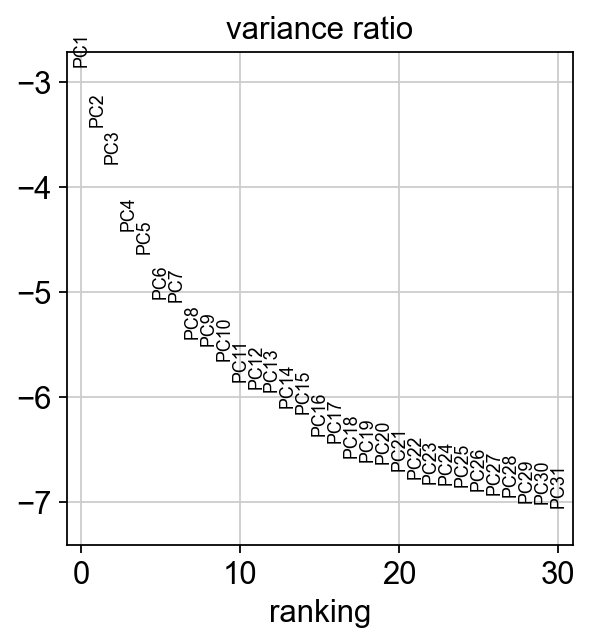

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


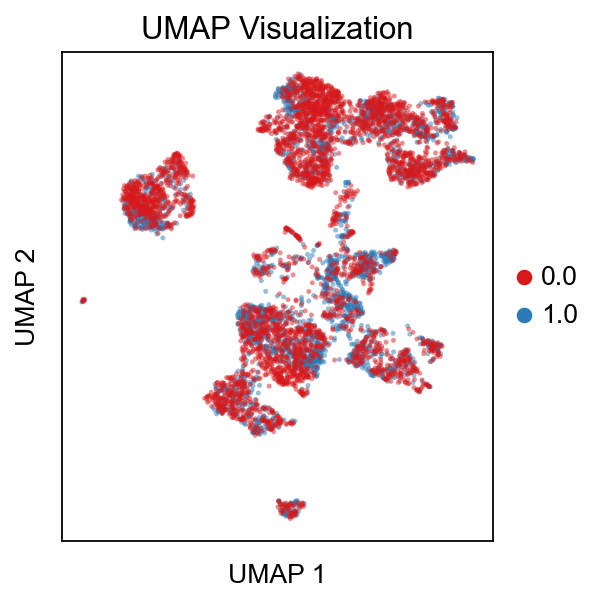

In [43]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
adata.var_names_make_unique()

# Preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(adata, save='5.pdf')

# Dimensionality reduction
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, save='6.pdf')

# Compute neighbors and UMAP (only once)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)


# Create the UMAP plot
sc.pl.umap(adata, 
           color='gender',           
           palette={1: '#2c7bb6', 0: '#d7191c'},
           size=20,                  
           alpha=0.5,                
           frameon=True,             
           legend_loc='right margin',
           title='UMAP Visualization',
           legend_fontsize=12,
           show=False)               

# Customize the plot
ax = plt.gca()
ax.set_title('UMAP Visualization', fontsize=14)
plt.xlabel('UMAP 1', fontsize=12, labelpad=10)
plt.ylabel('UMAP 2', fontsize=12, labelpad=10)
plt.grid(False)
ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.tight_layout()

# Save and display the plot
plt.savefig('umap_sex_difference.pdf', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')
plt.show()

## 2. Test Data Loading

### 2.1 Independent Test Dataset
Loading test dataset from `4_type.h5ad` containing multiple experimental conditions for model validation.

### 2.2 Test Data Processing
Extracting the same gene features and applying identical preprocessing pipeline to maintain consistency with training data.

In [4]:
!pip install pyranges
!pip install scanpy
import numpy as np
import pandas as pd
import scanpy as sc
import numpy as np
import pandas as pd
import scanpy as sc
neww=sc.read_h5ad("4_type.h5ad")

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [5]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
gene_ids = neww.var['gene_ids'] 
# # Load the dataset
adata = sc.read("4_type.h5ad")

conditions = adata.obs['conditions'].unique()

# Separating adata based on conditions
# It's a good idea to check the actual condition values and modify as needed
adata1 = adata[adata.obs['conditions'] == conditions[0], :]
adata2 = adata[adata.obs['conditions'] == conditions[1], :]
adata3 = adata[adata.obs['conditions'] == conditions[2], :]
adata4 = adata[adata.obs['conditions'] == conditions[3], :]

In [6]:
adata1

View of AnnData object with n_obs × n_vars = 8268 × 20902
    obs: 'dataset', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'conditions'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

In [7]:
conditions

['WT_WT', 'mdx_WT', 'WT_mdx', 'mdx_mdx']
Categories (4, object): ['WT_WT', 'mdx_WT', 'WT_mdx', 'mdx_mdx']

In [8]:
import scanpy as sc

# Assuming adata1 is already defined and loaded

# Plot the 20 highest expressed genes
# sc.pl.highest_expr_genes(adata1, n_top=20)

# Filter out genes that are detected in fewer than 3 cells
# sc.pp.filter_genes(adata1, min_cells=3)

# # # Normalize the data (scaling each cell to a total count of 1e4)
# sc.pp.normalize_total(adata1, target_sum=1e4)

# # # Logarithmically scale the data
# sc.pp.log1p(adata1)

# Convert the sparse matrix to a dense matrix and extract gene IDs
matrix = adata1.X.todense()  # Your matrix data
gene_ids = adata1.var.index  # Your gene IDs

# Create a DataFrame
df_adata1= pd.DataFrame(matrix, columns=gene_ids)

In [9]:
df_adata1

,Xkr4,Gm1992,Rp1,Sox17,Gm37587,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,...,CAAA01118383.1,AC132444.1,AC132444.5,Csprs,AC132444.6,Vamp7,Spry3,Tmlhe,CAAA01147332.1,AC149090.1
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.067894,0.0,1.067894,...,0.000000,0.0,0.0,0.0,0.0,0.821026,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.189107,0.0,1.189107,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.751662,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.616192,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,2.204726
4,0.0,0.0,0.0,0.0,0.0,0.473922,0.473922,1.036327,0.0,0.794151,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.473922,0.473922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8263,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,3.339708
8264,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.626800,0.0,1.398875,...,0.626800,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.361726
8265,0.0,0.0,0.0,0.0,0.0,0.499769,0.499769,0.499769,0.0,0.000000,...,0.499769,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.831465
8266,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.166482,0.0,1.462333,...,0.744476,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.166482


In [11]:
import pandas as pd

# Assuming df is your DataFrame
# And columns_to_extract is your list of column names
columns_to_extract = [ "Xist","Ddx3y","Gm42418","Eif2s3y","Rps27rt",
    "Rpl9-ps6","Kdm5d","Uba52","Rpl35","Rpl36a-ps1",
    "Uty","Wdr89","Lars2","Rps27"]
columns_to_extract = [col for col in columns_to_extract if col in df_adata1.columns]
extracted_columns = df_adata1[columns_to_extract]
 
 
extracted_columns_1 = df_adata1[columns_to_extract]


In [12]:

extracted_columns_1

,Xist,Ddx3y,Gm42418,Eif2s3y,Rps27rt,Rpl9-ps6,Kdm5d,Uba52,Rpl35,Rpl36a-ps1,Uty,Wdr89,Lars2,Rps27
0,0.0,0.492508,4.253757,0.492508,0.492508,0.000000,0.000000,0.821026,2.749676,0.000000,0.492508,0.000000,1.430808,3.000345
1,0.0,0.000000,4.766366,0.000000,0.000000,1.189107,0.000000,1.189107,2.519368,0.000000,0.000000,0.000000,1.717089,3.625577
2,0.0,1.751662,4.591736,0.000000,1.751662,0.000000,0.000000,1.218493,2.727364,0.000000,0.000000,0.000000,0.000000,3.603629
3,0.0,0.000000,5.250138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.616192,0.000000,1.616192,1.616192
4,0.0,0.794151,4.308918,0.000000,0.473922,0.473922,0.000000,1.231138,2.037198,0.000000,1.231138,0.000000,1.766484,2.619722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8263,0.0,0.000000,5.832282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.733287,0.000000
8264,0.0,0.361726,6.557333,0.626800,0.000000,0.000000,0.626800,0.626800,2.227895,0.361726,0.836129,0.000000,2.546845,2.476130
8265,0.0,0.499769,5.148435,0.499769,0.000000,0.000000,0.499769,1.279088,2.172486,0.000000,0.000000,0.000000,1.587201,3.192131
8266,0.0,0.744476,5.648857,0.000000,0.000000,0.744476,0.000000,0.000000,1.875901,0.000000,0.744476,0.744476,2.167609,2.489346


## infer data

In [85]:
inf_data=sc.read_h5ad("IFNR_infer_sexpredect_v2(1).h5ad"  )
# sc.pp.log1p(inf_data)

/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [86]:
import scanpy as sc

# Suppose we have 'group_column' in inf_data.obs 
# that can take values "groupA" and "groupB"

inf_IFNRKO = inf_data[inf_data.obs["group"] == "IFNRKO"].copy()
inf_CD45_1 = inf_data[inf_data.obs["group"] == "CD45_1"].copy()


/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [87]:
def process_inf_data(inf_data):
    import scanpy as sc
    import pandas as pd
    
    # Apply log1p
    sc.pp.log1p(inf_data)
    
    # Create the DataFrame
    matrix = inf_data.X
    gene_ids = inf_data.var.index
    df = pd.DataFrame(matrix, columns=gene_ids)
    
    return df


In [88]:
inf_IFNRKO_df = process_inf_data(inf_IFNRKO)
inf_CD45_1_df = process_inf_data(inf_CD45_1)

 


In [89]:
extracted_columns_IFNRKO = inf_IFNRKO_df[columns_to_extract]
extracted_columns_CD45 = inf_CD45_1_df[columns_to_extract]

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

def predict_and_plot(
    df, 
    model, 
    scaler, 
    output_prefix="output"
):
    """
    Scales the DataFrame `df` using the provided `scaler`,
    predicts labels using `model`,
    saves the predictions to a CSV file, 
    and generates a bar plot of predicted label proportions.

    Parameters
    ----------
    df : pd.DataFrame
        The test DataFrame to be predicted.
    model : a fitted sklearn-like model (e.g. XGBClassifier)
        The model used for prediction.
    scaler : an already fitted scaler (StandardScaler or similar)
        Used to transform the test data.
    output_prefix : str
        A prefix for naming the output CSV and PNG files.
    """
    # Scale the data
    df_scaled = scaler.transform(df)

    # Predict labels
    predicted_labels = model.predict(df_scaled)

    # Convert predictions to a DataFrame and save
    output_csv = f"{output_prefix}_predicted_labels.csv"
    pd.DataFrame({"Prediction": predicted_labels}).to_csv(output_csv, index=False)
    print(f"Predicted labels saved to '{output_csv}'.")

    # Calculate percentages for the bar plot
    label_counts = pd.Series(predicted_labels).value_counts(normalize=True) * 100  # Convert to percentages

    # Create a bar plot
    ax = label_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
    plt.xlabel("Prediction")
    plt.ylabel("Percentage")
    plt.title("Proportions of Predicted Labels")
    plt.xticks([0, 1], labels=['0', '1'], rotation=0)
    plt.ylim(0, 100)  # Ensure the y-axis ranges from 0 to 100

    # Add percentage labels on the bars
    for i, v in enumerate(label_counts):
        plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom', fontsize=7)

    # Save and close the plot
    output_png = f"{output_prefix}_prediction_percentage_barplot.png"
    plt.savefig(output_png, dpi=300)
    plt.close()  # Close the figure so we don't keep re-drawing
    print(f"Bar plot of predicted label percentages saved to '{output_png}'.\n")


In [91]:
# For reproducibility
np.random.seed(42)

# Example training data: full_X_train, full_Y_train
# You have your model definition, for example:
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=300,
    learning_rate=0.01,
    max_depth=6,
    random_state=551
)

# Fit the scaler on training data
scaler = StandardScaler()
full_X_train_scaled = scaler.fit_transform(full_X_train)

# Fit the model on the training data
model.fit(full_X_train_scaled, full_Y_train)


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [21:14:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=551, ...)

In [92]:
# Suppose you have two DataFrames:
#   inf_IFNRKO_df
#   inf_CD45_1_df

# Call the function for the first DataFrame
predict_and_plot(
    df=extracted_columns_IFNRKO ,
    model=model,
    scaler=scaler,
    output_prefix="inf_IFNRKO"  # This will produce "inf_IFNRKO_predicted_labels.csv" and "inf_IFNRKO_prediction_percentage_barplot.png"
)

# Call the function for the second DataFrame
predict_and_plot(
    df=extracted_columns_CD45,
    model=model,
    scaler=scaler,
    output_prefix="inf_CD45_1"
)


Predicted labels saved to 'inf_IFNRKO_predicted_labels.csv'.
Bar plot of predicted label percentages saved to 'inf_IFNRKO_prediction_percentage_barplot.png'.

Predicted labels saved to 'inf_CD45_1_predicted_labels.csv'.
Bar plot of predicted label percentages saved to 'inf_CD45_1_prediction_percentage_barplot.png'.



In [36]:
adata

AnnData object with n_obs × n_vars = 6648 × 17153
    obs: 'gender', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'gender_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [37]:
rc = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
rc["y"] = pd.Categorical(joined_list)


In [38]:
rc

n,Sox17,Mrpl15,Lypla1,Tcea1,Gm16041,Atp6v1h,Rb1cc1,4732440D04Rik,St18,Pcmtd1,...,AC168977.1,CAAA01118383.1,AC132444.1,AC132444.5,Csprs,Vamp7,Tmlhe,CAAA01147332.1,AC149090.1,y
Cell_0,0.0,0.00000,1.354815,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.909851,1.0
Cell_1,0.0,0.00000,0.000000,1.223296,0.0,0.00000,0.788087,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.788087,1.0
Cell_2,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0
Cell_3,0.0,0.00000,0.000000,2.327345,0.0,0.00000,0.000000,0.0,0.0,2.327345,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,2.327345,1.0
Cell_4,0.0,0.94693,0.000000,0.946930,0.0,0.94693,0.946930,0.0,0.0,0.000000,...,0.0,0.946930,0.0,0.0,0.0,0.000000,0.0,0.0,0.946930,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_6643,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,1.474856,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
Cell_6644,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
Cell_6645,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,1.235361,...,0.0,0.000000,0.0,0.0,0.0,1.235361,0.0,0.0,0.000000,0.0
Cell_6646,0.0,0.00000,0.000000,0.000000,0.0,0.00000,1.482703,0.0,0.0,1.482703,...,0.0,1.482703,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


## 3. Validation Data Processing

### 3.1 Real Experimental Dataset
Loading experimental data:
- `matrix.mtx`: Expression count matrix (32,285 genes)
- `features.tsv`: Gene annotations
- `tag.csv`: Cell metadata with sex labels
- `barcodes.tsv`: Cell identifiers

### 3.2 Sex Label Assignment
- CMO305 → Male (1)
- CMO306 → Female (0)

### 3.3 Data Processing
Applying same preprocessing pipeline and extracting 14-gene panel for consistency.

In [18]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from numpy.core.fromnumeric import transpose
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 pynndescent==0.5.13
filtered out 3 cells that have less than 100 genes expressed
filtered out 19261 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)


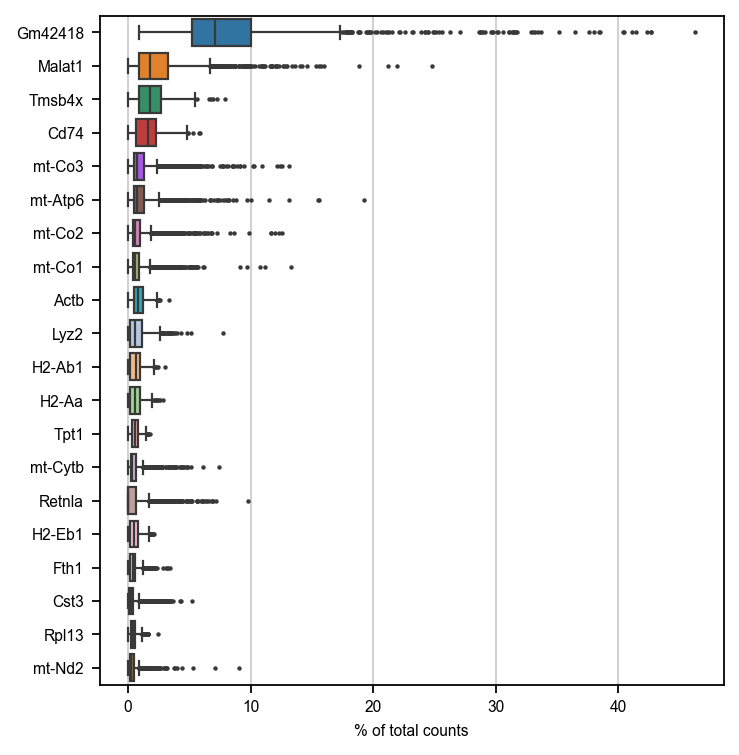

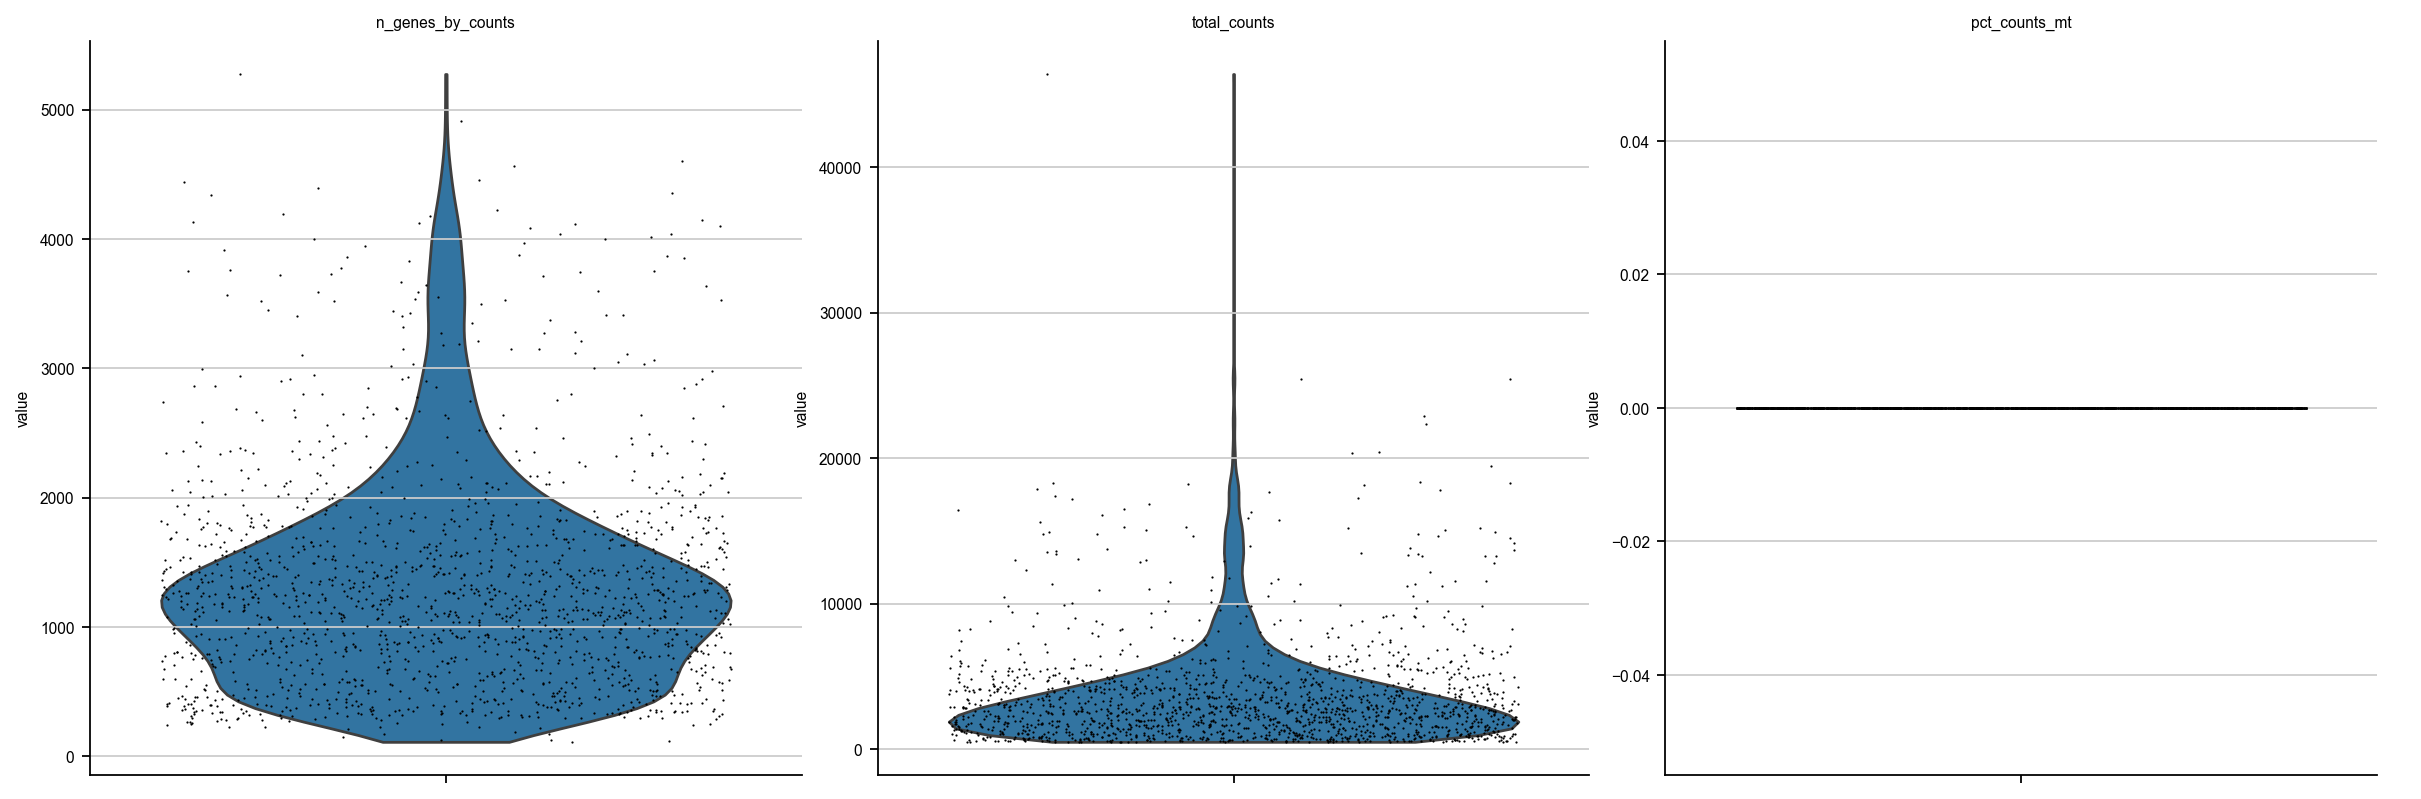

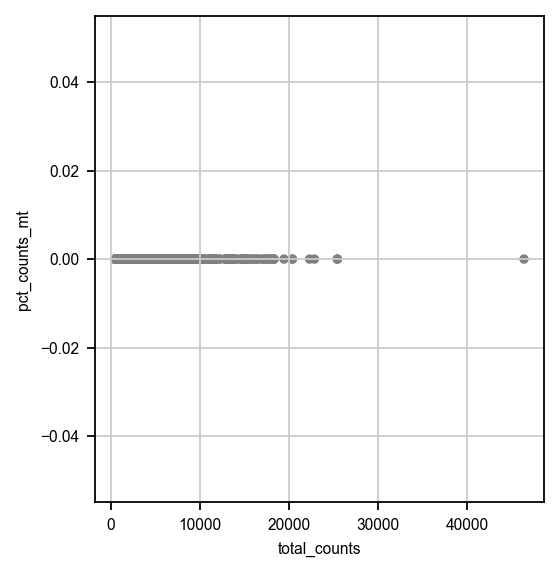

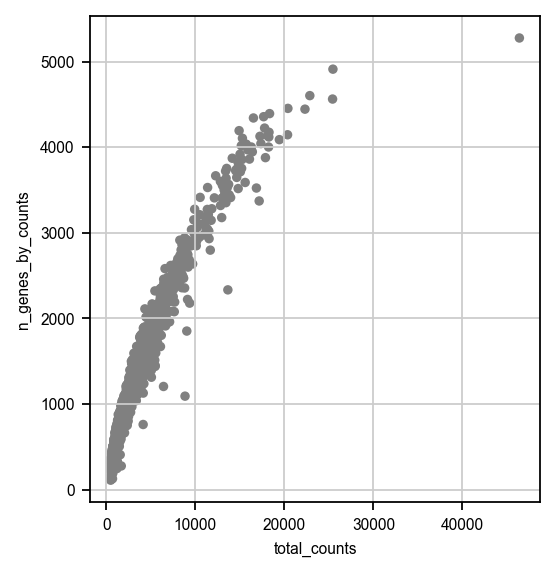

normalizing counts per cell
    finished (0:00:00)
1649
                    Mrpl15  Lypla1     Tcea1  Atp6v1h    Rb1cc1  \
AAACCCAAGACAGCTG-1     0.0     0.0  0.000000      0.0  0.000000   
AAACCCACAAAGACGC-1     0.0     0.0  0.000000      0.0  1.921457   
AAACGAAAGCACTCGC-1     0.0     0.0  0.000000      0.0  0.000000   
AAACGAACAAATGGTA-1     0.0     0.0  0.000000      0.0  0.000000   
AAAGGATGTGTGTTTG-1     0.0     0.0  0.000000      0.0  2.565319   
...                    ...     ...       ...      ...       ...   
TTTGGTTCAGTGGCTC-1     0.0     0.0  0.000000      0.0  0.000000   
TTTGGTTGTAACGTTC-1     0.0     0.0  0.000000      0.0  0.000000   
TTTGGTTTCAGCGTCG-1     0.0     0.0  1.767994      0.0  0.000000   
TTTGTTGGTACGTTCA-1     0.0     0.0  0.000000      0.0  0.000000   
TTTGTTGGTCCACTCT-1     0.0     0.0  1.086885      0.0  0.000000   

                    4732440D04Rik    Pcmtd1  Gm26901      Rrs1  2610203C22Rik  \
AAACCCAAGACAGCTG-1            0.0  0.744418      0.0  0.00

/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_92685/327623629.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_df['gender']=result['gender']


AAACCCAAGACAGCTG-1    1.0
AAACCCACAAAGACGC-1    1.0
AAACGAAAGCACTCGC-1    1.0
AAACGAACAAATGGTA-1    1.0
AAAGGATGTGTGTTTG-1    1.0
                     ... 
TTTGGTTCAGTGGCTC-1    0.0
TTTGGTTGTAACGTTC-1    0.0
TTTGGTTTCAGCGTCG-1    1.0
TTTGTTGGTACGTTCA-1    1.0
TTTGTTGGTCCACTCT-1    1.0
Name: gender, Length: 1649, dtype: float64

In [21]:
realmat = sc.read_mtx('matrix.mtx')
realfeature=pd.read_csv('features.tsv',sep='\t',header=None)
realmat=realmat[0:32285]
realtag=pd.read_csv('tag.csv')
actt=realfeature.loc[realfeature[2] == 'Gene Expression']
celltag=pd.read_csv('barcodes.tsv',sep='\t',header=None)
adata = anndata.AnnData(X=realmat.X.T)
lol = list(celltag[0])  # or pd.Series(actt[1])
adata.obs['cell'] = lol
lmao = list(actt[1])  # or pd.Series(actt[1])
adata.var['gene_ids'] = lmao
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', fontsize=7
                              )
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

adata
adata.var['mt'] =  adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var
# Remove headers and set the index to 'gene_ids'
adata.var.index = adata.var['gene_ids'].values
adata.var.index.name = None  # This removes the header (name) of the index
adata.obs

#adata.var.index = actt[1].astype('string')
sc.pl.highest_expr_genes(adata, n_top=20, )
adata.var_names_make_unique()  # this is unnecessary if us
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True,save='8.pdf')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',save='9.pdf')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',save='10.pdf')
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
METT=adata.X
dense_matrix = METT.toarray()

#METT = METT[~METT['cell'].isin(realtag['cell_barcode'])
# Convert the dense NumPy array to a Pandas DataFrame
METT = pd.DataFrame(dense_matrix,columns=adata.var_names, index=adata.obs['cell'].values)
METT['cell']=adata.obs['cell'].values
realtag.index=realtag['cell_barcode'].values
result = METT.join(realtag[['feature_call']], how='left')
print(METT.index.isin(realtag.index).sum())
result
# Remove rows where 'gender' is NaN
result = result.dropna(subset=['feature_call'])

print(result)
# Initialize the 'gender' column with NaN or some default value
result['gender'] = None

# Update 'gender' based on 'feature_call'
result.loc[result['feature_call'] == 'CMO305', 'gender'] = 1
result.loc[result['feature_call'] == 'CMO306', 'gender'] = 0
print(result)


columns_to_extract = ["Xist", "Ddx3y", "Gm42418", "Eif2s3y", "Rps27rt",
    "Rpl9-ps6", "Kdm5d", "Uba52", "Rpl35", "Rpl36a-ps1",
    "Uty", "Wdr89", "Lars2", "Rps27"]


extracted_df = result[columns_to_extract]
print(extracted_df)
extracted_df['gender']=result['gender']
realtest=extracted_df.drop('gender',axis=1)
realtest_y=result['gender']
realtest_y = realtest_y.astype('float') 
realtest_y

In [22]:
ffrc=rc.loc[:,columns_to_extract]
ffrc["y"] = pd.Categorical(joined_list)
female_exp = result[result['gender'] == 0]
male_exp = result[result['gender'] == 1]
female_exp_data= female_exp.drop('gender',axis=1)
male_exp_data= male_exp.drop('gender',axis=1)




In [23]:
result 

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,4732440D04Rik,Pcmtd1,Gm26901,Rrs1,2610203C22Rik,...,AC125149.3,AC168977.1,CAAA01118383.1,Csprs,Vamp7,CAAA01147332.1,AC149090.1,cell,feature_call,gender
AAACCCAAGACAGCTG-1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.744418,0.0,0.000000,0.0,...,0.0,0.0,0.744418,0.0,0.0,0.0,0.000000,AAACCCAAGACAGCTG-1,CMO305,1
AAACCCACAAAGACGC-1,0.0,0.0,0.000000,0.0,1.921457,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.921457,AAACCCACAAAGACGC-1,CMO305,1
AAACGAAAGCACTCGC-1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,AAACGAAAGCACTCGC-1,CMO305,1
AAACGAACAAATGGTA-1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,AAACGAACAAATGGTA-1,CMO305,1
AAAGGATGTGTGTTTG-1,0.0,0.0,0.000000,0.0,2.565319,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,AAAGGATGTGTGTTTG-1,CMO305,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAGTGGCTC-1,0.0,0.0,0.000000,0.0,0.000000,0.0,1.859427,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.859427,TTTGGTTCAGTGGCTC-1,CMO306,0
TTTGGTTGTAACGTTC-1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,2.763031,TTTGGTTGTAACGTTC-1,CMO306,0
TTTGGTTTCAGCGTCG-1,0.0,0.0,1.767994,0.0,0.000000,0.0,1.767994,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,TTTGGTTTCAGCGTCG-1,CMO305,1
TTTGTTGGTACGTTCA-1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2.698028,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,TTTGTTGGTACGTTCA-1,CMO305,1


In [24]:
male_exp_data

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,4732440D04Rik,Pcmtd1,Gm26901,Rrs1,2610203C22Rik,...,mt-Cytb,AC125149.3,AC168977.1,CAAA01118383.1,Csprs,Vamp7,CAAA01147332.1,AC149090.1,cell,feature_call
AAACCCAAGACAGCTG-1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.744418,0.0,0.000000,0.0,...,3.274121,0.0,0.0,0.744418,0.0,0.0,0.0,0.000000,AAACCCAAGACAGCTG-1,CMO305
AAACCCACAAAGACGC-1,0.0,0.000000,0.000000,0.0,1.921457,0.0,0.000000,0.0,0.000000,0.0,...,4.262269,0.0,0.0,0.000000,0.0,0.0,0.0,1.921457,AAACCCACAAAGACGC-1,CMO305
AAACGAAAGCACTCGC-1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,5.364882,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,AAACGAAAGCACTCGC-1,CMO305
AAACGAACAAATGGTA-1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,4.365047,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,AAACGAACAAATGGTA-1,CMO305
AAAGGATGTGTGTTTG-1,0.0,0.000000,0.000000,0.0,2.565319,0.0,0.000000,0.0,0.000000,0.0,...,5.380296,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,AAAGGATGTGTGTTTG-1,CMO305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCGTCCGTTTC-1,0.0,0.414969,0.414969,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,3.867098,0.0,0.0,0.414969,0.0,0.0,0.0,0.933333,TTTGATCGTCCGTTTC-1,CMO305
TTTGGAGCAGTGACCC-1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,4.696054,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,TTTGGAGCAGTGACCC-1,CMO305
TTTGGTTTCAGCGTCG-1,0.0,0.000000,1.767994,0.0,0.000000,0.0,1.767994,0.0,0.000000,0.0,...,3.800684,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,TTTGGTTTCAGCGTCG-1,CMO305
TTTGTTGGTACGTTCA-1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,2.698028,0.0,...,4.032499,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,TTTGTTGGTACGTTCA-1,CMO305


In [25]:
realtest

,Xist,Ddx3y,Gm42418,Eif2s3y,Rps27rt,Rpl9-ps6,Kdm5d,Uba52,Rpl35,Rpl36a-ps1,Uty,Wdr89,Lars2,Rps27
AAACCCAAGACAGCTG-1,0.000000,0.000000,5.790079,0.000000,0.000000,0.0,0.0,0.744418,1.690256,0.0,0.0,0.000000,2.167511,2.489244
AAACCCACAAAGACGC-1,0.000000,0.000000,6.888156,0.000000,0.000000,0.0,0.0,2.538590,0.000000,0.0,0.0,1.921457,3.191448,2.538590
AAACGAAAGCACTCGC-1,0.000000,0.000000,5.788145,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
AAACGAACAAATGGTA-1,0.000000,0.000000,5.986185,0.000000,2.264689,0.0,0.0,2.264689,0.000000,0.0,0.0,0.000000,2.904508,0.000000
AAAGGATGTGTGTTTG-1,0.000000,0.000000,8.123958,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,3.219260,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAGTGGCTC-1,3.335779,0.000000,7.200241,0.000000,0.000000,0.0,0.0,1.859427,2.471493,0.0,0.0,0.000000,2.471493,0.000000
TTTGGTTGTAACGTTC-1,3.969675,0.000000,6.050117,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2.131073
TTTGGTTTCAGCGTCG-1,0.000000,0.000000,6.049121,0.000000,0.000000,0.0,0.0,1.767994,2.745812,0.0,0.0,0.000000,0.000000,2.745812
TTTGTTGGTACGTTCA-1,0.000000,0.000000,7.608987,0.000000,0.000000,0.0,0.0,2.070049,3.080791,0.0,0.0,0.000000,3.356926,3.573077


In [26]:
realtest_y

AAACCCAAGACAGCTG-1    1.0
AAACCCACAAAGACGC-1    1.0
AAACGAAAGCACTCGC-1    1.0
AAACGAACAAATGGTA-1    1.0
AAAGGATGTGTGTTTG-1    1.0
                     ... 
TTTGGTTCAGTGGCTC-1    0.0
TTTGGTTGTAACGTTC-1    0.0
TTTGGTTTCAGCGTCG-1    1.0
TTTGTTGGTACGTTCA-1    1.0
TTTGTTGGTCCACTCT-1    1.0
Name: gender, Length: 1649, dtype: float64

In [27]:
full_train = rc.sample(frac=1, random_state=25) 
full_Y_train=full_train["y"]
full_X_train=full_train.drop(["y"],axis=1) 
full_X_train = full_X_train[columns_to_extract]

In [28]:
full_X_train

n,Xist,Ddx3y,Gm42418,Eif2s3y,Rps27rt,Rpl9-ps6,Kdm5d,Uba52,Rpl35,Rpl36a-ps1,Uty,Wdr89,Lars2,Rps27
Cell_1678,0.0,0.0,13.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0
Cell_3705,5.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cell_5187,10.0,0.0,28.0,0.0,3.0,2.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,1.0
Cell_1921,0.0,1.0,19.0,0.0,1.0,2.0,0.0,2.0,6.0,1.0,0.0,1.0,1.0,2.0
Cell_1575,0.0,0.0,32.0,0.0,17.0,6.0,0.0,5.0,13.0,3.0,0.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_2934,7.0,0.0,14.0,0.0,6.0,1.0,0.0,0.0,8.0,2.0,0.0,0.0,1.0,5.0
Cell_2191,0.0,0.0,27.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,3.0,1.0
Cell_6618,7.0,0.0,16.0,0.0,2.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,1.0
Cell_318,0.0,0.0,8.0,0.0,6.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


## 4. Batch Effect Correction with Scanorama

### 4.1 Scanorama Batch Correction
Testing model robustness against technical batch effects using Scanorama integration method.

**Purpose**: Showing batch correction hurt biology signals.

**Method**: 
- Apply Scanorama batch correction to separate male/female batches
- Re-train models on original data, test on batch-corrected data
- Compare performance before and after correction

### 4.2 Batch-Corrected Performance Evaluation
Comprehensive evaluation including:
- ROC and Precision-Recall curves
- Complete curve data export for reproducibility
- Performance metrics comparison (original vs corrected)

Checking original data...
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (1649, 13027)
Data types of first few columns: Mrpl15     float32
Lypla1     float32
Tcea1      float32
Atp6v1h    float32
Rb1cc1     float32
dtype: object
Any non-numeric columns? True
NaN count per column (first 5): [0, 0, 0, 0, 0]
Total NaN values: 0
Converting to numeric efficiently...

Expression shape: (1649, 13026)
Gender values: [0. 1.]
NaN in expression data: 3298 out of 21479874 values
NaN in gender: 0 out of 1649 values
Found 2 columns that are all NaN. Removing them...

Final shapes - Expression: (1649, 13024), Gender: 1649
Gender distribution: [ 222 1427]

Male samples: 222, Female samples: 1427

Applying Scanorama batch correction...
Found 13024 genes among all datasets
[[0.        0.9954955]
 [0.        0.       ]]
Processing datasets (0, 1)
Scanorama failed: setting an array element with a sequence.
Falling back to simple batch correction...

Success! Final shape: (1649, 13024)

Original shapes

/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [18:04:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  → AUROC: 0.607, AUPRC: 0.866


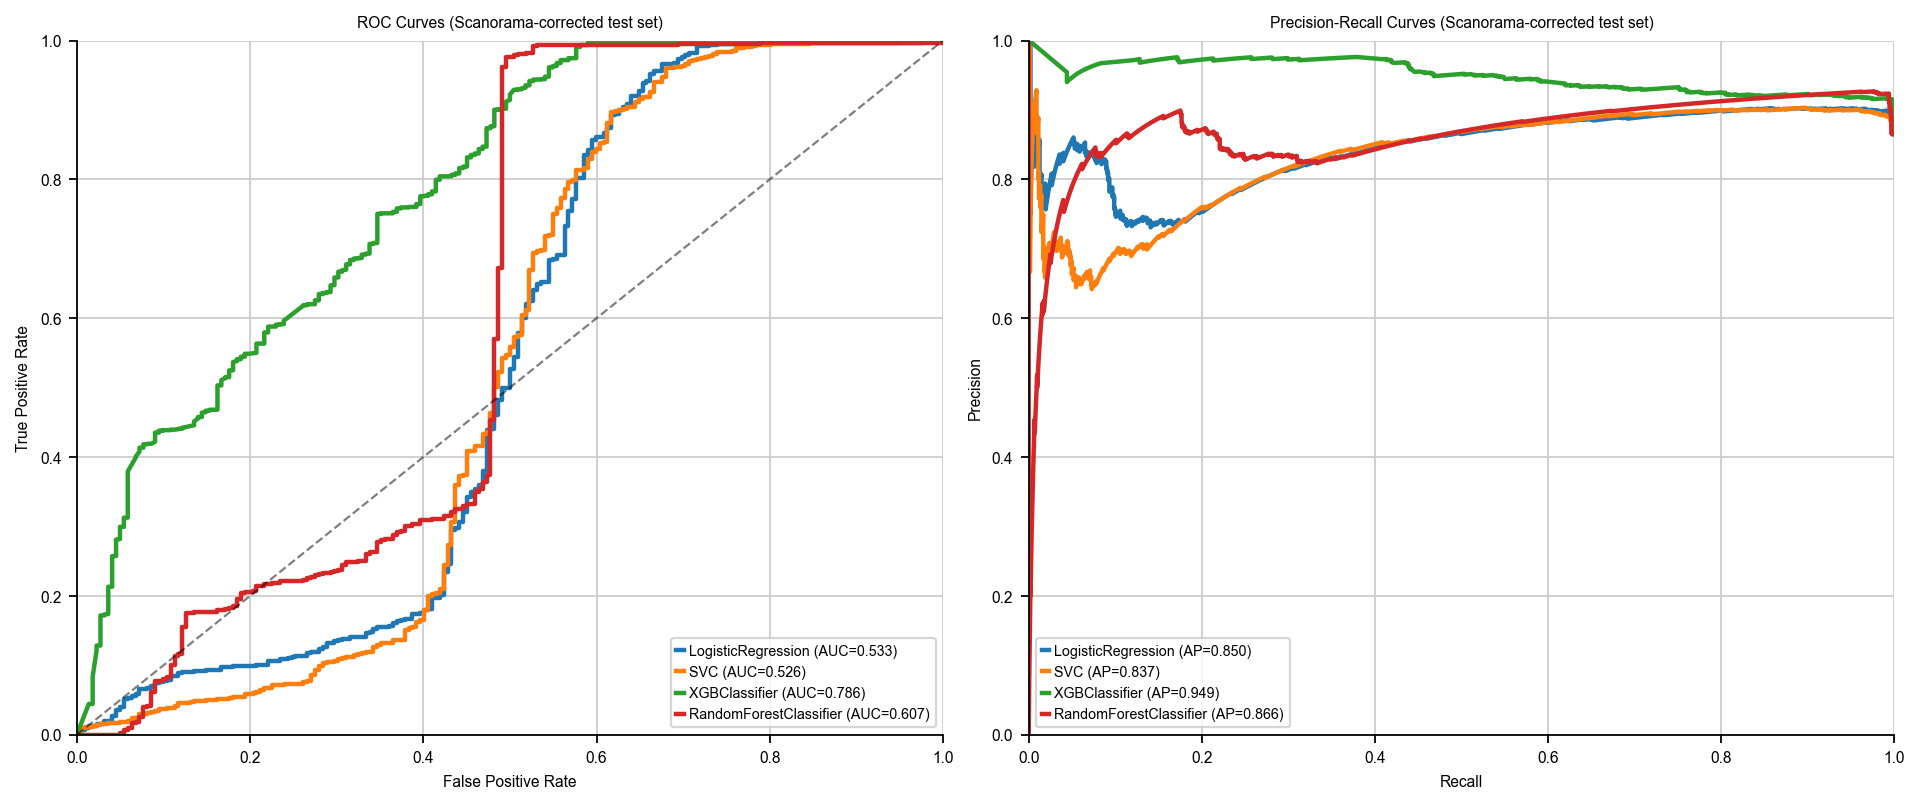


💾 Saving curve data...
   ✅ JSON: /Users/haley/Desktop/send_tooo/AAA_final/scanorama/curve_data_scanorama.json
   ✅ Pickle: /Users/haley/Desktop/send_tooo/AAA_final/scanorama/curve_data_scanorama.pkl
   ✅ ROC CSV: /Users/haley/Desktop/send_tooo/AAA_final/scanorama/csv_curves/roc_curves_scanorama.csv
   ✅ PRC CSV: /Users/haley/Desktop/send_tooo/AAA_final/scanorama/csv_curves/prc_curves_scanorama.csv
   ✅ Summary CSV: /Users/haley/Desktop/send_tooo/AAA_final/scanorama/summary_metrics_scanorama.csv
   ✅ Loading script: /Users/haley/Desktop/send_tooo/AAA_final/scanorama/load_and_plot_curves.py

✅ All files saved to: /Users/haley/Desktop/send_tooo/AAA_final/scanorama

Files created:
   📊 Plots:
      └─ roc_prc_scanorama.png
      └─ roc_prc_scanorama.pdf
   📁 Curve Data:
      └─ curve_data_scanorama.json (complete data)
      └─ curve_data_scanorama.pkl (Python binary)
      └─ summary_metrics_scanorama.csv (summary table)
      └─ csv_curves/roc_curves_scanorama.csv (ROC points)
      └

In [30]:
#!/usr/bin/env python3
"""
Train models on original training data, test on Scanorama-corrected data,
save ROC/PRC plots, and export all curve data points for later use.
"""
import numpy as np
import pandas as pd
import scanorama
import pickle
import json

# First, let's check what's in your data
print("Checking original data...")
print(f"Type: {type(result)}")
print(f"Shape: {result.shape}")

# Check if data is already numeric
if isinstance(result, pd.DataFrame):
    print(f"Data types of first few columns: {result.dtypes[:5]}")
    print(f"Any non-numeric columns? {not all(result.dtypes.apply(lambda x: np.issubdtype(x, np.number)))}")
    
    # Check for actual NaN values
    print(f"NaN count per column (first 5): {result.isnull().sum()[:5].tolist()}")
    print(f"Total NaN values: {result.isnull().sum().sum()}")

# Scanorama batch correction function
def scanorama_correction(result):
    """
    Batch correction using Scanorama instead of ComBat.
    """
    
    # Convert to numeric if needed
    if isinstance(result, pd.DataFrame):
        if all(result.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
            print("Data is already numeric!")
            data_array = result.values
            gene_names = result.columns[:-1].tolist()  # Get gene names
        else:
            print("Converting to numeric efficiently...")
            result_numeric = result.apply(pd.to_numeric, errors='coerce')
            data_array = result_numeric.values
            gene_names = result.columns[:-1].tolist()
    else:
        data_array = result.astype(float)
        gene_names = [f"Gene_{i}" for i in range(data_array.shape[1] - 1)]
    
    # Extract expression and gender
    expression_data = data_array[:, :-1]
    gender = data_array[:, -1]
    
    print(f"\nExpression shape: {expression_data.shape}")
    print(f"Gender values: {np.unique(gender[~np.isnan(gender)])}")
    
    # Handle NaN values
    expr_nan_count = np.isnan(expression_data).sum()
    gender_nan_count = np.isnan(gender).sum()
    
    print(f"NaN in expression data: {expr_nan_count} out of {expression_data.size} values")
    print(f"NaN in gender: {gender_nan_count} out of {len(gender)} values")
    
    # Remove columns that are all NaN
    cols_all_nan = np.isnan(expression_data).all(axis=0)
    if cols_all_nan.any():
        print(f"Found {cols_all_nan.sum()} columns that are all NaN. Removing them...")
        expression_data = expression_data[:, ~cols_all_nan]
        gene_names = [gene for gene, is_nan in zip(gene_names, cols_all_nan) if not is_nan]
    
    # Replace remaining NaN with 0 (Scanorama doesn't handle NaN well)
    if np.isnan(expression_data).any():
        print("Replacing remaining NaN values with 0...")
        expression_data = np.nan_to_num(expression_data, nan=0)
    
    # Ensure gender is valid
    gender = np.nan_to_num(gender, nan=0).astype(int)
    
    print(f"\nFinal shapes - Expression: {expression_data.shape}, Gender: {len(gender)}")
    print(f"Gender distribution: {np.bincount(gender)}")
    
    # Split data by gender for Scanorama
    male_mask = gender == 0
    female_mask = gender == 1
    
    male_data = expression_data[male_mask]
    female_data = expression_data[female_mask]
    
    print(f"\nMale samples: {male_data.shape[0]}, Female samples: {female_data.shape[0]}")
    
    # Prepare data for Scanorama
    # Scanorama expects a list of datasets
    datasets = [male_data, female_data]
    genes_list = [gene_names, gene_names]  # Same genes for both
    
    try:
        # Apply Scanorama correction
        print("\nApplying Scanorama batch correction...")
        corrected_datasets, _ = scanorama.correct(datasets, genes_list, return_dimred=False)
        
        # Combine corrected datasets back together
        male_corrected = corrected_datasets[0]
        female_corrected = corrected_datasets[1]
        
        # Reconstruct full dataset in original order
        corrected_data = np.zeros_like(expression_data)
        corrected_data[male_mask] = male_corrected
        corrected_data[female_mask] = female_corrected
        
        print(f"Scanorama correction complete! Shape: {corrected_data.shape}")
        return corrected_data
        
    except Exception as e:
        print(f"Scanorama failed: {e}")
        print("Falling back to simple batch correction...")
        return simple_batch_correction(expression_data, gender)

def simple_batch_correction(expression_data, gender):
    """
    Simple batch correction as fallback.
    """
    corrected = expression_data.copy()
    
    for col in range(expression_data.shape[1]):
        feature = expression_data[:, col]
        for g in np.unique(gender):
            mask = gender == g
            if mask.sum() > 0:
                corrected[mask, col] = feature[mask] - np.nanmean(feature[mask]) + np.nanmean(feature)
    
    return corrected

# Apply Scanorama correction
realtest_scanorama = scanorama_correction(result)

if realtest_scanorama is not None:
    print(f"\nSuccess! Final shape: {realtest_scanorama.shape}")

# Now continue with the ML pipeline
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ── global config ──────────────────────────────────────────────────────────
rcParams.update({"font.family": "Arial", "font.size": 7})
OUTDIR = Path("/Users/haley/Desktop/send_tooo/AAA_final/scanorama")
OUTDIR.mkdir(exist_ok=True)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

models = [
    LogisticRegression(max_iter=1000, random_state=551),
    SVC(kernel="linear", probability=True, random_state=551),
    XGBClassifier(
        random_state=551,
        use_label_encoder=False,
        eval_metric="logloss",
        n_estimators=100,
        learning_rate=0.05,
        max_depth=10,
    ),
    RandomForestClassifier(max_depth=10, random_state=41),
]

# ── define columns to extract ──────────────────────────────────────────────
columns_to_extract = [
    "Xist", "Ddx3y", "Gm42418", "Eif2s3y", "Rps27rt",
    "Rpl9-ps6", "Kdm5d", "Uba52", "Rpl35", "Rpl36a-ps1",
    "Uty", "Wdr89", "Lars2", "Rps27"
]

# ── align features between train and test ──────────────────────────────────
print(f"\nOriginal shapes:")
print(f"  Training: {full_X_train.shape}")
print(f"  Test: {realtest_scanorama.shape}")

# Convert realtest_scanorama to DataFrame if it's an array
if isinstance(realtest_scanorama, np.ndarray):
    # Need to get column names from somewhere - assuming they match the original data
    if 'result' in globals() and isinstance(result, pd.DataFrame):
        # Use column names from the original result DataFrame (minus the last gender column)
        test_columns = result.columns[:-1]
        # Account for any removed all-NaN columns
        if realtest_scanorama.shape[1] < len(test_columns):
            # Some columns were removed, need to figure out which ones
            test_columns = test_columns[:realtest_scanorama.shape[1]]
        realtest_scanorama_df = pd.DataFrame(realtest_scanorama, columns=test_columns)
    else:
        print("ERROR: Cannot determine column names for test data")
        raise ValueError("Need column names to extract specific features")
else:
    realtest_scanorama_df = realtest_scanorama

# Extract only the columns that exist in the test data
available_columns = [col for col in columns_to_extract if col in realtest_scanorama_df.columns]
missing_columns = [col for col in columns_to_extract if col not in realtest_scanorama_df.columns]

if missing_columns:
    print(f"WARNING: Missing columns in test data: {missing_columns}")

print(f"Extracting {len(available_columns)} columns from test data")
realtest_scanorama_aligned = realtest_scanorama_df[available_columns]

print(f"\nAligned shapes:")
print(f"  Training: {full_X_train.shape}")
print(f"  Test: {realtest_scanorama_aligned.shape}")

# Verify they match
if realtest_scanorama_aligned.shape[1] != full_X_train.shape[1]:
    print(f"ERROR: Feature count mismatch! Train has {full_X_train.shape[1]}, test has {realtest_scanorama_aligned.shape[1]}")
    print("Please check that the training data used the same columns")

# ── scale data ─────────────────────────────────────────────────────────────
scaler = StandardScaler()
X_train_s = scaler.fit_transform(full_X_train)
X_test_s = scaler.transform(realtest_scanorama_aligned)

# ── Initialize data storage for curves ─────────────────────────────────────
curve_data = {
    'roc_curves': {},
    'prc_curves': {},
    'summary_metrics': {},
    'metadata': {
        'test_samples': len(realtest_y),
        'features_used': available_columns,
        'class_distribution': np.bincount(realtest_y).tolist(),
        'correction_method': 'scanorama'
    }
}

# ── create plots ───────────────────────────────────────────────────────────
plt.figure(figsize=(12, 5))
roc_ax = plt.subplot(1, 2, 1)
pr_ax = plt.subplot(1, 2, 2)

# ── fit, predict, plot ─────────────────────────────────────────────────────
for model, color in zip(models, colors):
    name = model.__class__.__name__
    print(f"\nTraining {name}...")
    
    model.fit(X_train_s, full_Y_train)
    y_prob = model.predict_proba(X_test_s)[:, 1]

    # ROC
    fpr, tpr, roc_thresholds = roc_curve(realtest_y, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_ax.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})', color=color, lw=2)

    # PR
    prec, rec, prc_thresholds = precision_recall_curve(realtest_y, y_prob)
    pr_auc = average_precision_score(realtest_y, y_prob)
    pr_ax.plot(rec, prec, label=f'{name} (AP={pr_auc:.3f})', color=color, lw=2)
    
    print(f"  → AUROC: {roc_auc:.3f}, AUPRC: {pr_auc:.3f}")
    
    # ── Store curve data ───────────────────────────────────────────────────
    # ROC curve data
    curve_data['roc_curves'][name] = {
        'fpr': fpr.tolist(),
        'tpr': tpr.tolist(),
        'thresholds': roc_thresholds.tolist(),
        'auc': float(roc_auc)
    }
    
    # PRC curve data  
    curve_data['prc_curves'][name] = {
        'precision': prec.tolist(),
        'recall': rec.tolist(),
        'thresholds': prc_thresholds.tolist(),
        'average_precision': float(pr_auc)
    }
    
    # Summary metrics
    curve_data['summary_metrics'][name] = {
        'auroc': float(roc_auc),
        'auprc': float(pr_auc),
        'color': color,
        'n_roc_points': len(fpr),
        'n_prc_points': len(prec)
    }

# ── format plots ───────────────────────────────────────────────────────────
roc_ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)  # diagonal line
roc_ax.set_xlim([0, 1])
roc_ax.set_ylim([0, 1])
roc_ax.set_xlabel("False Positive Rate")
roc_ax.set_ylabel("True Positive Rate")
roc_ax.set_title("ROC Curves (Scanorama-corrected test set)")
roc_ax.legend(loc="lower right")

pr_ax.set_xlim([0, 1])
pr_ax.set_ylim([0, 1])
pr_ax.set_xlabel("Recall")
pr_ax.set_ylabel("Precision")
pr_ax.set_title("Precision-Recall Curves (Scanorama-corrected test set)")
pr_ax.legend(loc="lower left")

# Remove top and right spines
for ax in (roc_ax, pr_ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()

# ── save plots ─────────────────────────────────────────────────────────────
plt.savefig(OUTDIR / "roc_prc_scanorama.png", dpi=300, bbox_inches='tight')
plt.savefig(OUTDIR / "roc_prc_scanorama.pdf", dpi=300, bbox_inches='tight')
plt.show()

# ── Save curve data in multiple formats ────────────────────────────────────
print(f"\n💾 Saving curve data...")

# 1. Save as JSON (human-readable, cross-platform)
json_path = OUTDIR / "curve_data_scanorama.json"
with open(json_path, 'w') as f:
    json.dump(curve_data, f, indent=2)
print(f"   ✅ JSON: {json_path}")

# 2. Save as pickle (Python-specific but preserves exact numpy arrays)
pickle_path = OUTDIR / "curve_data_scanorama.pkl"
with open(pickle_path, 'wb') as f:
    pickle.dump(curve_data, f)
print(f"   ✅ Pickle: {pickle_path}")

# 3. Save individual CSV files for each curve type
csv_dir = OUTDIR / "csv_curves"
csv_dir.mkdir(exist_ok=True)

# ROC curves CSV
roc_csv_data = []
for model_name, roc_data in curve_data['roc_curves'].items():
    for i, (fpr, tpr, threshold) in enumerate(zip(roc_data['fpr'], roc_data['tpr'], roc_data['thresholds'])):
        roc_csv_data.append({
            'model': model_name,
            'point_index': i,
            'fpr': fpr,
            'tpr': tpr,
            'threshold': threshold,
            'auc': roc_data['auc']
        })

roc_df = pd.DataFrame(roc_csv_data)
roc_csv_path = csv_dir / "roc_curves_scanorama.csv"
roc_df.to_csv(roc_csv_path, index=False)
print(f"   ✅ ROC CSV: {roc_csv_path}")

# PRC curves CSV
prc_csv_data = []
for model_name, prc_data in curve_data['prc_curves'].items():
    for i, (prec, rec, threshold) in enumerate(zip(prc_data['precision'], prc_data['recall'], prc_data['thresholds'])):
        prc_csv_data.append({
            'model': model_name,
            'point_index': i,
            'precision': prec,
            'recall': rec,
            'threshold': threshold,
            'average_precision': prc_data['average_precision']
        })

prc_df = pd.DataFrame(prc_csv_data)
prc_csv_path = csv_dir / "prc_curves_scanorama.csv"
prc_df.to_csv(prc_csv_path, index=False)
print(f"   ✅ PRC CSV: {prc_csv_path}")

# 4. Save summary metrics as CSV
summary_df = pd.DataFrame(curve_data['summary_metrics']).T
summary_csv_path = OUTDIR / "summary_metrics_scanorama.csv"
summary_df.to_csv(summary_csv_path)
print(f"   ✅ Summary CSV: {summary_csv_path}")

# 5. Create a simple loading script template
loading_script = '''#!/usr/bin/env python3
"""
Example script to load and recreate the ROC/PRC curves from saved data
"""
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load the curve data
with open('curve_data_scanorama.json', 'r') as f:
    curve_data = json.load(f)

# Or load from CSV
roc_df = pd.read_csv('csv_curves/roc_curves_scanorama.csv')
prc_df = pd.read_csv('csv_curves/prc_curves_scanorama.csv')

# Recreate the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC curves from JSON data
for model_name, roc_data in curve_data['roc_curves'].items():
    ax1.plot(roc_data['fpr'], roc_data['tpr'], 
             label=f"{model_name} (AUC={roc_data['auc']:.3f})", lw=2)

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()

# Plot PRC curves from JSON data
for model_name, prc_data in curve_data['prc_curves'].items():
    ax2.plot(prc_data['recall'], prc_data['precision'],
             label=f"{model_name} (AP={prc_data['average_precision']:.3f})", lw=2)

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()

plt.tight_layout()
plt.show()

# Alternative: Plot from CSV data
# for model in roc_df['model'].unique():
#     model_data = roc_df[roc_df['model'] == model]
#     ax1.plot(model_data['fpr'], model_data['tpr'], label=model)
'''

script_path = OUTDIR / "load_and_plot_curves.py"
with open(script_path, 'w') as f:
    f.write(loading_script)
print(f"   ✅ Loading script: {script_path}")

print(f"\n✅ All files saved to: {OUTDIR}")
print(f"\nFiles created:")
print(f"   📊 Plots:")
print(f"      └─ roc_prc_scanorama.png")
print(f"      └─ roc_prc_scanorama.pdf")
print(f"   📁 Curve Data:")
print(f"      └─ curve_data_scanorama.json (complete data)")
print(f"      └─ curve_data_scanorama.pkl (Python binary)")
print(f"      └─ summary_metrics_scanorama.csv (summary table)")
print(f"      └─ csv_curves/roc_curves_scanorama.csv (ROC points)")
print(f"      └─ csv_curves/prc_curves_scanorama.csv (PRC points)")
print(f"   🐍 Script:")
print(f"      └─ load_and_plot_curves.py (example loading code)")

print(f"\n💡 Data structure:")
print(f"   • ROC: FPR, TPR, thresholds, AUC for each model")
print(f"   • PRC: Precision, Recall, thresholds, AP for each model")
print(f"   • Metadata: Features used, sample counts, etc.")
print(f"\n🔧 You can now recreate these plots exactly using the saved curve points!")

# ── Print curve data summary ───────────────────────────────────────────────
print(f"\n📈 Curve Data Summary:")
for model_name in curve_data['summary_metrics'].keys():
    roc_points = curve_data['summary_metrics'][model_name]['n_roc_points']
    prc_points = curve_data['summary_metrics'][model_name]['n_prc_points']
    auroc = curve_data['summary_metrics'][model_name]['auroc']
    auprc = curve_data['summary_metrics'][model_name]['auprc']
    print(f"   {model_name:20s}: {roc_points:3d} ROC points, {prc_points:3d} PRC points, "
          f"AUROC={auroc:.3f}, AUPRC={auprc:.3f}")


## 5. Cross-Validation Performance Assessment(fig 3)

### 5.1 5-Fold Stratified Cross-Validation
Rigorous model validation using cross-validation on training data:
- **Models tested**: Logistic Regression, SVM, XGBoost, Random Forest
- **Metrics**: Accuracy and F1-score with confidence intervals
- **Strategy**: Stratified sampling to maintain class balance

### 5.2 ROC and Precision-Recall Curve Analysis
Detailed performance curve analysis:
- Complete ROC curves with AUROC values
- Precision-Recall curves with AUPRC values  
- All curve points saved for exact reproducibility

In [20]:
reboot_training_data = ffrc.sample(frac=0.6, random_state=25)
reboot_testing_data = ffrc.drop(reboot_training_data.index)

rbY_train=reboot_training_data["y"]
rbX_train=reboot_training_data.drop(["y"],axis=1)
rbY_test=reboot_testing_data["y"]
rbX_test=reboot_testing_data.drop(["y"],axis=1)
 


In [21]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# # Assuming rbX_train, rbY_train, rbX_test, rbY_test are your data
# rbX = np.concatenate((rbX_train, rbX_test), axis=0)
# rbY = np.concatenate((rbY_train, rbY_test), axis=0)

# Your models
models = [
    ('LR', Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000, random_state=551))])),
    ('SVM', Pipeline([('scaler', StandardScaler()), ('model', SVC(kernel='linear', probability=True, random_state=551))])),
    ('XGB', Pipeline([('scaler', StandardScaler()), ('model', XGBClassifier(  eval_metric='logloss', n_estimators=100, learning_rate=0.05, max_depth=10,random_state=551))])),
    ('RF', Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier(max_depth=10, random_state=41))]))
]

scores = {name: {'accuracy': [], 'f1': []} for name, _ in models}

# 5-Fold Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)

for name, model in models:
    # Change 'f1_macro' to 'f1_weighted' for multi-class scenario with consideration for class imbalance
    cv_results = cross_validate(model, full_X_train, full_Y_train, cv=cv, scoring=['accuracy', 'f1_weighted'])  
    
    scores[name]['accuracy'] = cv_results['test_accuracy']
    scores[name]['f1'] = cv_results['test_f1_weighted']

# Print results
for name in scores.keys():
    mean_accuracy = np.mean(scores[name]['accuracy'])
    std_accuracy = np.std(scores[name]['accuracy'])
    mean_f1 = np.mean(scores[name]['f1'])
    std_f1 = np.std(scores[name]['f1'])
    
    print(f"Model: {name}")
    print(f"  Accuracy: Mean = {mean_accuracy:.2f}, Std = {std_accuracy:.2f}")
    print(f"  F1 Score: Mean = {mean_f1:.2f}, Std = {std_f1:.2f}")


Model: LR
  Accuracy: Mean = 0.90, Std = 0.01
  F1 Score: Mean = 0.90, Std = 0.01
Model: SVM
  Accuracy: Mean = 0.90, Std = 0.01
  F1 Score: Mean = 0.90, Std = 0.01
Model: XGB
  Accuracy: Mean = 0.90, Std = 0.01
  F1 Score: Mean = 0.90, Std = 0.01
Model: RF
  Accuracy: Mean = 0.90, Std = 0.01
  F1 Score: Mean = 0.91, Std = 0.01


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [22:28:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [22:28:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [22:28:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [22:28:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

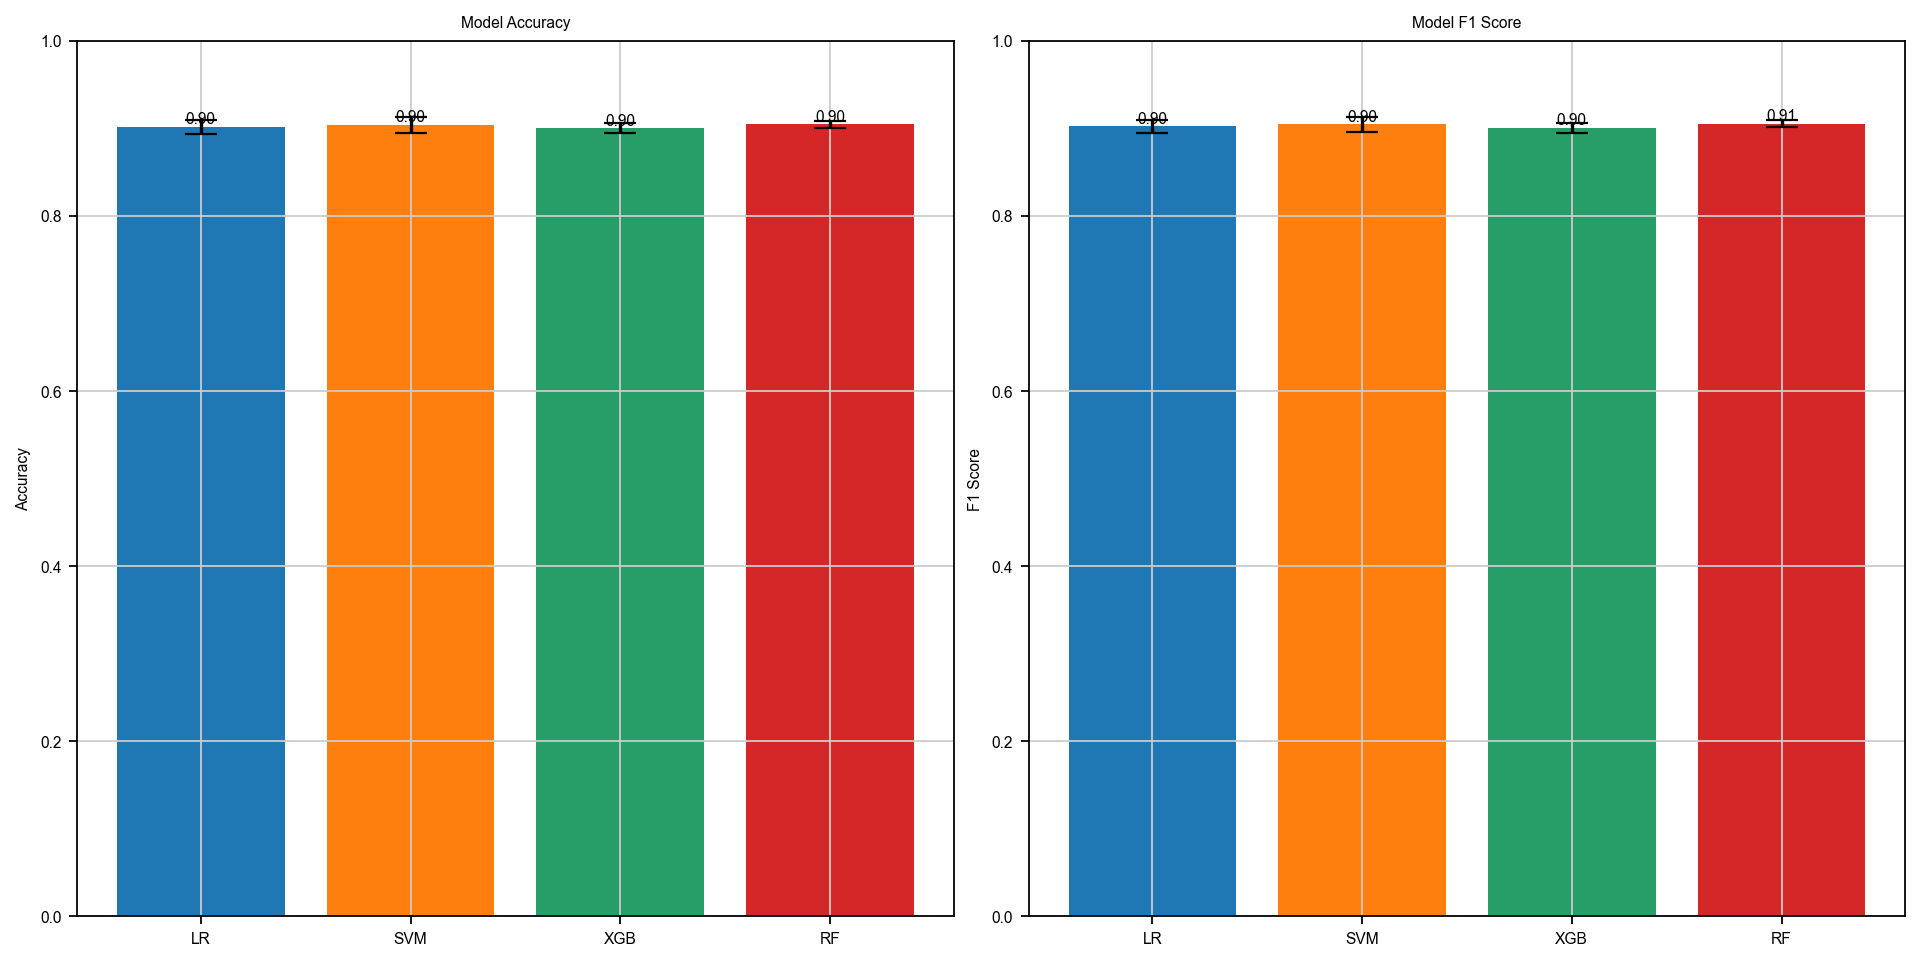

In [23]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# Assuming rbX_train, rbY_train, rbX_test, rbY_test are your data


# Your models
models = [
    ('LR', Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000, random_state=551))])),
    ('SVM', Pipeline([('scaler', StandardScaler()), ('model', SVC(kernel='linear', probability=True, random_state=551))])),
    ('XGB', Pipeline([('scaler', StandardScaler()), ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, learning_rate=0.05, max_depth=10,random_state=551))])),
    ('RF', Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier(max_depth=10, random_state=41))]))
]

scores = {name: {'accuracy': [], 'f1': []} for name, _ in models}

# 5-Fold Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=551)

for name, model in models:
    # Change 'f1_macro' to 'f1_weighted' for multi-class scenario with consideration for class imbalance
    cv_results = cross_validate(model, full_X_train, full_Y_train, cv=cv, scoring=['accuracy', 'f1_weighted'])  
    
    scores[name]['accuracy'] = cv_results['test_accuracy']
    scores[name]['f1'] = cv_results['test_f1_weighted']

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Accuracy Plot
for i, name in enumerate(scores.keys()):
    mean_accuracy = np.mean(scores[name]['accuracy'])
    std_accuracy = np.std(scores[name]['accuracy'])
    bar = ax[0].bar(name, mean_accuracy, yerr=std_accuracy, capsize=7)
    ax[0].text(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height(), f'{mean_accuracy:.2f}', ha='center', va='bottom', fontsize=7)
ax[0].set_title('Model Accuracy', fontsize=7)
ax[0].set_ylabel('Accuracy', fontsize=7)
ax[0].tick_params(axis='both', which='major', labelsize=7)
ax[0].set_ylim([0, 1])

# F1 Score Plot
for i, name in enumerate(scores.keys()):
    mean_f1 = np.mean(scores[name]['f1'])
    std_f1 = np.std(scores[name]['f1'])
    bar = ax[1].bar(name, mean_f1, yerr=std_f1, capsize=7)
    ax[1].text(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height(), f'{mean_f1:.2f}', ha='center', va='bottom', fontsize=7)
ax[1].set_title('Model F1 Score', fontsize=7)
ax[1].set_ylabel('F1 Score', fontsize=7)
ax[1].tick_params(axis='both', which='major', labelsize=7)
ax[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [22:37:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


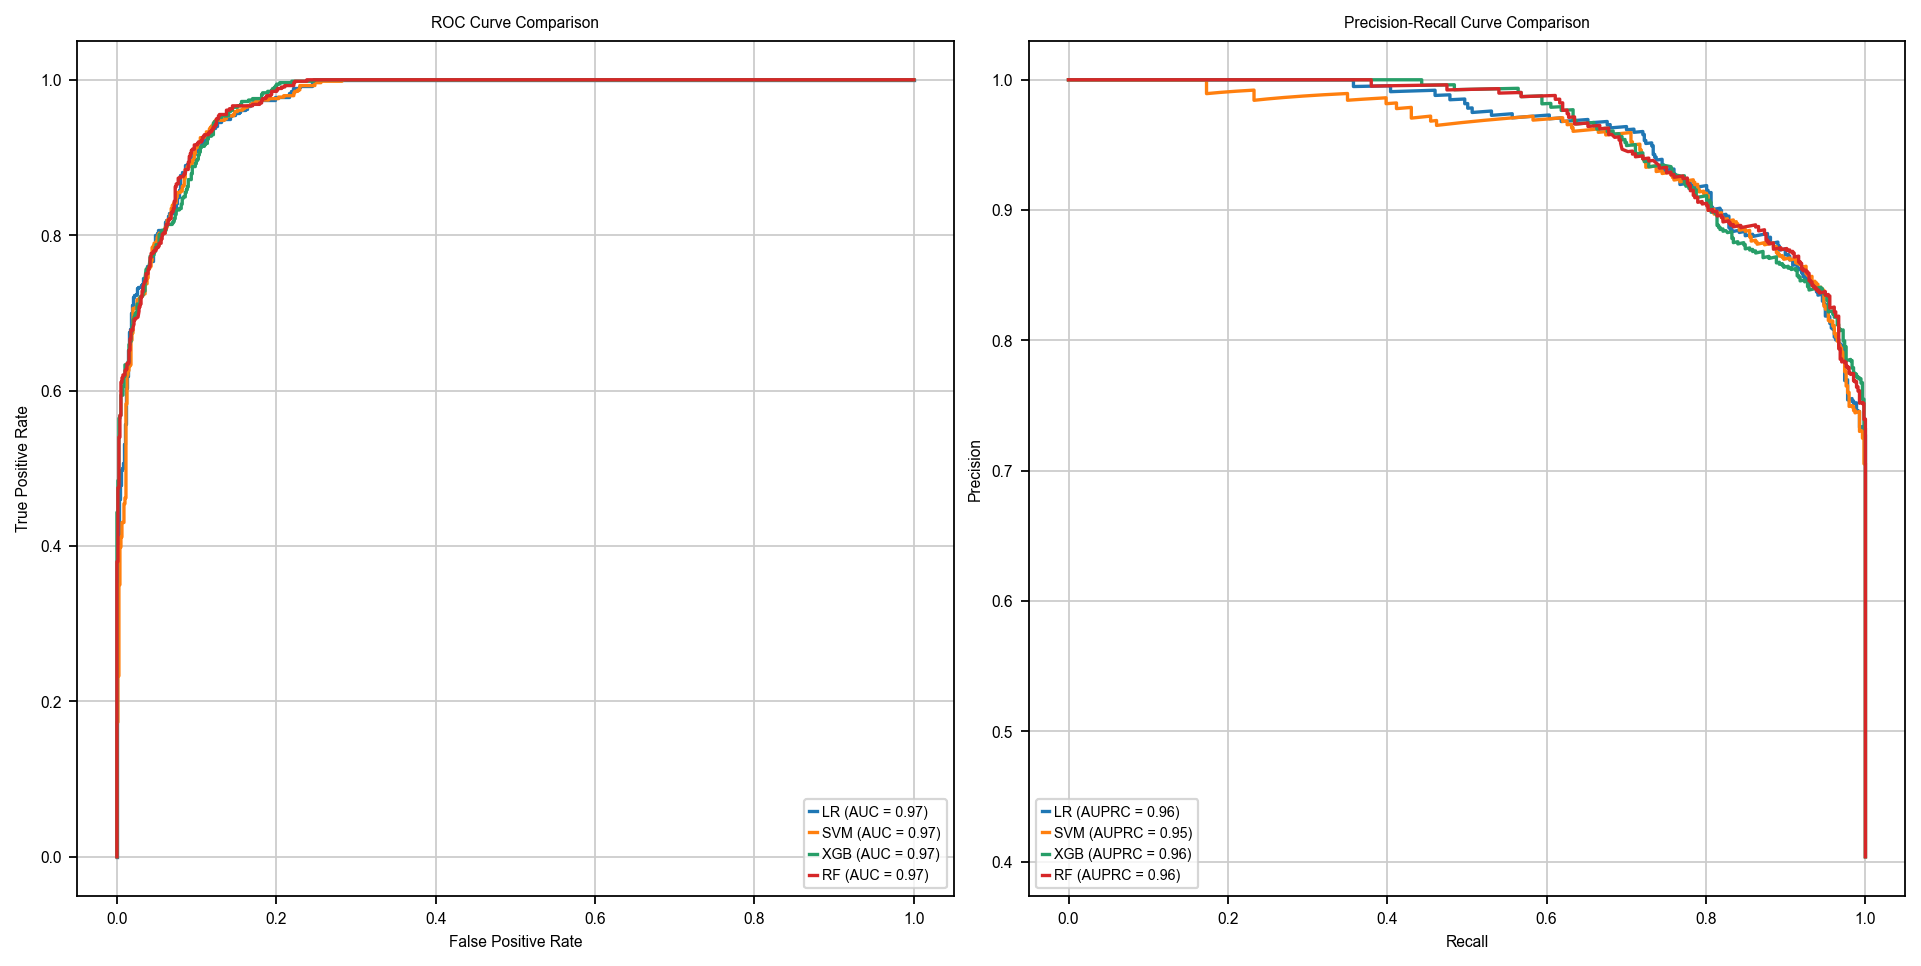

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Set global font properties
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 7
rcParams['font.weight'] = 'normal'

 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_X_train, full_Y_train, test_size=0.2, random_state=551, stratify=full_Y_train)

# Your models
models = [
    ('LR', Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000, random_state=551))])),
    ('SVM', Pipeline([('scaler', StandardScaler()), ('model', SVC(kernel='linear', probability=True, random_state=551))])),
    ('XGB', Pipeline([('scaler', StandardScaler()), ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, learning_rate=0.05, max_depth=10,random_state=551))])),
    ('RF', Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier(max_depth=10, random_state=41))]))
]

# DataFrames to store all ROC and PRC data
roc_data_list = []
prc_data_list = []

# Plot settings
plt.figure(figsize=(12, 6))
roc_ax = plt.subplot(1, 2, 1)
prc_ax = plt.subplot(1, 2, 2)

for name, model in models:
    # Fit the model on the full training data
    model.fit(X_train, y_train)
    
    # Predict probabilities on the test set
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    roc_ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    # Save ROC data
    roc_data_list.append(pd.DataFrame({'Model': name, 'fpr': fpr, 'tpr': tpr}))
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    prc_ax.plot(recall, precision, label=f'{name} (AUPRC = {pr_auc:.2f})')
    
    # Save PRC data
    prc_data_list.append(pd.DataFrame({'Model': name, 'precision': precision, 'recall': recall}))

# ROC Axis labels
roc_ax.set_title('ROC Curve Comparison')
roc_ax.set_xlabel('False Positive Rate')
roc_ax.set_ylabel('True Positive Rate')
roc_ax.legend(loc="lower right")

# PRC Axis labels
prc_ax.set_title('Precision-Recall Curve Comparison')
prc_ax.set_xlabel('Recall')
prc_ax.set_ylabel('Precision')
prc_ax.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Combine all ROC and PRC data and save to CSV files
roc_data = pd.concat(roc_data_list, ignore_index=True)
prc_data = pd.concat(prc_data_list, ignore_index=True)

roc_data.to_csv('auroc_data.csv', index=False)
prc_data.to_csv('prc_data.csv', index=False)


LR: AUROC = 0.9709469027172113, AUPRC = 0.9563773550473652
SVM: AUROC = 0.9690353911436429, AUPRC = 0.9504561307883769
XGB: AUROC = 0.9716748739553026, AUPRC = 0.9581866907031735


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RF: AUROC = 0.9722713407116741, AUPRC = 0.9588089406030349


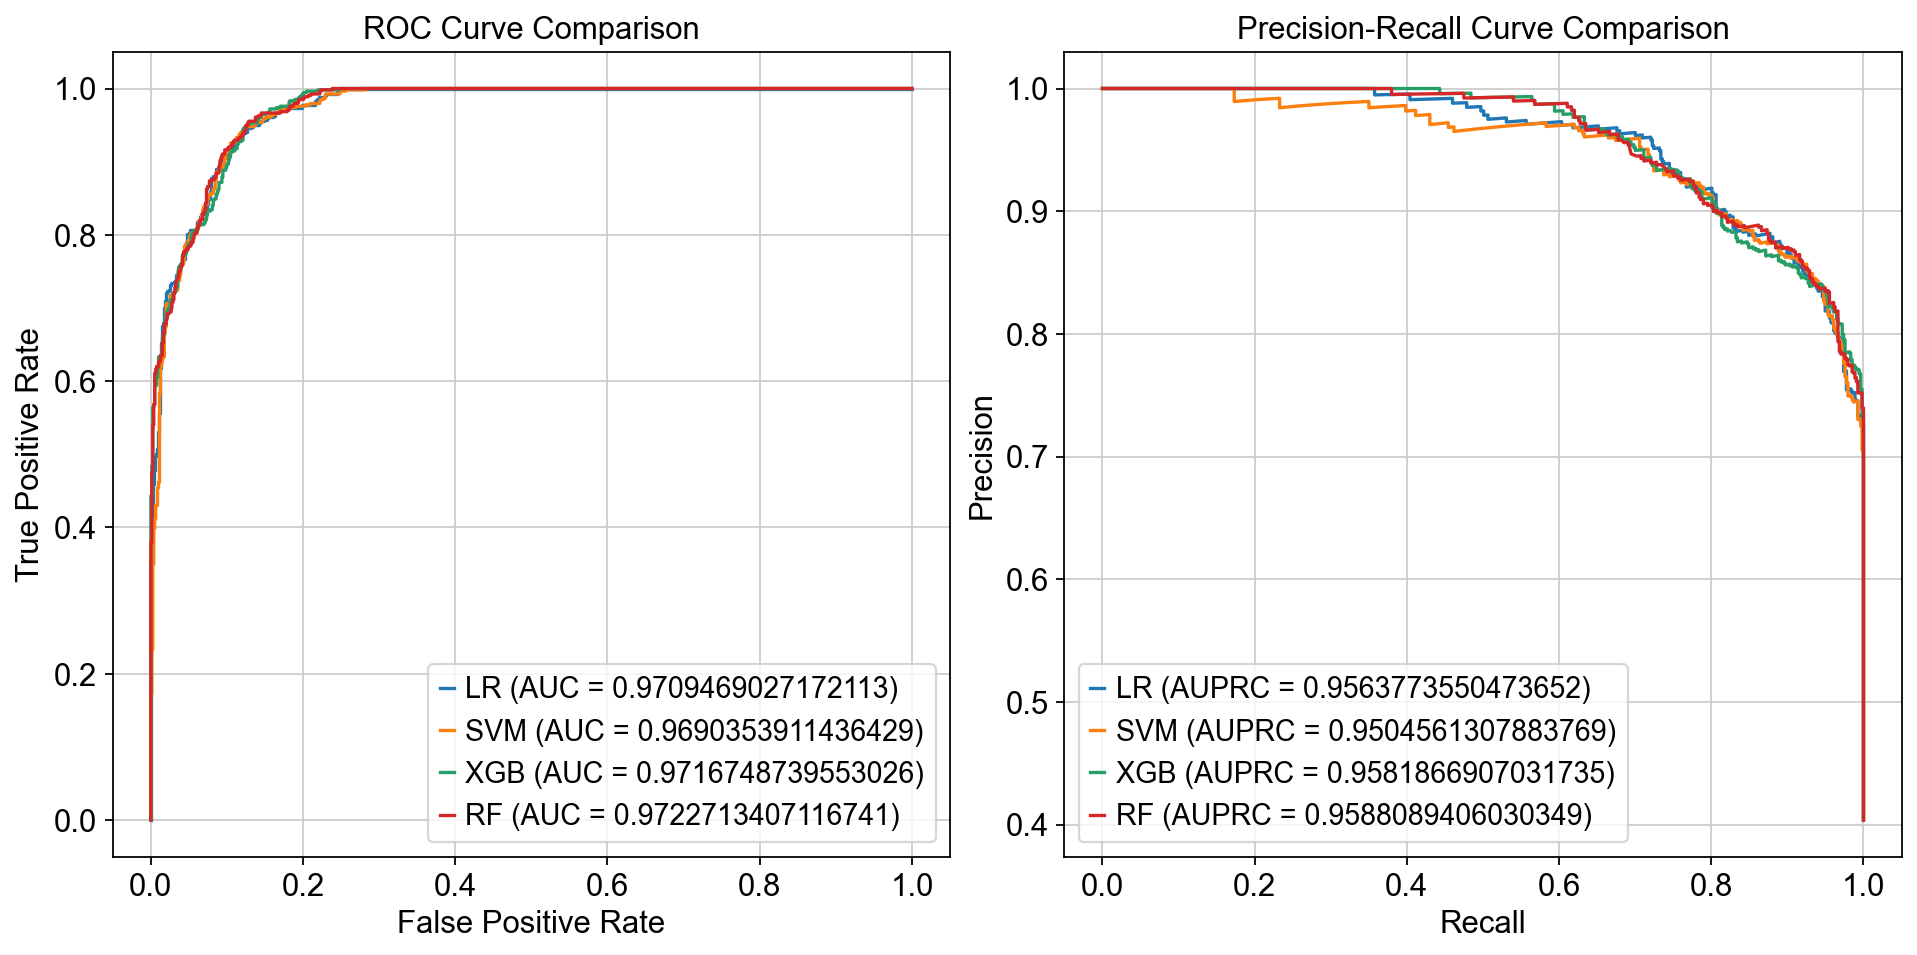


Metrics Summary:
  Model  AUROC  AUPRC
0    LR  0.971  0.956
1   SVM  0.969  0.950
2   XGB  0.972  0.958
3    RF  0.972  0.959


In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Set global font properties
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 7
rcParams['font.weight'] = 'normal'

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_X_train, full_Y_train, test_size=0.2, random_state=551, stratify=full_Y_train)

# Your models
models = [
    ('LR', Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000, random_state=551))])),
    ('SVM', Pipeline([('scaler', StandardScaler()), ('model', SVC(kernel='linear', probability=True, random_state=551))])),
    ('XGB', Pipeline([('scaler', StandardScaler()), ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, learning_rate=0.05, max_depth=10,random_state=551))])),
    ('RF', Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier(max_depth=10, random_state=41))]))
]

# DataFrames to store all ROC and PRC data
roc_data_list = []
prc_data_list = []

# Dictionary to store metrics for printing
metrics_dict = {}

# Plot settings
plt.figure(figsize=(12, 6))
roc_ax = plt.subplot(1, 2, 1)
prc_ax = plt.subplot(1, 2, 2)

for name, model in models:
    # Fit the model on the full training data
    model.fit(X_train, y_train)
    
    # Predict probabilities on the test set
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    roc_ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc})')
    
    # Save ROC data
    roc_data_list.append(pd.DataFrame({'Model': name, 'fpr': fpr, 'tpr': tpr}))
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    prc_ax.plot(recall, precision, label=f'{name} (AUPRC = {pr_auc})')
    
    # Save PRC data
    prc_data_list.append(pd.DataFrame({'Model': name, 'precision': precision, 'recall': recall}))
    
    # Store metrics for printing
    metrics_dict[name] = {'AUROC': roc_auc, 'AUPRC': pr_auc}
    
    # Print metrics with full precision
    print(f'{name}: AUROC = {roc_auc}, AUPRC = {pr_auc}')

# ROC Axis labels
roc_ax.set_title('ROC Curve Comparison')
roc_ax.set_xlabel('False Positive Rate')
roc_ax.set_ylabel('True Positive Rate')
roc_ax.legend(loc="lower right")

# PRC Axis labels
prc_ax.set_title('Precision-Recall Curve Comparison')
prc_ax.set_xlabel('Recall')
prc_ax.set_ylabel('Precision')
prc_ax.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Combine all ROC and PRC data and save to CSV files
roc_data = pd.concat(roc_data_list, ignore_index=True)
prc_data = pd.concat(prc_data_list, ignore_index=True)

roc_data.to_csv('auroc_data.csv', index=False)
prc_data.to_csv('prc_data.csv', index=False)

# Save metrics to CSV with full precision
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').reset_index()
metrics_df.columns = ['Model', 'AUROC', 'AUPRC']
metrics_df.to_csv('model_metrics_full_precision.csv', index=False)

print("\nMetrics Summary:")
print(metrics_df)

/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [22:37:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


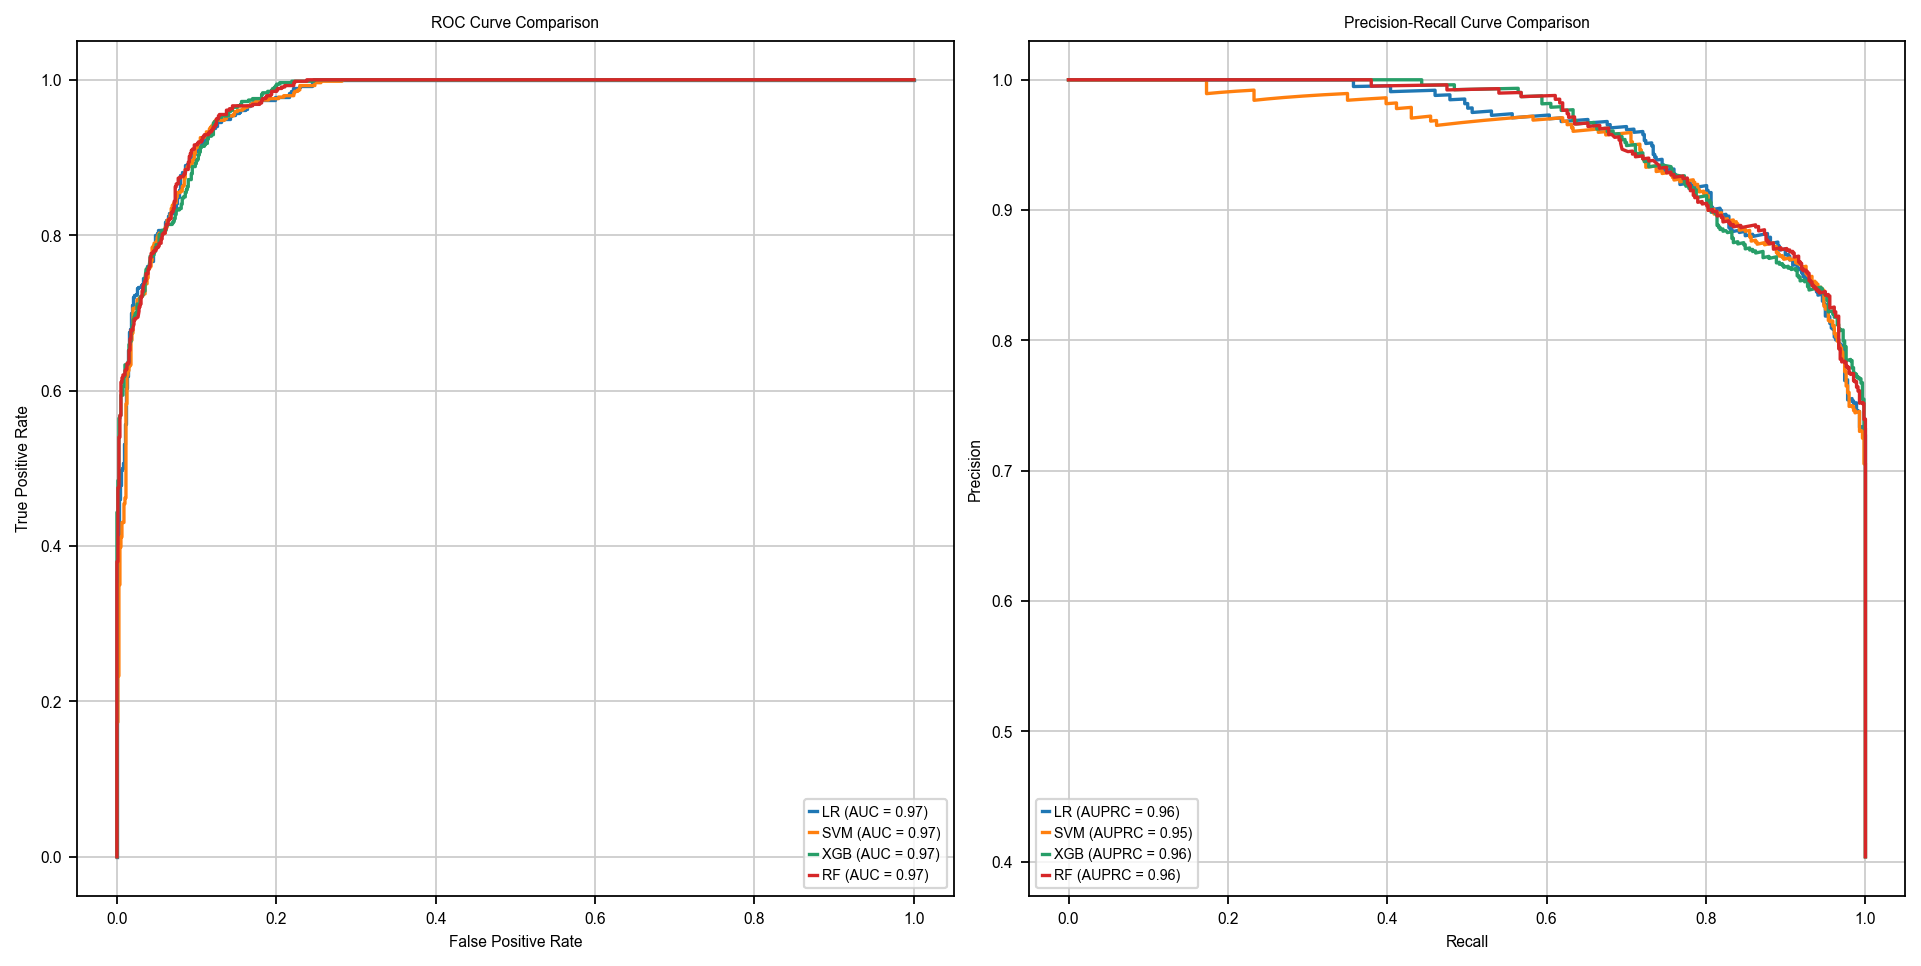

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Set global font properties
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 7
rcParams['font.weight'] = 'normal'

 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_X_train, full_Y_train, test_size=0.2, random_state=551, stratify=  full_Y_train)

# Your models
models = [
    ('LR', Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000, random_state=551))])),
    ('SVM', Pipeline([('scaler', StandardScaler()), ('model', SVC(kernel='linear', probability=True, random_state=551))])),
    ('XGB', Pipeline([('scaler', StandardScaler()), ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, learning_rate=0.05, max_depth=10,random_state=551))])),
    ('RF', Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier(max_depth=10, random_state=41))]))
]

# Plot settings
plt.figure(figsize=(12, 6))
roc_ax = plt.subplot(1, 2, 1)
prc_ax = plt.subplot(1, 2, 2)

for name, model in models:
    # Fit the model on the full training data
    model.fit(X_train, y_train)
    
    # Predict probabilities on the test set
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    roc_ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    prc_ax.plot(recall, precision, label=f'{name} (AUPRC = {pr_auc:.2f})')

# ROC Axis labels
roc_ax.set_title('ROC Curve Comparison')
roc_ax.set_xlabel('False Positive Rate')
roc_ax.set_ylabel('True Positive Rate')
roc_ax.legend(loc="lower right")

# PRC Axis labels
prc_ax.set_title('Precision-Recall Curve Comparison')
prc_ax.set_xlabel('Recall')
prc_ax.set_ylabel('Precision')
prc_ax.legend(loc="lower left")

plt.tight_layout()
plt.show()


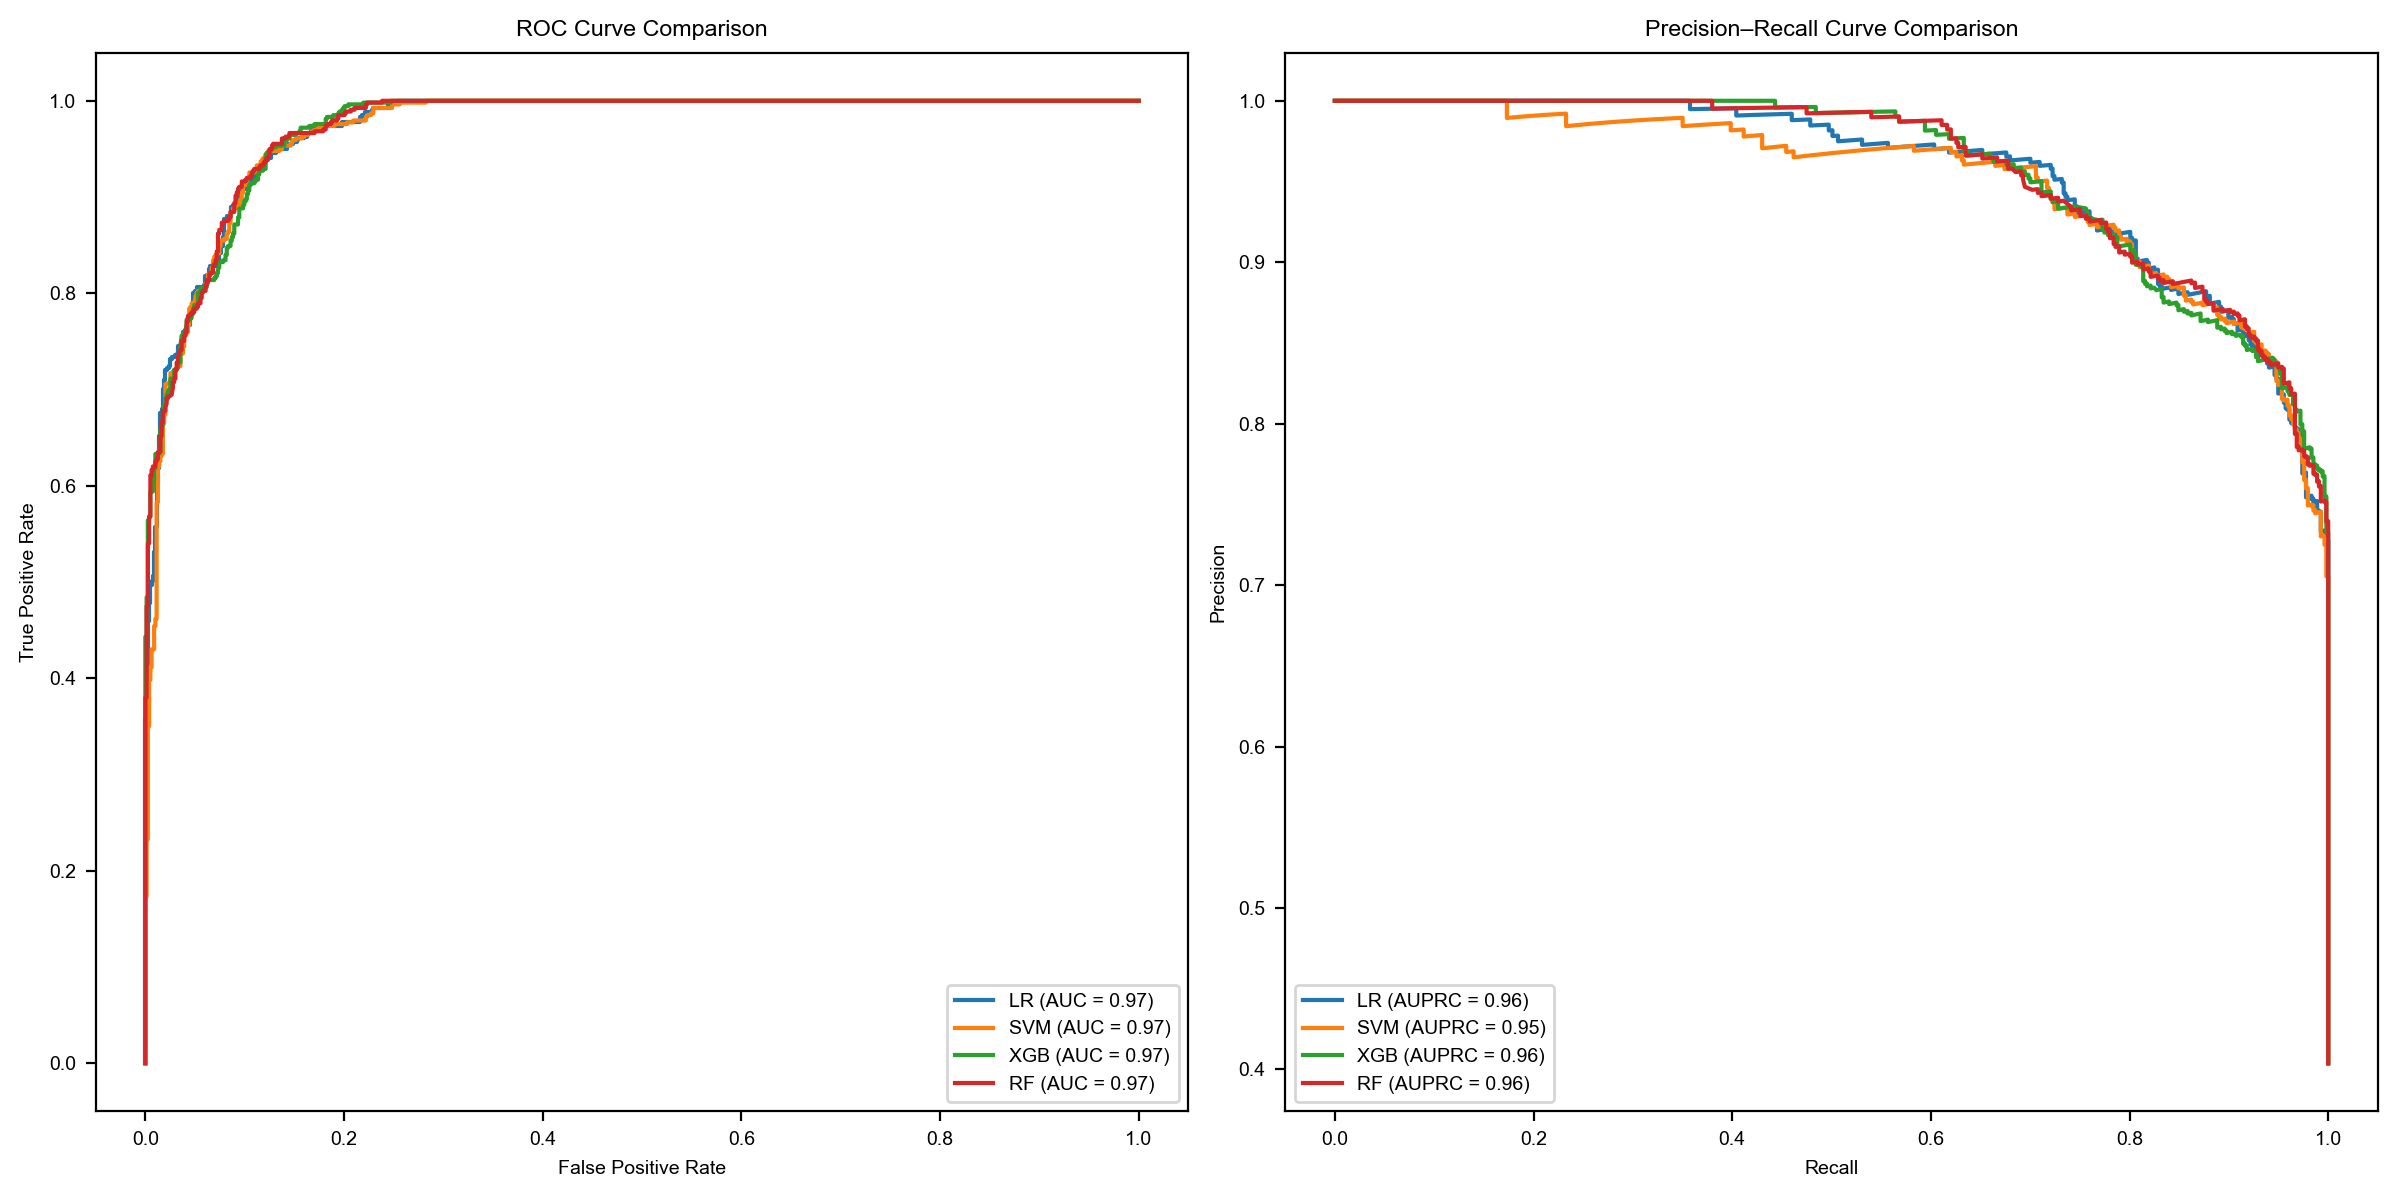

Saved full ROC & PR curve coordinates to /Users/haley/Desktop/send_tooo/AAA_final/fig3_curve_points


In [86]:
# Jupyter-friendly notebook cell
# ——————————————————————————————————————————————————————————
# Train four classifiers, draw ROC & PR curves, **and**
# save every (x, y) point used to construct the curves
# ——————————————————————————————————————————————————————————

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# ─── global matplotlib settings ────────────────────────────
rcParams["font.family"] = "Arial"
rcParams["font.size"]   = 7
rcParams["font.weight"] = "normal"

# ─── data split ────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    full_X_train, full_Y_train,
    test_size   = 0.20,
    random_state= 551,
    stratify    = full_Y_train
)

# ─── model definitions ─────────────────────────────────────
models = [
    ("LR",
     Pipeline([
         ("scaler", StandardScaler()),
         ("model",  LogisticRegression(max_iter=1_000, random_state=551))
     ])),
    ("SVM",
     Pipeline([
         ("scaler", StandardScaler()),
         ("model",  SVC(kernel="linear", probability=True, random_state=551))
     ])),
    ("XGB",
     Pipeline([
         ("scaler", StandardScaler()),
         ("model",  XGBClassifier(
                        use_label_encoder=False,
                        eval_metric="logloss",
                        n_estimators=100,
                        learning_rate=0.05,
                        max_depth=10,
                        random_state=551))
     ])),
    ("RF",
     Pipeline([
         ("scaler", StandardScaler()),
         ("model",  RandomForestClassifier(max_depth=10, random_state=41))
     ]))
]

# ─── containers for saving curve points ────────────────────
roc_points = []   # list of DataFrames
pr_points  = []

# ─── plotting setup ────────────────────────────────────────
fig, (roc_ax, prc_ax) = plt.subplots(1, 2, figsize=(12, 6))

for name, model in models:
    # Fit model
    model.fit(X_train, y_train)

    # Probability predictions
    y_prob = model.predict_proba(X_test)[:, 1]

    # ── ROC ────────────────────────────────────────────────
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc      = roc_auc_score(y_test, y_prob)
    roc_ax.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    # Save ROC points
    roc_points.append(pd.DataFrame({
        "model": name,
        "fpr":   fpr,
        "tpr":   tpr
    }))

    # ── PRC ────────────────────────────────────────────────
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc               = average_precision_score(y_test, y_prob)
    prc_ax.plot(recall, precision, label=f"{name} (AUPRC = {pr_auc:.2f})")

    # Save PR points
    pr_points.append(pd.DataFrame({
        "model":     name,
        "recall":    recall,
        "precision": precision
    }))

# ─── finalise plots ───────────────────────────────────────
roc_ax.set_title("ROC Curve Comparison")
roc_ax.set_xlabel("False Positive Rate")
roc_ax.set_ylabel("True Positive Rate")
roc_ax.legend(loc="lower right")

prc_ax.set_title("Precision–Recall Curve Comparison")
prc_ax.set_xlabel("Recall")
prc_ax.set_ylabel("Precision")
prc_ax.legend(loc="lower left")

plt.tight_layout()
plt.show()

# ─── save curve points to CSV ──────────────────────────────
OUT_DIR = Path("/Users/haley/Desktop/send_tooo/AAA_final/fig3_curve_points")
OUT_DIR.mkdir(exist_ok=True)

pd.concat(roc_points, ignore_index=True).to_csv(OUT_DIR / "roc_curve_points.csv", index=False)
pd.concat(pr_points,  ignore_index=True).to_csv(OUT_DIR / "pr_curve_points.csv",  index=False)

print(f"Saved full ROC & PR curve coordinates to {OUT_DIR.resolve()}")



## 6. Bootstrap Statistical Analysis

### 6.1 Bootstrap Methodology
**Training Data**: full_X_train, full_Y_train (GSM6153750 + GSM6153751 combined dataset)
**Test Data**: realtest, realtest_y (CMO305/CMO306 labeled validation dataset)

**Bootstrap Process**:
- **n=100 bootstrap iterations**
- **Resampling**: Training data (full_X_train) with replacement  
- **Model fitting**: Each bootstrap sample used to train models
- **Evaluation**: All bootstrap models tested on fixed test data (realtest)

### 6.2 Statistical Confidence Intervals
**Output**: 95% confidence intervals for AUROC and AUPRC
- **Training**: Bootstrap resampled GSM datasets
- **Testing**: Fixed CMO-labeled validation data
- **Models**: Logistic Regression, SVM, XGBoost, Random Forest

In [56]:
#!/usr/bin/env python3
"""Bootstrapped evaluation of four classical classifiers on binary labels.

Inputs (must be pre‑loaded in the Python session):
    - full_X_train : pandas DataFrame, shape (n_samples, n_features)
    - full_Y_train : pandas Series or 1‑D array of length n_samples
    - realtest     : pandas DataFrame, shape (n_test_samples, n_features)
    - realtest_y   : pandas Series or 1‑D array of length n_test_samples

Outputs (saved in the working directory):
    - bootstrap_roc_auc.csv  — mean AUROC + 95 % CI for each model
    - bootstrap_prc_auc.csv — mean AUPRC + 95 % CI for each model

Each CSV has three rows (mean, lower CI, upper CI) and one column per model.
"""

from __future__ import annotations

import warnings
from pathlib import Path
from typing import Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # noqa: F401  – left here if you later add plots
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# -----------------------------------------------------------------------------
# Global configuration
# -----------------------------------------------------------------------------

N_BOOTSTRAPS: int = 100
RANDOM_SEED: int = 551
OUTPUT_DIR: Path = Path("/Users/haley/Desktop/send_tooo/AAA_final/fig4")  # Change this if you want the CSVs elsewhere

# Matplotlib defaults – handy if you decide to visualise later
rcParams.update({
    "font.family": "Arial",
    "font.size": 7,
    "font.weight": "normal",
})

# Silence XGBoost warnings that clutter the console
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# -----------------------------------------------------------------------------
# Utility functions
# -----------------------------------------------------------------------------

def bootstrap_metrics(
    model,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    n_bootstraps: int = N_BOOTSTRAPS,
    seed: int = RANDOM_SEED,
) -> Tuple[Tuple[float, float, float], Tuple[float, float, float]]:
    """Compute bootstrapped AUROC and AUPRC for *model*.

    Returns
    -------
    roc_stats : (mean, lower_ci, upper_ci)
    prc_stats : (mean, lower_ci, upper_ci)
    """

    rng = np.random.default_rng(seed)
    roc_scores: List[float] = []
    prc_scores: List[float] = []

    for _ in range(n_bootstraps):
        # Sample with replacement from the training set
        resample_idx = rng.choice(len(X_train), size=len(X_train), replace=True)

        X_resampled = X_train.iloc[resample_idx]
        y_resampled = y_train.iloc[resample_idx]

        # Standardise per‑bootstrap to avoid information leakage
        scaler = StandardScaler()
        X_resampled_scaled = scaler.fit_transform(X_resampled)
        X_test_scaled = scaler.transform(X_test)

        # Fit and predict
        model.fit(X_resampled_scaled, y_resampled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]

        roc_scores.append(roc_auc_score(y_test, y_prob))
        prc_scores.append(average_precision_score(y_test, y_prob))

    roc_arr = np.asarray(roc_scores)
    prc_arr = np.asarray(prc_scores)

    roc_stats = (
        float(roc_arr.mean()),
        float(np.percentile(roc_arr, 2.5)),
        float(np.percentile(roc_arr, 97.5)),
    )
    prc_stats = (
        float(prc_arr.mean()),
        float(np.percentile(prc_arr, 2.5)),
        float(np.percentile(prc_arr, 97.5)),
    )
    return roc_stats, prc_stats

# -----------------------------------------------------------------------------
# Main evaluation pipeline
# -----------------------------------------------------------------------------

def main() -> None:
    """Run bootstrap evaluation and save CSV summaries."""

    # These variables must already be defined elsewhere (e.g. notebook or import)
    try:
        global full_X_train, full_Y_train, realtest, realtest_y  # type: ignore
    except NameError as exc:
        raise RuntimeError(
            "full_X_train, full_Y_train, realtest, realtest_y need to be in scope "
            "before running this script."
        ) from exc

    models = [
        LogisticRegression(max_iter=1000, n_jobs=-1, random_state=RANDOM_SEED),
        SVC(kernel="linear", probability=True, random_state=RANDOM_SEED),
        XGBClassifier(
            random_state=RANDOM_SEED,
            use_label_encoder=False,
            eval_metric="logloss",
            n_estimators=100,
            learning_rate=0.05,
            max_depth=10,
        ),
        RandomForestClassifier(max_depth=10, random_state=RANDOM_SEED),
    ]

    roc_results = {}
    prc_results = {}

    for clf in models:
        roc_stats, prc_stats = bootstrap_metrics(
            clf, full_X_train, full_Y_train, realtest, realtest_y
        )
        name = clf.__class__.__name__
        roc_results[name] = roc_stats
        prc_results[name] = prc_stats
        print(f"{name:>22}: AUROC={roc_stats[0]:.3f}  AUPRC={prc_stats[0]:.3f}")

    # Save to CSV
    roc_df = pd.DataFrame(roc_results, index=["Mean AUROC", "Lower CI", "Upper CI"]).T
    prc_df = pd.DataFrame(prc_results, index=["Mean AUPRC", "Lower CI", "Upper CI"]).T

    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    roc_df.to_csv(OUTPUT_DIR / "bootstrap_roc_auc.csv", index_label="Model")
    prc_df.to_csv(OUTPUT_DIR / "bootstrap_prc_auc.csv", index_label="Model")

    print("\nSaved bootstrap_roc_auc.csv and bootstrap_prc_auc.csv to", OUTPUT_DIR.resolve())


if __name__ == "__main__":
    main()


    LogisticRegression: AUROC=0.833  AUPRC=0.960
                   SVC: AUROC=0.822  AUPRC=0.956
         XGBClassifier: AUROC=0.833  AUPRC=0.958
RandomForestClassifier: AUROC=0.834  AUPRC=0.958

Saved bootstrap_roc_auc.csv and bootstrap_prc_auc.csv to /Users/haley/Desktop/send_tooo/AAA_final/fig4


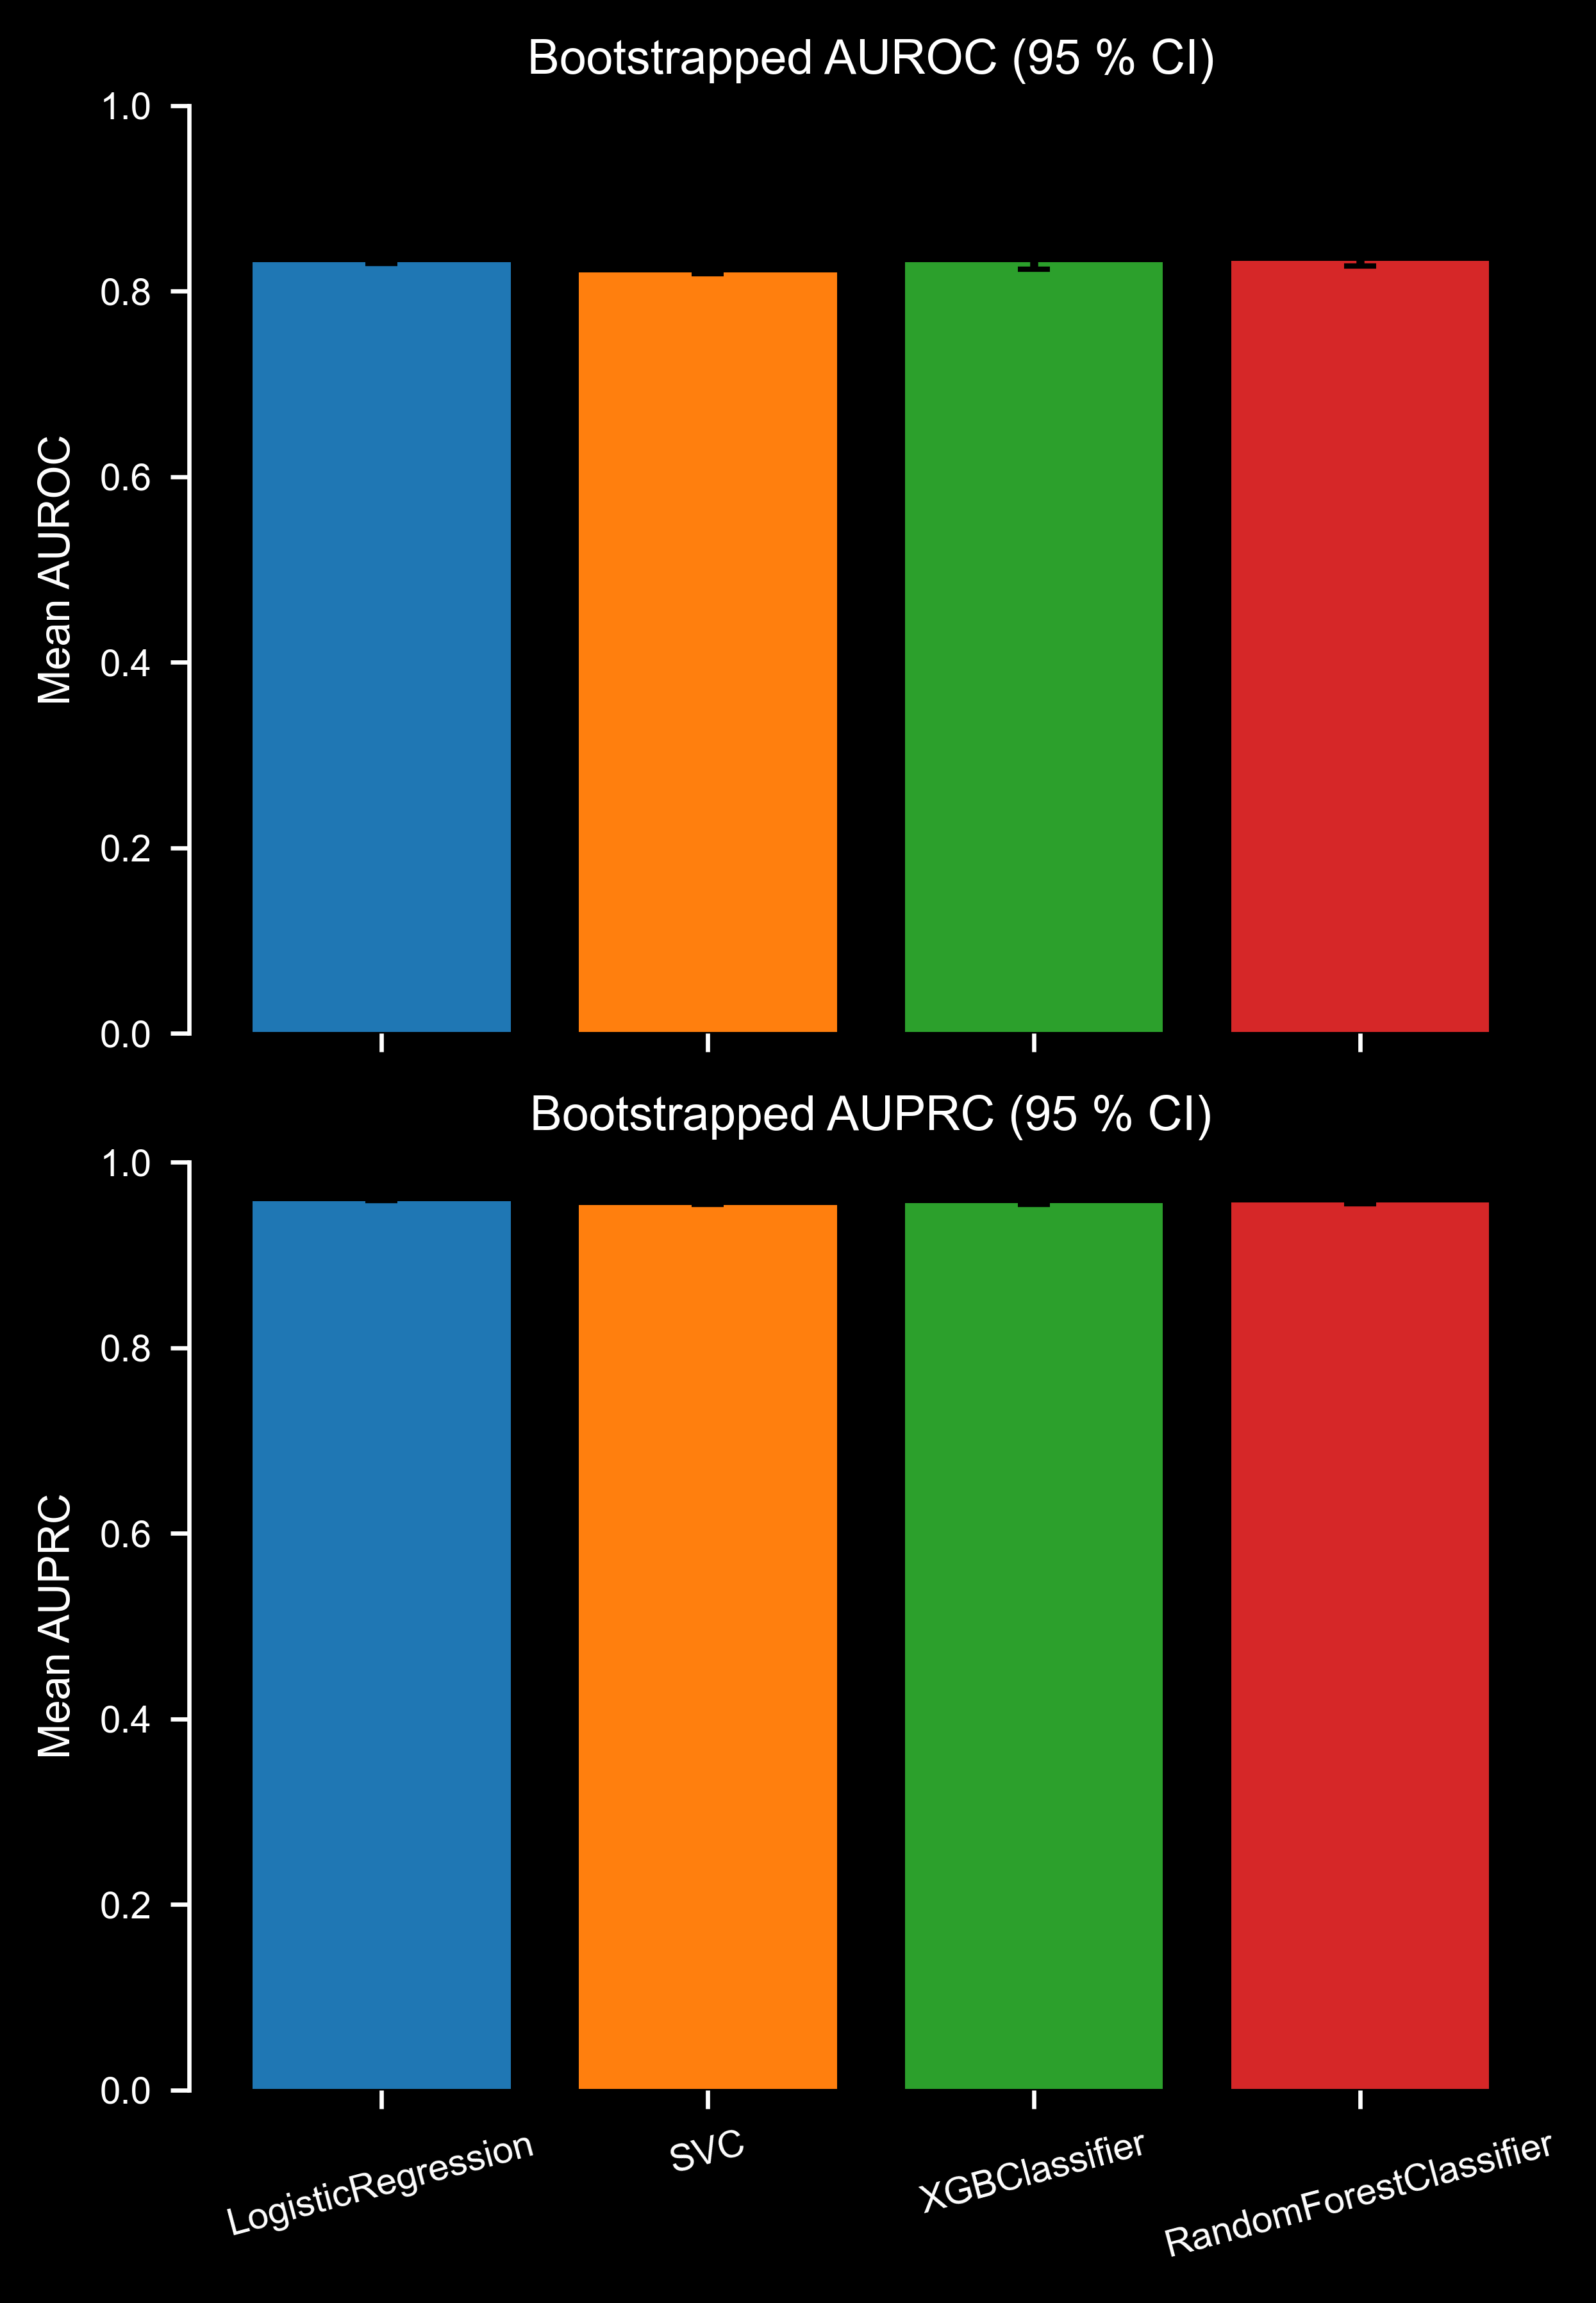

In [58]:
#!/usr/bin/env python3
"""
Bar plots of AUROC and AUPRC (mean ± 95 % CI) on a **white** background.
X-axis baseline and dashed y-axis grid are removed.
"""

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ── 1.  Read results ───────────────────────────────────────────────
roc_df = pd.read_csv(Path("bootstrap_roc_auc.csv"), index_col="Model")
prc_df = pd.read_csv(Path("bootstrap_prc_auc.csv"), index_col="Model")

models = roc_df.index.tolist()
prc_df = prc_df.loc[models]  # ensure same order

def extract(df, col):
    mean = df[col].values
    err  = [mean - df["Lower CI"].values,
            df["Upper CI"].values - mean]
    return mean, err

roc_mean, roc_err = extract(roc_df, "Mean AUROC")
prc_mean, prc_err = extract(prc_df, "Mean AUPRC")

# ── 2.  Plotting setup ─────────────────────────────────────────────
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]   # blue, orange, green, red

fig, axes = plt.subplots(2, 1, figsize=(4.2, 6), dpi=300, sharex=True)

# Helper to style each subplot
def style_axis(ax, ylabel, title, means, yerr):
    ax.bar(models, means, yerr=yerr, capsize=3,
           color=colors, edgecolor="black", linewidth=0.6)
    ax.set_ylabel(ylabel, fontsize=8)
    ax.set_title(title, fontsize=9, pad=6)
    ax.set_ylim(0, 1)
    # Remove x-axis baseline and any grid lines
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # No grid
    ax.grid(False)

style_axis(axes[0], "Mean AUROC", "Bootstrapped AUROC (95 % CI)", roc_mean, roc_err)
style_axis(axes[1], "Mean AUPRC", "Bootstrapped AUPRC (95 % CI)", prc_mean, prc_err)

plt.xticks(rotation=15, ha="center", fontsize=7)
plt.tight_layout()
plt.show()


In [33]:
 
# Optional: Print results
print("ROC AUC Data:")
print(roc_auc_df)
print("\nPRC AUC Data:")
print(prc_auc_df)

ROC AUC Data:
                        Mean AUROC  Lower CI  Upper CI
LogisticRegression        0.833158  0.829910  0.835949
SVC                       0.822421  0.818697  0.826163
XGBClassifier             0.833681  0.824071  0.843689
RandomForestClassifier    0.835185  0.827522  0.844919

PRC AUC Data:
                        Mean AUPRC  Lower CI  Upper CI
LogisticRegression        0.959903  0.958873  0.960731
SVC                       0.956253  0.954741  0.957541
XGBClassifier             0.957919  0.954751  0.961573
RandomForestClassifier    0.958576  0.955422  0.961641


In [55]:
full_X_train 

n,Xist,Ddx3y,Gm42418,Eif2s3y,Rps27rt,Rpl9-ps6,Kdm5d,Uba52,Rpl35,Rpl36a-ps1,Uty,Wdr89,Lars2,Rps27
Cell_1678,0.000000,0.000000,4.045352,0.0,1.671058,0.000000,0.0,2.265462,2.265462,0.000000,0.0,0.000000,1.671058,0.000000
Cell_3705,4.309744,0.000000,4.642370,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
Cell_5187,3.324866,0.000000,4.331086,0.0,2.201503,1.849880,0.0,1.302785,2.837743,0.000000,0.0,0.000000,0.000000,1.302785
Cell_1921,0.000000,1.265771,3.899357,0.0,1.265771,1.806919,0.0,1.806919,2.789627,1.265771,0.0,1.265771,1.265771,1.806919
Cell_1575,0.000000,0.000000,4.420726,0.0,3.798758,2.797547,0.0,2.627344,3.537362,2.163574,0.0,1.271835,1.813976,1.813976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_2934,2.839474,0.000000,3.502957,0.0,2.695019,1.194215,0.0,0.000000,2.965672,1.723112,0.0,0.000000,1.194215,2.526115
Cell_2191,0.000000,0.000000,4.309315,0.0,1.313221,0.000000,0.0,1.313221,2.214233,1.313221,0.0,0.000000,2.214233,1.313221
Cell_6618,3.282452,0.000000,4.087791,0.0,2.119384,1.539660,0.0,0.000000,2.960883,0.000000,0.0,0.000000,1.539660,1.539660
Cell_318,0.000000,0.000000,4.049656,0.0,3.767767,0.000000,0.0,0.000000,3.373787,0.000000,0.0,0.000000,0.000000,0.000000


In [51]:
scaler = StandardScaler()
full_X_train_scaled=scaler.fit_transform(full_X_train)
realtest_scaled=scaler.transform(realtest)

## 7. Model Performance on Independent Test Data

### 7.1 Training-Test Data Specification
**Training Data**: 
- **Source**: full_X_train, full_Y_train  
- **Origin**: Combined GSM6153750 (male) + GSM6153751 (female)
- **Size**: 6,648 total cells (2,685 male + 3,963 female)

**Test Data**:
- **Source**: realtest, realtest_y
- **Origin**: CMO-labeled experimental dataset  
- **Labels**: CMO305 → Male (1), CMO306 → Female (0)
- **Features**: Same 14-gene panel extracted

### 7.2 Final Performance Metrics
**Training Protocol**: Models trained on full GSM training data
**Evaluation Protocol**: Performance assessed on independent CMO test data

**Results Include**:
- ROC curves: Complete FPR/TPR coordinates
- Precision-Recall curves: Complete precision/recall coordinates  
- AUROC and AUPRC values for each model
- Confusion matrices on CMO test data
- Prediction accuracy and class-specific metrics

Training LogisticRegression
Training SVC
Training XGBClassifier
Training RandomForestClassifier
✅  Saved:
   └─ /Users/haley/Desktop/send_tooo/AAA_final/curve_outputs/all_roc_points.csv
   └─ /Users/haley/Desktop/send_tooo/AAA_final/curve_outputs/all_prc_points.csv
   └─ /Users/haley/Desktop/send_tooo/AAA_final/curve_outputs/roc_auc_summary.csv
   └─ /Users/haley/Desktop/send_tooo/AAA_final/curve_outputs/prc_auc_summary.csv


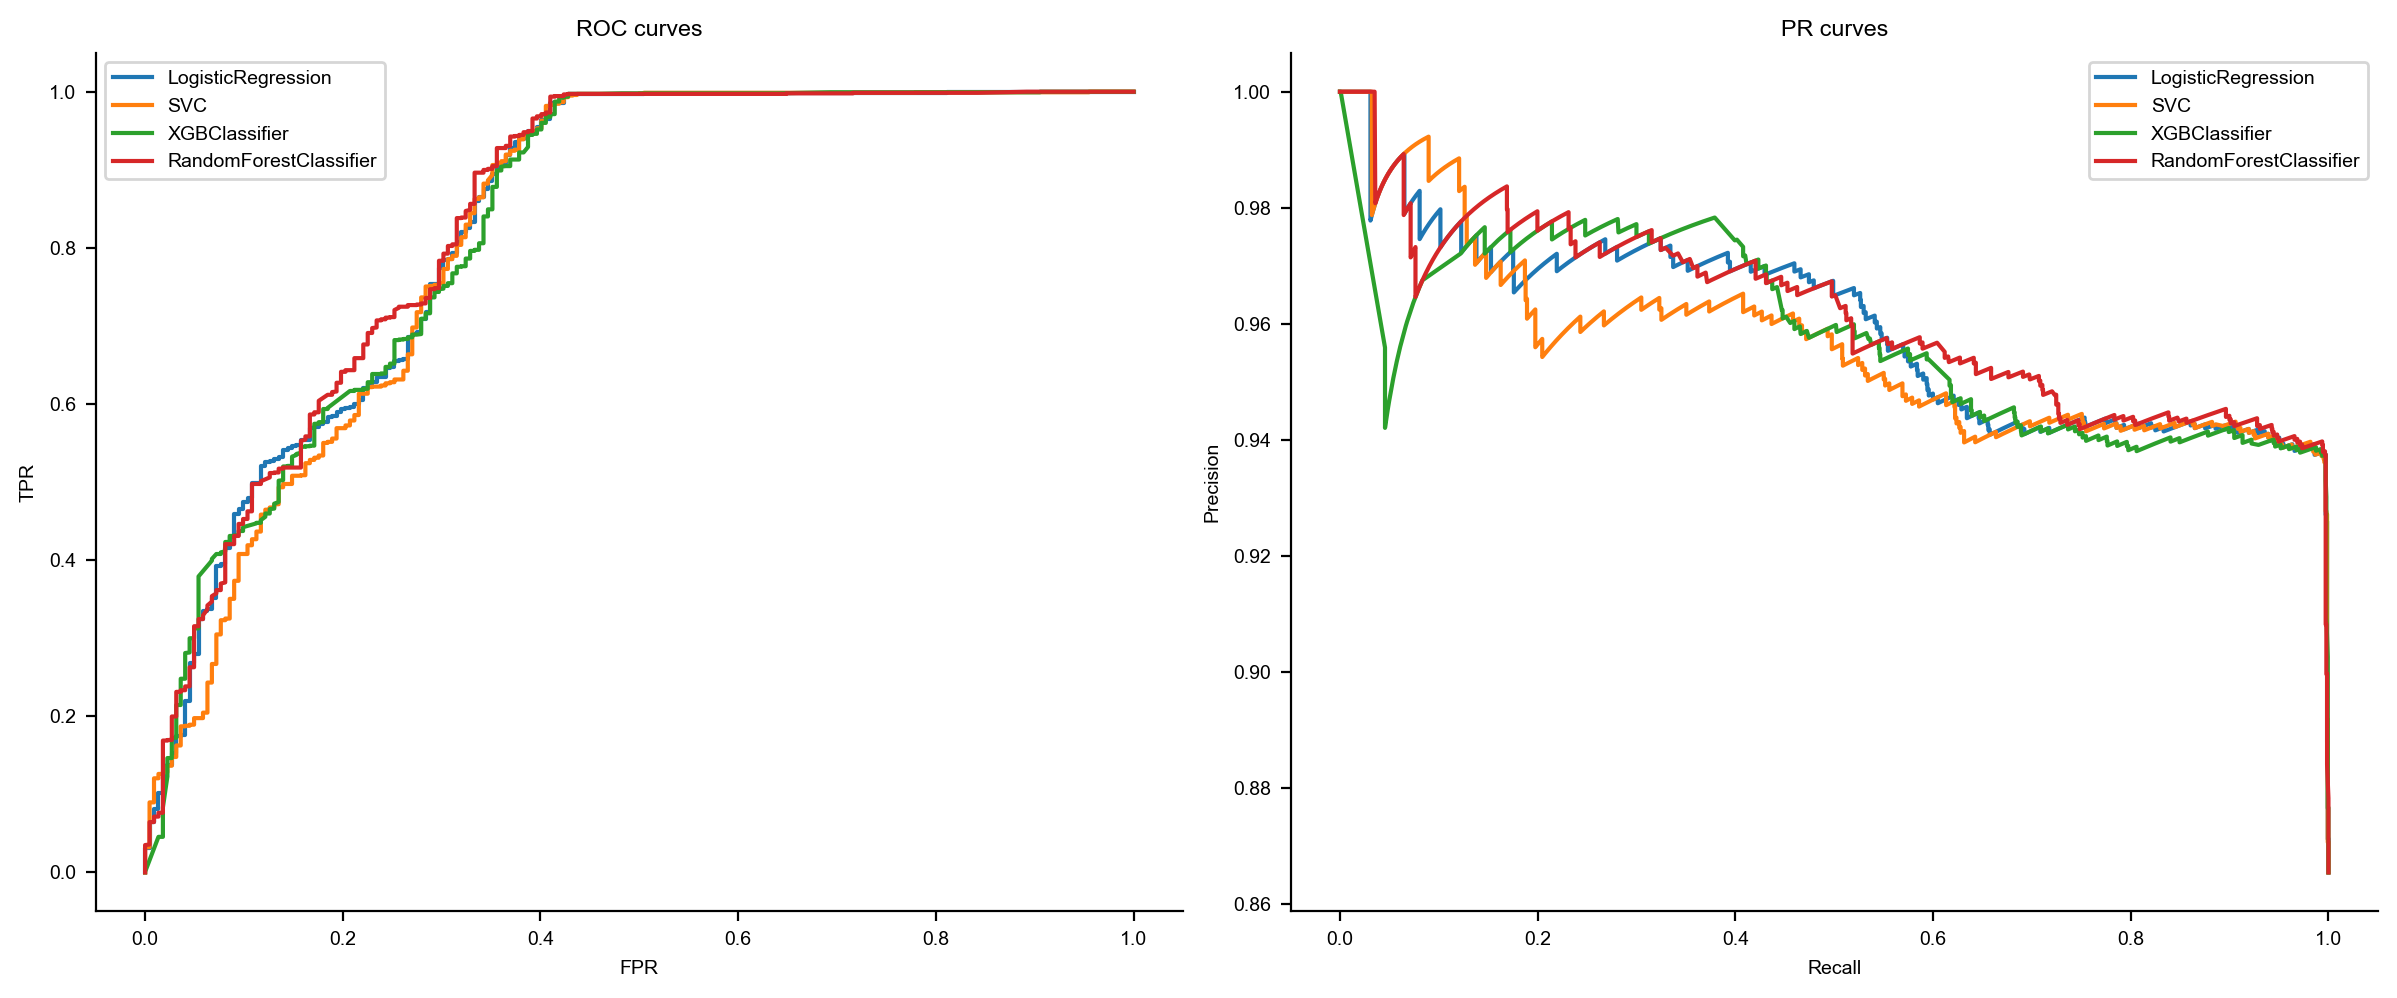

In [81]:
#!/usr/bin/env python3
"""
Save *all* ROC and PR curve points in two master CSVs:

    ├── all_roc_points.csv   # columns: model, fpr, tpr
    └── all_prc_points.csv   # columns: model, recall, precision

It also produces a small summary (AUROC / AUPRC) table.
"""

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier  # pip install xgboost if missing

# ── global config ──────────────────────────────────────────────────────────
rcParams.update({"font.family": "Arial", "font.size": 7})
OUTDIR = Path("/Users/haley/Desktop/send_tooo/AAA_final/curve_outputs")
OUTDIR.mkdir(exist_ok=True)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

models = [
    LogisticRegression(max_iter=1000, random_state=551),
    SVC(kernel="linear", probability=True, random_state=551),
    XGBClassifier(
        random_state=551,
        use_label_encoder=False,
        eval_metric="logloss",
        n_estimators=100,
        learning_rate=0.05,
        max_depth=10,
    ),
    RandomForestClassifier(max_depth=10, random_state=41),
]

# ── scale data once ────────────────────────────────────────────────────────
scaler = StandardScaler()
X_train_s = scaler.fit_transform(full_X_train)
X_test_s  = scaler.transform(realtest)

# ── containers ─────────────────────────────────────────────────────────────
roc_rows, prc_rows = [], []
roc_summary, prc_summary = [], []

# ── fit, predict, collect points ───────────────────────────────────────────
for model in models:
    name = model.__class__.__name__
    print("Training", name)
    model.fit(X_train_s, full_Y_train)
    y_prob = model.predict_proba(X_test_s)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(realtest_y, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_rows.append(pd.DataFrame({"model": name, "fpr": fpr, "tpr": tpr}))
    roc_summary.append({"model": name, "auc": roc_auc})

    # PR
    prec, rec, _ = precision_recall_curve(realtest_y, y_prob)
    pr_auc = average_precision_score(realtest_y, y_prob)
    prc_rows.append(pd.DataFrame({"model": name, "recall": rec, "precision": prec}))
    prc_summary.append({"model": name, "auprc": pr_auc})

# ── write master CSVs ──────────────────────────────────────────────────────
pd.concat(roc_rows, ignore_index=True).to_csv(OUTDIR / "all_roc_points.csv", index=False)
pd.concat(prc_rows, ignore_index=True).to_csv(OUTDIR / "all_prc_points.csv", index=False)

pd.DataFrame(roc_summary).to_csv(OUTDIR / "roc_auc_summary.csv", index=False)
pd.DataFrame(prc_summary).to_csv(OUTDIR / "prc_auc_summary.csv", index=False)

print("✅  Saved:")
for fn in ["all_roc_points.csv", "all_prc_points.csv",
           "roc_auc_summary.csv", "prc_auc_summary.csv"]:
    print("   └─", OUTDIR / fn)

# ── (optional) quick plot from the master CSVs ─────────────────────────────
plt.figure(figsize=(12, 5))
roc_ax = plt.subplot(1, 2, 1)
pr_ax = plt.subplot(1, 2, 2)

roc_pts = pd.read_csv(OUTDIR / "all_roc_points.csv")
prc_pts = pd.read_csv(OUTDIR / "all_prc_points.csv")

for name, color in zip([m.__class__.__name__ for m in models], colors):
    roc_sub = roc_pts[roc_pts.model == name]
    prc_sub = prc_pts[prc_pts.model == name]

    roc_ax.plot(roc_sub.fpr, roc_sub.tpr, label=name, color=color)
    pr_ax.plot(prc_sub.recall, prc_sub.precision, label=name, color=color)

roc_ax.set_title("ROC curves");   roc_ax.set_xlabel("FPR"); roc_ax.set_ylabel("TPR")
pr_ax.set_title("PR curves");     pr_ax.set_xlabel("Recall"); pr_ax.set_ylabel("Precision")
for ax in (roc_ax, pr_ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(fontsize=7)

plt.tight_layout(); plt.show()


ACTUAL TEST DATA DISTRIBUTION
Total test samples: 1649
Actual Female (0): 222 (13.5%)
Actual Male (1):   1427 (86.5%)

MODEL 1: LogisticRegression
Predicted Female (0): 332 (20.1%)
Predicted Male (1):   1317 (79.9%)

Female prediction accuracy: 146/222 (65.8%)
Male prediction accuracy:   1241/1427 (87.0%)
Overall accuracy: 84.1%
ROC AUC: 0.833
PR AUC:  0.960

MODEL 2: SVC
Predicted Female (0): 275 (16.7%)
Predicted Male (1):   1374 (83.3%)

Female prediction accuracy: 143/222 (64.4%)
Male prediction accuracy:   1295/1427 (90.7%)
Overall accuracy: 87.2%
ROC AUC: 0.823
PR AUC:  0.957

MODEL 3: XGBClassifier
Predicted Female (0): 386 (23.4%)
Predicted Male (1):   1263 (76.6%)

Female prediction accuracy: 146/222 (65.8%)
Male prediction accuracy:   1187/1427 (83.2%)
Overall accuracy: 80.8%
ROC AUC: 0.830
PR AUC:  0.957

MODEL 4: RandomForestClassifier
Predicted Female (0): 179 (10.9%)
Predicted Male (1):   1470 (89.1%)

Female prediction accuracy: 134/222 (60.4%)
Male prediction accuracy: 

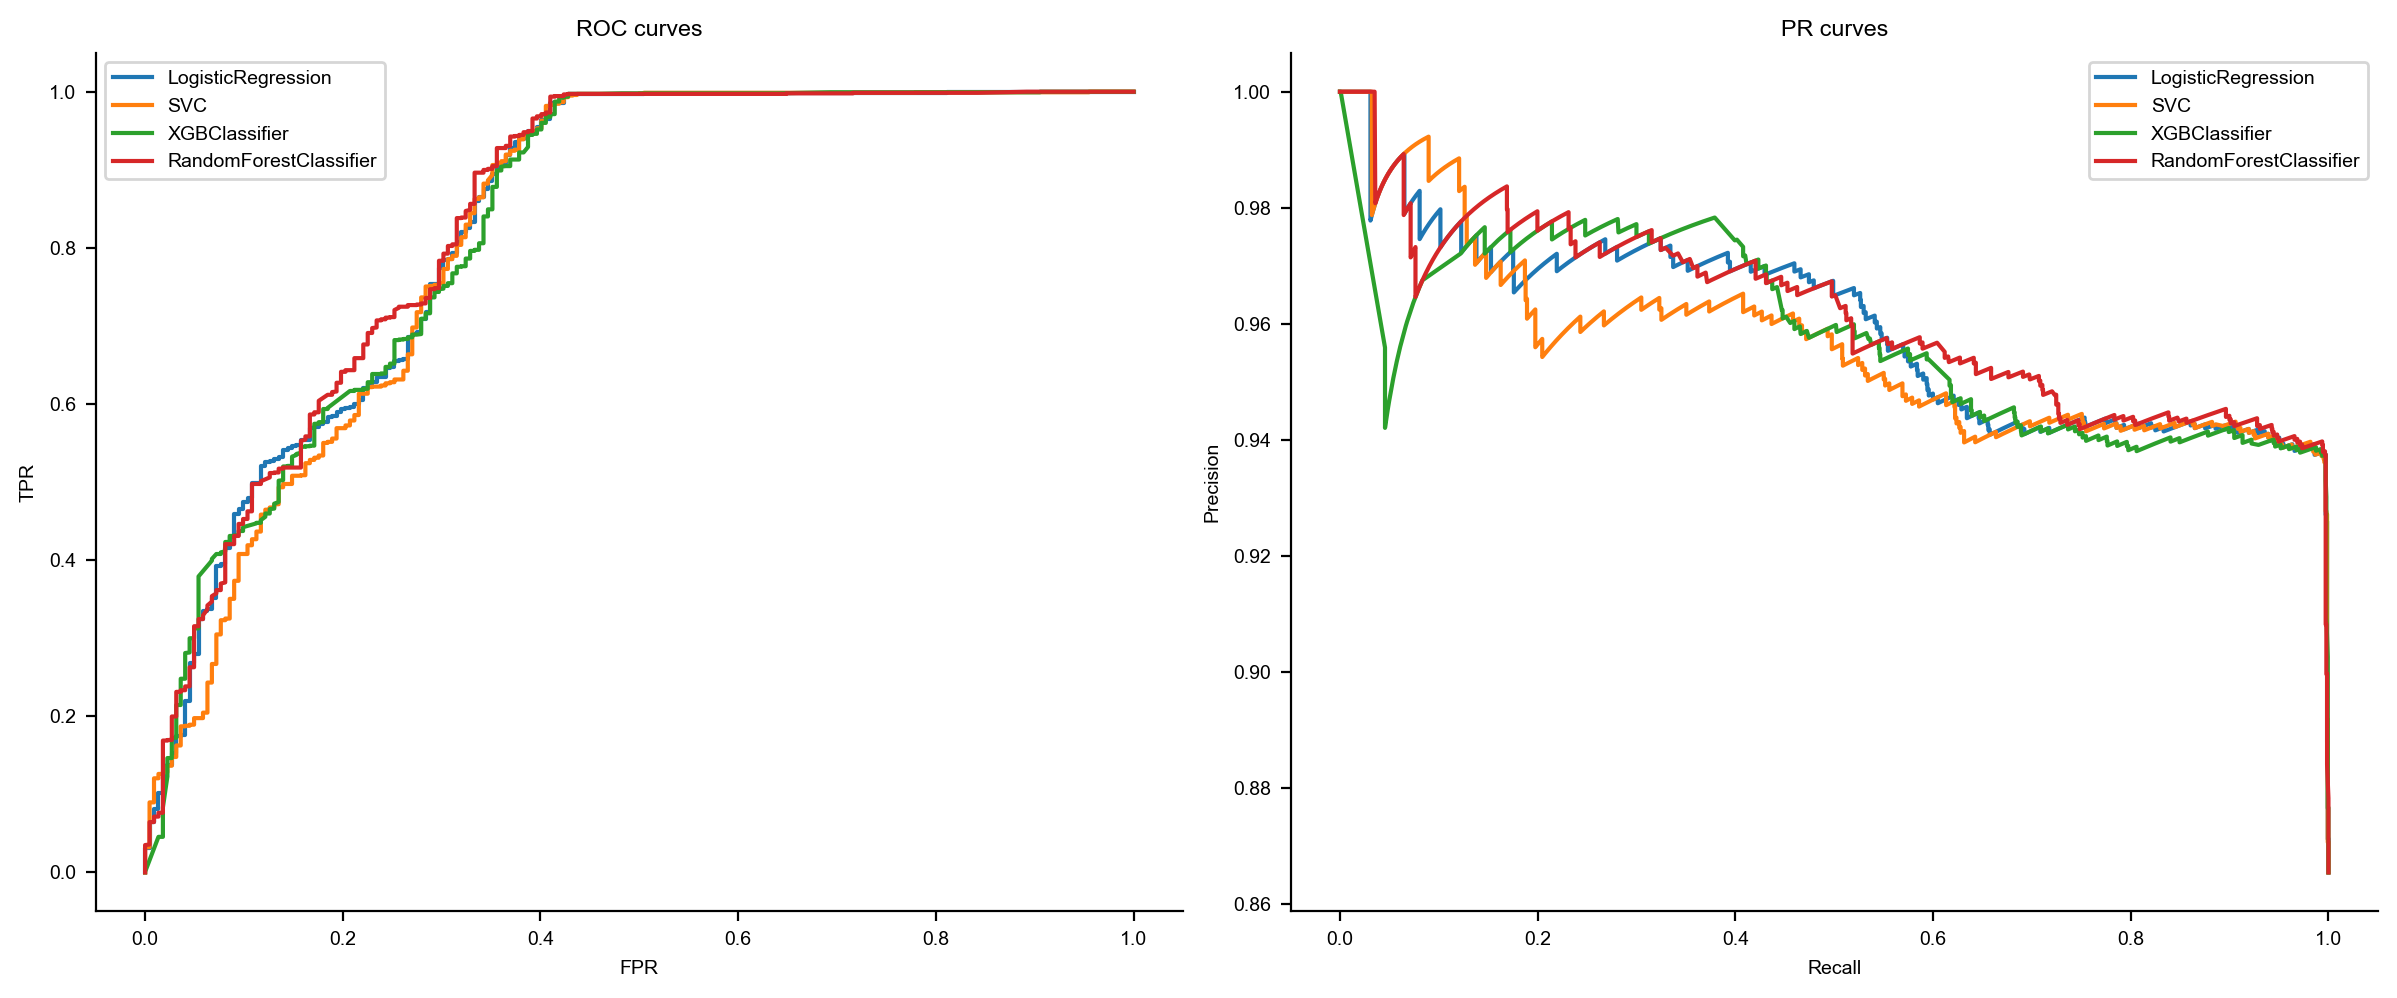

In [47]:
#!/usr/bin/env python3
"""
Save *all* ROC and PR curve points in two master CSVs:

    ├── all_roc_points.csv   # columns: model, fpr, tpr
    └── all_prc_points.csv   # columns: model, recall, precision

It also produces a small summary (AUROC / AUPRC) table.
Additionally prints prediction counts and percentages for each model.
"""

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier  # pip install xgboost if missing

# ── global config ──────────────────────────────────────────────────────────
rcParams.update({"font.family": "Arial", "font.size": 7})
OUTDIR = Path("/Users/haley/Desktop/send_tooo/AAA_final/curve_outputs")
OUTDIR.mkdir(exist_ok=True)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

models = [
    LogisticRegression(max_iter=1000, random_state=551),
    SVC(kernel="linear", probability=True, random_state=551),
    XGBClassifier(
        random_state=551,
        use_label_encoder=False,
        eval_metric="logloss",
        n_estimators=100,
        learning_rate=0.05,
        max_depth=10,
    ),
    RandomForestClassifier(max_depth=10, random_state=41),
]

# ── scale data once ────────────────────────────────────────────────────────
scaler = StandardScaler()
X_train_s = scaler.fit_transform(full_X_train)
X_test_s  = scaler.transform(realtest)

# ── Calculate actual counts in test data ───────────────────────────────────
actual_female = (realtest_y == 0).sum()  # Assuming 0 = female
actual_male = (realtest_y == 1).sum()    # Assuming 1 = male
total_test = len(realtest_y)

print("=" * 70)
print("ACTUAL TEST DATA DISTRIBUTION")
print("=" * 70)
print(f"Total test samples: {total_test}")
print(f"Actual Female (0): {actual_female} ({actual_female/total_test*100:.1f}%)")
print(f"Actual Male (1):   {actual_male} ({actual_male/total_test*100:.1f}%)")
print()

# ── containers ─────────────────────────────────────────────────────────────
roc_rows, prc_rows = [], []
roc_summary, prc_summary = [], []

# ── fit, predict, collect points ───────────────────────────────────────────
for i, model in enumerate(models):
    name = model.__class__.__name__
    print("=" * 70)
    print(f"MODEL {i+1}: {name}")
    print("=" * 70)
    
    # Train model
    model.fit(X_train_s, full_Y_train)
    
    # Get predictions (not just probabilities)
    y_pred = model.predict(X_test_s)
    y_prob = model.predict_proba(X_test_s)[:, 1]
    
    # Count predictions
    pred_female = (y_pred == 0).sum()
    pred_male = (y_pred == 1).sum()
    
    # Print prediction results
    print(f"Predicted Female (0): {pred_female} ({pred_female/total_test*100:.1f}%)")
    print(f"Predicted Male (1):   {pred_male} ({pred_male/total_test*100:.1f}%)")
    print()
    
    # Calculate accuracy for each class
    correct_female = ((y_pred == 0) & (realtest_y == 0)).sum()
    correct_male = ((y_pred == 1) & (realtest_y == 1)).sum()
    
    if actual_female > 0:
        female_accuracy = correct_female / actual_female * 100
        print(f"Female prediction accuracy: {correct_female}/{actual_female} ({female_accuracy:.1f}%)")
    
    if actual_male > 0:
        male_accuracy = correct_male / actual_male * 100
        print(f"Male prediction accuracy:   {correct_male}/{actual_male} ({male_accuracy:.1f}%)")
    
    overall_accuracy = (correct_female + correct_male) / total_test * 100
    print(f"Overall accuracy: {overall_accuracy:.1f}%")

    # ROC
    fpr, tpr, _ = roc_curve(realtest_y, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_rows.append(pd.DataFrame({"model": name, "fpr": fpr, "tpr": tpr}))
    roc_summary.append({"model": name, "auc": roc_auc})
    print(f"ROC AUC: {roc_auc:.3f}")

    # PR
    prec, rec, _ = precision_recall_curve(realtest_y, y_prob)
    pr_auc = average_precision_score(realtest_y, y_prob)
    prc_rows.append(pd.DataFrame({"model": name, "recall": rec, "precision": prec}))
    prc_summary.append({"model": name, "auprc": pr_auc})
    print(f"PR AUC:  {pr_auc:.3f}")
    print()

# ── write master CSVs ──────────────────────────────────────────────────────
pd.concat(roc_rows, ignore_index=True).to_csv(OUTDIR / "all_roc_points.csv", index=False)
pd.concat(prc_rows, ignore_index=True).to_csv(OUTDIR / "all_prc_points.csv", index=False)

pd.DataFrame(roc_summary).to_csv(OUTDIR / "roc_auc_summary.csv", index=False)
pd.DataFrame(prc_summary).to_csv(OUTDIR / "prc_auc_summary.csv", index=False)

print("=" * 70)
print("✅  Saved:")
for fn in ["all_roc_points.csv", "all_prc_points.csv",
           "roc_auc_summary.csv", "prc_auc_summary.csv"]:
    print("   └─", OUTDIR / fn)

# ── (optional) quick plot from the master CSVs ─────────────────────────────
plt.figure(figsize=(12, 5))
roc_ax = plt.subplot(1, 2, 1)
pr_ax = plt.subplot(1, 2, 2)

roc_pts = pd.read_csv(OUTDIR / "all_roc_points.csv")
prc_pts = pd.read_csv(OUTDIR / "all_prc_points.csv")

for name, color in zip([m.__class__.__name__ for m in models], colors):
    roc_sub = roc_pts[roc_pts.model == name]
    prc_sub = prc_pts[prc_pts.model == name]

    roc_ax.plot(roc_sub.fpr, roc_sub.tpr, label=name, color=color)
    pr_ax.plot(prc_sub.recall, prc_sub.precision, label=name, color=color)

roc_ax.set_title("ROC curves");   roc_ax.set_xlabel("FPR"); roc_ax.set_ylabel("TPR")
pr_ax.set_title("PR curves");     pr_ax.set_xlabel("Recall"); pr_ax.set_ylabel("Precision")
for ax in (roc_ax, pr_ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(fontsize=7)

plt.tight_layout(); plt.show()

## 8. Misclassification Analysis on Test Data

### 8.1 Misclassification Data Specification
**Training**: Models trained on GSM combined dataset (full_X_train, full_Y_train)
**Error Analysis**: Performed on CMO test dataset (realtest, realtest_y)

**Analysis Scope**:
- **True labels**: CMO305 (male=1), CMO306 (female=0) 
- **Predicted labels**: Random Forest model predictions on realtest
- **Error types**: Male→Female and Female→Male misclassifications

### 8.2 Cell-Level Error Tracking
**Misclassified Cell Identification**:
- **Males misclassified as females**: Cell barcodes from CMO305 predicted as female
- **Females misclassified as males**: Cell barcodes from CMO306 predicted as male
- **Export files**: CSV files with cell barcodes and error classifications

### 8.3 AnnData Integration with Test Data Results
**Data Integration**:
- **Original data**: CMO experimental dataset expression matrix
- **Predictions**: Random Forest model outputs on test data
- **Annotations**: True vs predicted labels, misclassification flags
- **Output**: Annotated AnnData object for downstream analysis

**Error Pattern Analysis**: Understanding systematic misclassification patterns in the CMO test dataset.

In [121]:
#!/usr/bin/env python3
"""
Create AnnData object with RandomForest misclassification information
"""

import pandas as pd
import numpy as np
import scanpy as sc
import anndata
from pathlib import Path

# ── Step 1: Load and process the original data (your existing code) ────────
print("Loading original data...")
realmat = sc.read_mtx('matrix.mtx')
realfeature = pd.read_csv('features.tsv', sep='\t', header=None)
realmat = realmat[0:32285]
realtag = pd.read_csv('tag.csv')
actt = realfeature.loc[realfeature[2] == 'Gene Expression']
celltag = pd.read_csv('barcodes.tsv', sep='\t', header=None)

# Create AnnData object
adata = anndata.AnnData(X=realmat.X.T)
lol = list(celltag[0])
adata.obs['cell'] = lol
lmao = list(actt[1])
adata.var['gene_ids'] = lmao

# Scanpy settings
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', fontsize=7)

# Filter cells and genes
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

# Mitochondrial genes QC
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Set gene IDs as index
adata.var.index = adata.var['gene_ids'].values
adata.var.index.name = None
adata.var_names_make_unique()

# Normalize and log transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# ── Step 2: Process gender information ─────────────────────────────────────
print("\nProcessing gender information...")
METT = adata.X
dense_matrix = METT.toarray()
METT = pd.DataFrame(dense_matrix, columns=adata.var_names, index=adata.obs['cell'].values)
METT['cell'] = adata.obs['cell'].values

# Join with tag information
realtag.index = realtag['cell_barcode'].values
result = METT.join(realtag[['feature_call']], how='left')
result = result.dropna(subset=['feature_call'])

# Initialize and update gender
result['gender'] = None
result.loc[result['feature_call'] == 'CMO305', 'gender'] = 1  # Male
result.loc[result['feature_call'] == 'CMO306', 'gender'] = 0  # Female

# ── Step 3: Load RandomForest misclassification results ────────────────────
print("\nLoading RandomForest misclassification data...")
OUTDIR = Path("/Users/haley/Desktop/send_tooo/AAA_final/misclassified")

# Read the RandomForest misclassification files
rf_all_misclass = pd.read_csv(OUTDIR / "RandomForestClassifier_all_misclassified.csv")
rf_male_as_female = pd.read_csv(OUTDIR / "RandomForestClassifier_male_misclassified_as_female.csv")
rf_female_as_male = pd.read_csv(OUTDIR / "RandomForestClassifier_female_misclassified_as_male.csv")

print(f"Total misclassified cells: {len(rf_all_misclass)}")
print(f"  - Males misclassified as females: {len(rf_male_as_female)}")
print(f"  - Females misclassified as males: {len(rf_female_as_male)}")

# ── Step 4: Add misclassification info to AnnData ──────────────────────────
print("\nAdding misclassification info to AnnData...")

# First, add the actual gender labels to all cells that have them
# Use NaN for numeric columns and empty string for string columns
adata.obs['actual_gender'] = np.nan  # Use NaN instead of None for numeric
adata.obs['actual_gender_label'] = ''  # Use empty string instead of None

# Map gender information from result dataframe
for idx, row in result.iterrows():
    if idx in adata.obs['cell'].values:
        cell_idx = adata.obs[adata.obs['cell'] == idx].index[0]
        adata.obs.loc[cell_idx, 'actual_gender'] = float(row['gender'])
        adata.obs.loc[cell_idx, 'actual_gender_label'] = 'Male' if row['gender'] == 1 else 'Female'

# Add RandomForest prediction and misclassification status
adata.obs['rf_predicted_gender'] = np.nan  # Use NaN for numeric
adata.obs['rf_predicted_gender_label'] = ''  # Use empty string
adata.obs['rf_misclassified'] = False
adata.obs['rf_misclass_type'] = ''  # Use empty string

# Mark misclassified cells
for _, row in rf_all_misclass.iterrows():
    cell_barcode = row['cell_barcode']
    if cell_barcode in adata.obs['cell'].values:
        cell_idx = adata.obs[adata.obs['cell'] == cell_barcode].index[0]
        adata.obs.loc[cell_idx, 'rf_predicted_gender'] = float(row['predicted_label'])
        adata.obs.loc[cell_idx, 'rf_predicted_gender_label'] = 'Male' if row['predicted_label'] == 1 else 'Female'
        adata.obs.loc[cell_idx, 'rf_misclassified'] = True
        adata.obs.loc[cell_idx, 'rf_misclass_type'] = row['misclassification_type']

# For correctly classified cells, predicted = actual
correct_mask = (adata.obs['actual_gender'].notna()) & (~adata.obs['rf_misclassified'])
adata.obs.loc[correct_mask, 'rf_predicted_gender'] = adata.obs.loc[correct_mask, 'actual_gender']
adata.obs.loc[correct_mask, 'rf_predicted_gender_label'] = adata.obs.loc[correct_mask, 'actual_gender_label']

# ── Step 5: Add summary statistics to uns ──────────────────────────────────
print("\nAdding summary statistics...")
adata.uns['rf_misclassification'] = {
    'total_misclassified': len(rf_all_misclass),
    'male_as_female': len(rf_male_as_female),
    'female_as_male': len(rf_female_as_male),
    'misclassified_cells': {
        'male_as_female': rf_male_as_female['cell_barcode'].tolist(),
        'female_as_male': rf_female_as_male['cell_barcode'].tolist()
    }
}

# Count cells with gender info
has_gender = adata.obs['actual_gender'].notna().sum()
total_cells = len(adata.obs)
print(f"\nCells with gender information: {has_gender}/{total_cells}")

# ── Step 6: Convert data types before saving ───────────────────────────────
print("\nConverting data types for h5ad compatibility...")

# Convert string columns to categorical to save space and ensure compatibility
string_cols = ['actual_gender_label', 'rf_predicted_gender_label', 'rf_misclass_type']
for col in string_cols:
    # Replace empty strings with a proper category
    adata.obs[col] = adata.obs[col].replace('', 'Unknown')
    adata.obs[col] = pd.Categorical(adata.obs[col])

# Ensure numeric columns are float type
adata.obs['actual_gender'] = adata.obs['actual_gender'].astype('float32')
adata.obs['rf_predicted_gender'] = adata.obs['rf_predicted_gender'].astype('float32')

# ── Step 7: Save the AnnData object ────────────────────────────────────────
# ── Step 7: Save the AnnData object ────────────────────────────────────────
output_file = "adata_with_rf_misclassification.h5ad"
print(f"\nSaving AnnData to {output_file}...")
adata.write_h5ad(output_file)

# ── Step 8: Create visualization-ready subset ──────────────────────────────
print("\nCreating subset with only cells that have gender labels...")
# Filter to only cells with gender information (not Unknown)
adata_gender = adata[adata.obs['actual_gender_label'] != 'Unknown'].copy()

# Add colors for visualization
adata_gender.uns['actual_gender_colors'] = ['#FF69B4', '#4169E1']  # Pink for Female, Blue for Male
adata_gender.uns['rf_misclassified_colors'] = ['#90EE90', '#FF6347']  # Light green for correct, Tomato for misclassified

output_file_gender = "adata_gender_only_with_rf_misclass.h5ad"
print(f"Saving gender-only AnnData to {output_file_gender}...")
adata_gender.write_h5ad(output_file_gender)

# ── Print summary ───────────────────────────────────────────────────────────
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Total cells in AnnData: {len(adata.obs)}")
print(f"Cells with gender labels: {has_gender}")
print(f"Cells without gender labels: {total_cells - has_gender}")
print(f"\nRandomForest misclassification:")
print(f"  - Total misclassified: {len(rf_all_misclass)}")
print(f"  - Males → Females: {len(rf_male_as_female)}")
print(f"  - Females → Males: {len(rf_female_as_male)}")
print(f"\nOutput files created:")
print(f"  1. {output_file} (all cells)")
print(f"  2. {output_file_gender} (only cells with gender labels)")

# ── Optional: Create a quick visualization ──────────────────────────────────
print("\nYou can now load the data and visualize misclassifications:")
print(">>> adata = sc.read_h5ad('adata_gender_only_with_rf_misclass.h5ad')")
print(">>> sc.pl.umap(adata, color=['actual_gender_label', 'rf_misclassified', 'rf_misclass_type'])")

Loading original data...
scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 pynndescent==0.5.13
filtered out 3 cells that have less than 100 genes expressed
filtered out 19261 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)

Processing gender information...

Loading RandomForest misclassification data...
Total misclassified cells: 133
  - Males misclassified as females: 45
  - Females misclassified as males: 88

Adding misclassification info to AnnData...

Adding summary statistics...

Cells with gender information: 1649/1649

Converting data types for h5ad compatibility...

Saving AnnData to adata_with_rf_misclassification.h5ad...

Creating subset with only cells that have gender labels...
Saving gender-only AnnData to adata_gender_only_with_rf_misclass.h5ad...

SUMMARY
Total cells in AnnData: 1649
Cells with gender labels: 1649
Cells without gender labels: 0

Rand

In [123]:
import scanpy as sc
import numpy as np

# Load the AnnData
adata = sc.read_h5ad('adata_with_rf_misclassification.h5ad')

# Example 1: Get all misclassified cells
misclassified_cells = adata[adata.obs['rf_misclassified'] == True]
print(f"Number of misclassified cells: {len(misclassified_cells)}")

# Example 2: Get males misclassified as females
male_as_female = adata[adata.obs['rf_misclass_type'] == 'male_as_female']
print(f"Males misclassified as females: {len(male_as_female)}")

# Example 3: View the actual vs predicted for a specific cell
cell_barcode = 'AAACCCAAGAAACCCA-1'  # Example - replace with a real barcode
if cell_barcode in adata.obs['cell'].values:
    cell_data = adata[adata.obs['cell'] == cell_barcode].obs
    print(f"\nCell: {cell_barcode}")
    print(f"Actual: {cell_data['actual_gender_label'].iloc[0]}")
    print(f"Predicted: {cell_data['rf_predicted_gender_label'].iloc[0]}")
else:
    print(f"\nCell {cell_barcode} not found in data")

# Example 4: Get summary statistics
summary = adata.uns['rf_misclassification']
print(f"\nTotal misclassified: {summary['total_misclassified']}")
print(f"Male → Female: {summary['male_as_female']}")
print(f"Female → Male: {summary['female_as_male']}")

# Example 5: Get list of all cell barcodes that were misclassified (corrected)
# Convert to lists first, then concatenate
male_as_female_list = list(summary['misclassified_cells']['male_as_female'])
female_as_male_list = list(summary['misclassified_cells']['female_as_male'])
all_misclass_barcodes = male_as_female_list + female_as_male_list

print(f"\nTotal misclassified cell barcodes: {len(all_misclass_barcodes)}")
print(f"First 5 misclassified barcodes: {all_misclass_barcodes[:5]}")

# Alternative method using numpy concatenate
all_misclass_barcodes_np = np.concatenate([
    summary['misclassified_cells']['male_as_female'],
    summary['misclassified_cells']['female_as_male']
])
print(f"\nUsing numpy concatenate: {len(all_misclass_barcodes_np)} barcodes")

# Example 6: Get actual cell barcodes from the obs dataframe (more reliable)
print("\n--- Getting misclassified cells directly from obs ---")
misclass_barcodes_from_obs = adata.obs[adata.obs['rf_misclassified'] == True]['cell'].tolist()
print(f"Misclassified cells from obs: {len(misclass_barcodes_from_obs)}")
print(f"First 5: {misclass_barcodes_from_obs[:5]}")

# Example 7: Analyze misclassification patterns
print("\n--- Misclassification Analysis ---")
# Get gender distribution
print(f"Total females: {(adata.obs['actual_gender_label'] == 'Female').sum()}")
print(f"Total males: {(adata.obs['actual_gender_label'] == 'Male').sum()}")

# Calculate misclassification rates
total_females = (adata.obs['actual_gender_label'] == 'Female').sum()
total_males = (adata.obs['actual_gender_label'] == 'Male').sum()
female_misclass_rate = summary['female_as_male'] / total_females * 100
male_misclass_rate = summary['male_as_female'] / total_males * 100

print(f"\nMisclassification rates:")
print(f"Female → Male: {summary['female_as_male']}/{total_females} ({female_misclass_rate:.1f}%)")
print(f"Male → Female: {summary['male_as_female']}/{total_males} ({male_misclass_rate:.1f}%)")

# Example 8: Look at a specific misclassified cell
print("\n--- Example misclassified cell ---")
if len(male_as_female) > 0:
    example_cell = male_as_female.obs.iloc[0]
    print(f"Cell barcode: {example_cell['cell']}")
    print(f"Actual gender: {example_cell['actual_gender_label']} ({example_cell['actual_gender']})")
    print(f"RF predicted: {example_cell['rf_predicted_gender_label']} ({example_cell['rf_predicted_gender']})")
    print(f"Misclass type: {example_cell['rf_misclass_type']}")

Number of misclassified cells: 133
Males misclassified as females: 45

Cell AAACCCAAGAAACCCA-1 not found in data

Total misclassified: 133
Male → Female: 45
Female → Male: 88

Total misclassified cell barcodes: 133
First 5 misclassified barcodes: ['AACCAACAGATACGAT-1', 'AACTTCTTCGCGTGCA-1', 'AAGTACCTCCTTCACG-1', 'AATGAAGGTGGAATGC-1', 'ACAAGCTAGATAACAC-1']

Using numpy concatenate: 133 barcodes

--- Getting misclassified cells directly from obs ---
Misclassified cells from obs: 133
First 5: ['AAAGGGCTCCTTCACG-1', 'AAATGGAAGTACCCTA-1', 'AACAGGGTCGAACTCA-1', 'AACCAACAGATACGAT-1', 'AACTTCTTCGCGTGCA-1']

--- Misclassification Analysis ---
Total females: 222
Total males: 1427

Misclassification rates:
Female → Male: 88/222 (39.6%)
Male → Female: 45/1427 (3.2%)

--- Example misclassified cell ---
Cell barcode: AACCAACAGATACGAT-1
Actual gender: Male (1.0)
RF predicted: Female (0.0)
Misclass type: male_as_female


Training LogisticRegression

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

         0.0       0.44      0.66      0.53       222
         1.0       0.94      0.87      0.90      1427

    accuracy                           0.84      1649
   macro avg       0.69      0.76      0.72      1649
weighted avg       0.87      0.84      0.85      1649

Training SVC

Classification Report for SVC:
              precision    recall  f1-score   support

         0.0       0.52      0.64      0.58       222
         1.0       0.94      0.91      0.92      1427

    accuracy                           0.87      1649
   macro avg       0.73      0.78      0.75      1649
weighted avg       0.89      0.87      0.88      1649

Training XGBClassifier

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

         0.0       0.38      0.66      0.48       222
         1.0       0.94      0.83      0.88      142

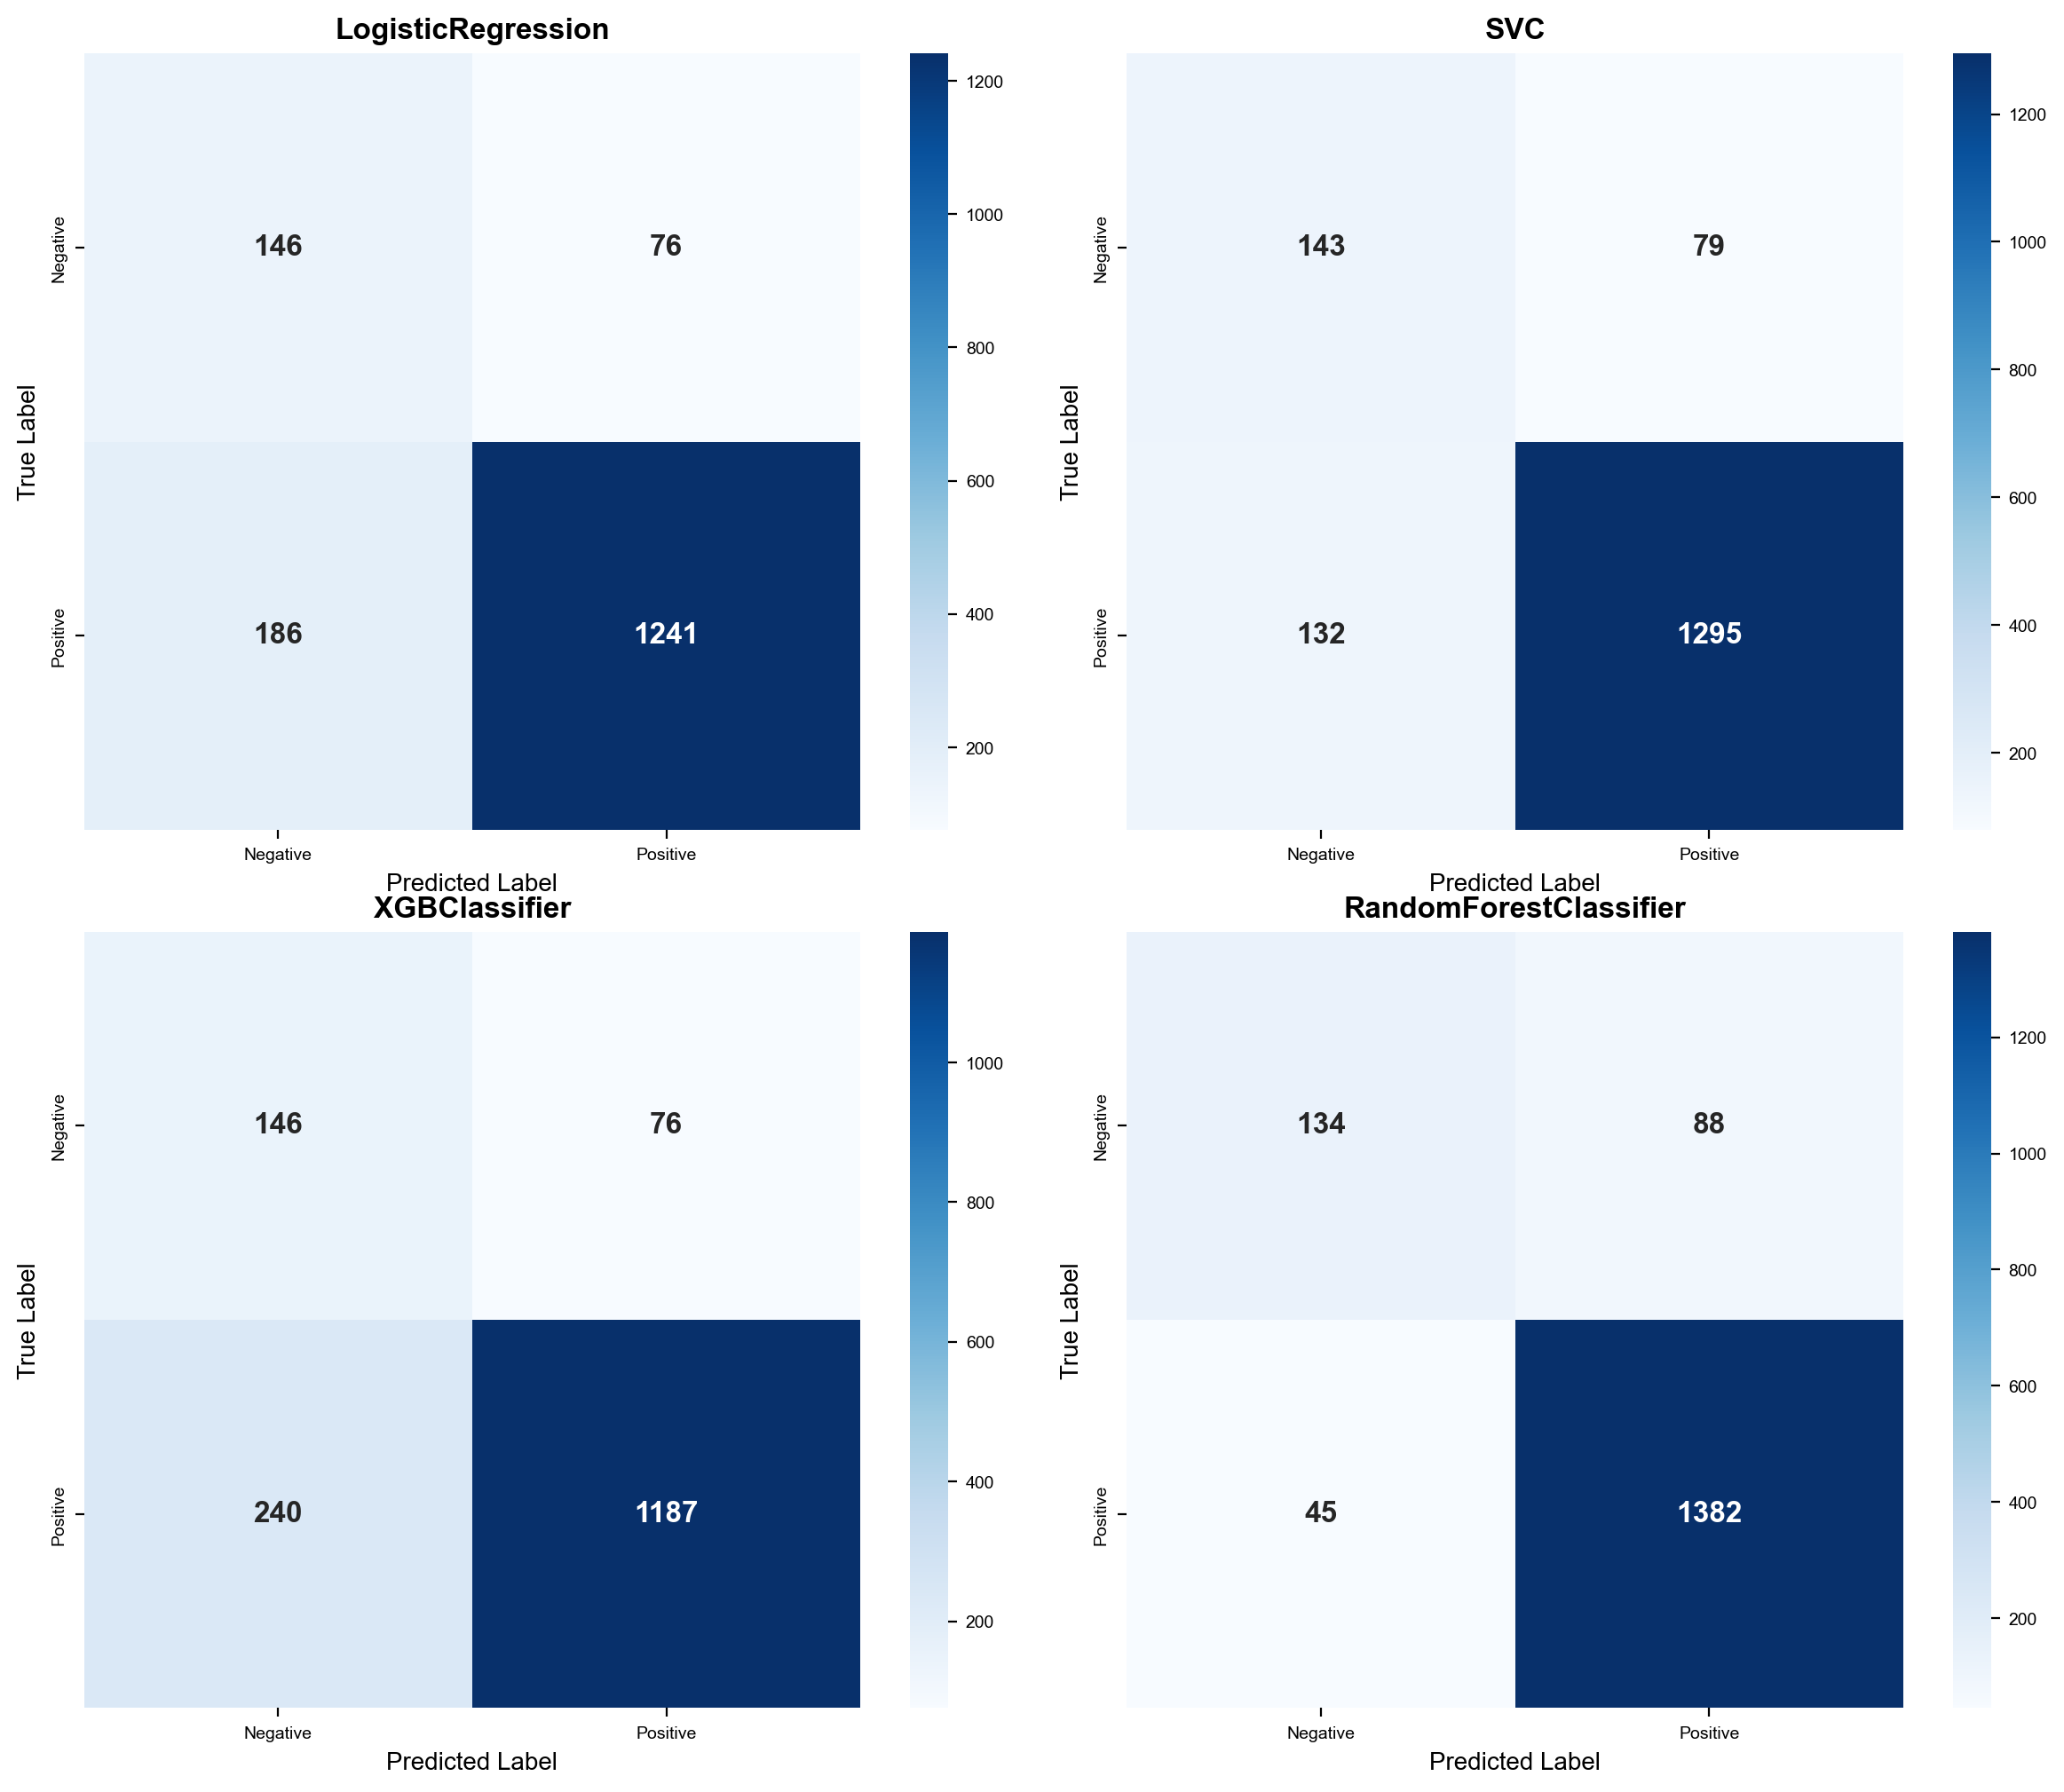

✅ All 4 confusion matrices displayed and saved!


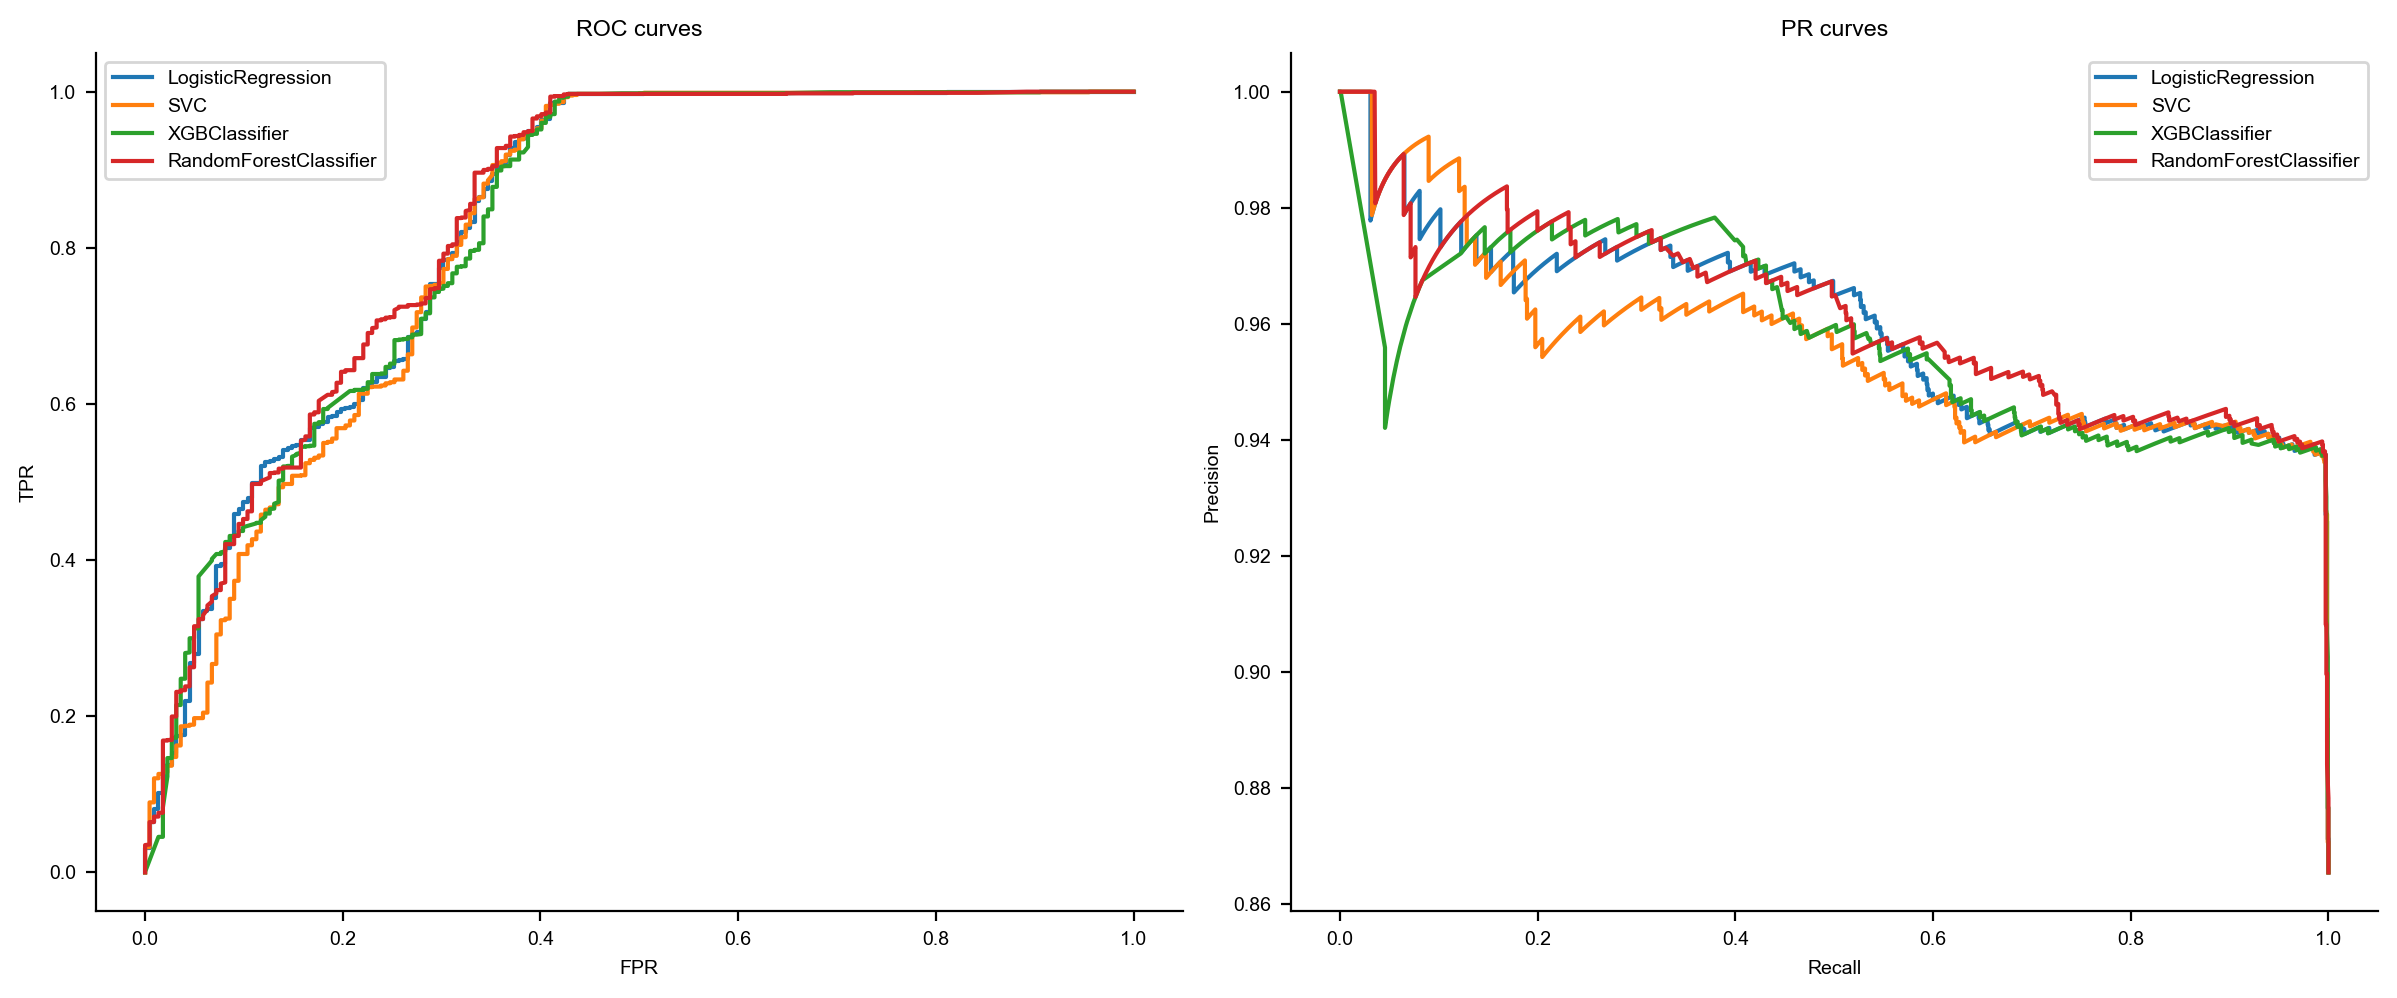


✅  All confusion matrices saved to /Users/haley/Desktop/send_tooo/AAA_final/curve_outputs
   Individual plots and CSVs created for each model


In [45]:
#!/usr/bin/env python3
"""
Save *all* ROC and PR curve points in two master CSVs:

    ├── all_roc_points.csv   # columns: model, fpr, tpr
    └── all_prc_points.csv   # columns: model, recall, precision

It also produces a small summary (AUROC / AUPRC) table and confusion matrices for each model.
"""

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    classification_report,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier  # pip install xgboost if missing

# ── global config ──────────────────────────────────────────────────────────
rcParams.update({"font.family": "Arial", "font.size": 7})
OUTDIR = Path("/Users/haley/Desktop/send_tooo/AAA_final/curve_outputs")
OUTDIR.mkdir(exist_ok=True)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

models = [
    LogisticRegression(max_iter=1000, random_state=551),
    SVC(kernel="linear", probability=True, random_state=551),
    XGBClassifier(
        random_state=551,
        use_label_encoder=False,
        eval_metric="logloss",
        n_estimators=100,
        learning_rate=0.05,
        max_depth=10,
    ),
    RandomForestClassifier(max_depth=10, random_state=41),
]

# ── scale data once ────────────────────────────────────────────────────────
scaler = StandardScaler()
X_train_s = scaler.fit_transform(full_X_train)
X_test_s  = scaler.transform(realtest)

# ── containers ─────────────────────────────────────────────────────────────
roc_rows, prc_rows = [], []
roc_summary, prc_summary = [], []
confusion_matrices = {}

# ── fit, predict, collect points ───────────────────────────────────────────
for model in models:
    name = model.__class__.__name__
    print("Training", name)
    model.fit(X_train_s, full_Y_train)
    y_prob = model.predict_proba(X_test_s)[:, 1]
    y_pred = model.predict(X_test_s)  # For confusion matrix

    # ROC
    fpr, tpr, _ = roc_curve(realtest_y, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_rows.append(pd.DataFrame({"model": name, "fpr": fpr, "tpr": tpr}))
    roc_summary.append({"model": name, "auc": roc_auc})

    # PR
    prec, rec, _ = precision_recall_curve(realtest_y, y_prob)
    pr_auc = average_precision_score(realtest_y, y_prob)
    prc_rows.append(pd.DataFrame({"model": name, "recall": rec, "precision": prec}))
    prc_summary.append({"model": name, "auprc": pr_auc})
    
    # Confusion Matrix
    cm = confusion_matrix(realtest_y, y_pred)
    confusion_matrices[name] = cm
    
    # Save confusion matrix as CSV
    cm_df = pd.DataFrame(cm, 
                         index=['True Neg', 'True Pos'], 
                         columns=['Pred Neg', 'Pred Pos'])
    cm_df.to_csv(OUTDIR / f"confusion_matrix_{name}.csv")
    
    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(realtest_y, y_pred))

# ── write master CSVs ──────────────────────────────────────────────────────
pd.concat(roc_rows, ignore_index=True).to_csv(OUTDIR / "all_roc_points.csv", index=False)
pd.concat(prc_rows, ignore_index=True).to_csv(OUTDIR / "all_prc_points.csv", index=False)

pd.DataFrame(roc_summary).to_csv(OUTDIR / "roc_auc_summary.csv", index=False)
pd.DataFrame(prc_summary).to_csv(OUTDIR / "prc_auc_summary.csv", index=False)

print("\n✅  Saved:")
for fn in ["all_roc_points.csv", "all_prc_points.csv",
           "roc_auc_summary.csv", "prc_auc_summary.csv"]:
    print("   └─", OUTDIR / fn)

# ── plot confusion matrices ────────────────────────────────────────────────
# Create a figure with 4 subplots (2x2 grid) for the 4 models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

print("\n📊 Creating confusion matrices for 4 models:")
for idx, name in enumerate(confusion_matrices.keys()):
    cm = confusion_matrices[name]
    print(f"   {idx+1}. {name}")
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                ax=axes[idx], cbar=True, square=True,
                annot_kws={"size": 12, "weight": "bold"})
    
    axes[idx].set_title(name, fontsize=12, weight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    axes[idx].set_ylabel('True Label', fontsize=10)

plt.tight_layout()
plt.savefig(OUTDIR / "confusion_matrices_all_4models.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ All 4 confusion matrices displayed and saved!")

# ── plot ROC and PR curves ─────────────────────────────────────────────────
plt.figure(figsize=(12, 5))
roc_ax = plt.subplot(1, 2, 1)
pr_ax = plt.subplot(1, 2, 2)

roc_pts = pd.read_csv(OUTDIR / "all_roc_points.csv")
prc_pts = pd.read_csv(OUTDIR / "all_prc_points.csv")

for name, color in zip([m.__class__.__name__ for m in models], colors):
    roc_sub = roc_pts[roc_pts.model == name]
    prc_sub = prc_pts[prc_pts.model == name]

    roc_ax.plot(roc_sub.fpr, roc_sub.tpr, label=name, color=color)
    pr_ax.plot(prc_sub.recall, prc_sub.precision, label=name, color=color)

roc_ax.set_title("ROC curves");   roc_ax.set_xlabel("FPR"); roc_ax.set_ylabel("TPR")
pr_ax.set_title("PR curves");     pr_ax.set_xlabel("Recall"); pr_ax.set_ylabel("Precision")
for ax in (roc_ax, pr_ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(fontsize=7)

plt.tight_layout()
plt.savefig(OUTDIR / "roc_pr_curves.png", dpi=300, bbox_inches='tight')
plt.show()

# ── create individual confusion matrix plots ───────────────────────────────
for model_name, cm in confusion_matrices.items():
    plt.figure(figsize=(6, 5))
    
    # Create a simple heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                cbar=True, square=True, 
                annot_kws={"size": 14})
    
    plt.title(model_name, fontsize=14, pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(OUTDIR / f"confusion_matrix_{model_name}.png", dpi=300, bbox_inches='tight')
    plt.close()

print(f"\n✅  All confusion matrices saved to {OUTDIR}")
print("   Individual plots and CSVs created for each model")


==== 曲线面积 ====
Overall  AUROC=0.836  AUPRC=0.959
Female   AUROC=0.836  AUPRC=0.706

==== 固定阈值(0.5) Female ====
Precision=0.773  Recall=0.599  F1=0.675


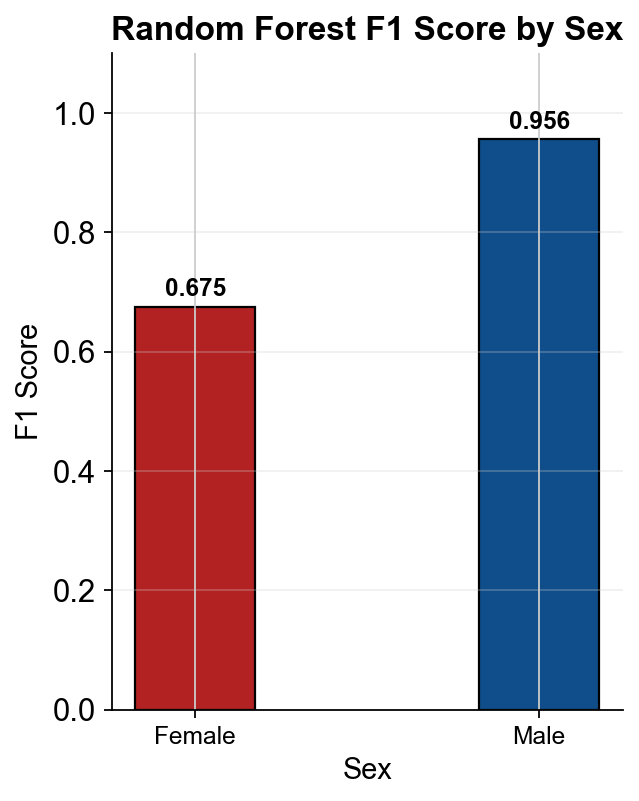

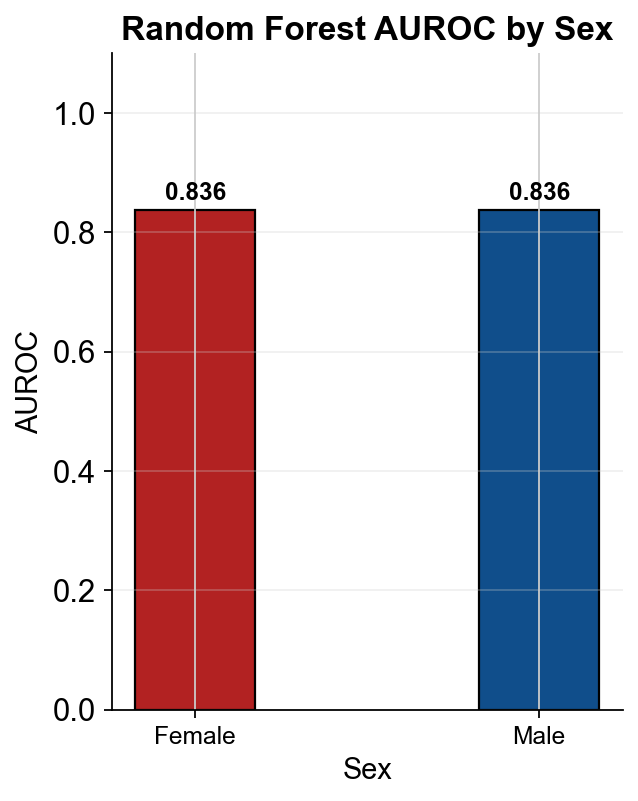

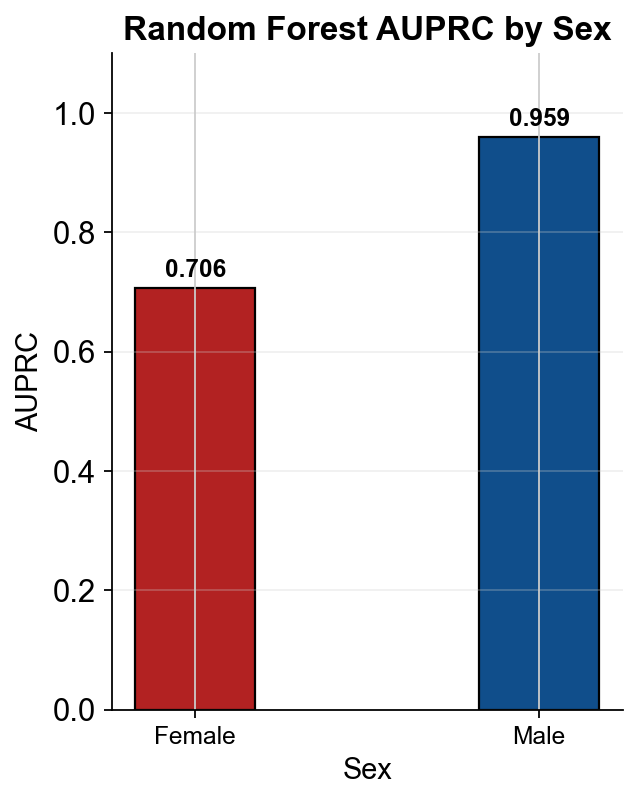


✅ 图表已保存到 /Users/haley/Desktop/send_tooo/curve_outputs


In [95]:
#!/usr/bin/env python3
"""
Random-Forest (seed=97; 600×depth10×leaf2) ➜
打印 overall / female AUROC & AUPRC，
并画柱状图 (Sex, 细柱, 颜色与示例一致，Y 轴从 0 开始)。
-----------------------------------------------------------------
把 full_X_train, full_Y_train, realtest, realtest_y 换成你的变量
"""

from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score)
from sklearn.ensemble import RandomForestClassifier

# ========== 1. 数据 ==========
# ↓↓↓  替换
# full_X_train, full_Y_train, realtest, realtest_y
# ↑↑↑
scaler     = StandardScaler()
X_train_s  = scaler.fit_transform(full_X_train)
X_test_s   = scaler.transform(realtest)
y_train    = full_Y_train.astype(int)
y_test     = realtest_y.astype(int)

# ========== 2. 训练 RF ==========
rf = RandomForestClassifier(
        n_estimators     = 600,
        max_depth        = 10,
        min_samples_leaf = 2,
        random_state     = 97,
        n_jobs           = -1)
rf.fit(X_train_s, y_train)

# ========== 3. 预测 & 指标 ==========
prob_male = rf.predict_proba(X_test_s)[:, 1]
prob_fem  = 1 - prob_male
y_pred    = (prob_male >= 0.5).astype(int)

prec_f = precision_score(y_test, y_pred, pos_label=0)
rec_f  = recall_score   (y_test, y_pred, pos_label=0)
f1_f   = f1_score       (y_test, y_pred, pos_label=0)

overall_auc  = roc_auc_score(y_test, prob_male)
overall_aupr = average_precision_score(y_test, prob_male)
fem_auc      = roc_auc_score((y_test==0).astype(int), prob_fem)
fem_aupr     = average_precision_score((y_test==0).astype(int), prob_fem)

print("\n==== 曲线面积 ====")
print(f"Overall  AUROC={overall_auc:.3f}  AUPRC={overall_aupr:.3f}")
print(f"Female   AUROC={fem_auc:.3f}  AUPRC={fem_aupr:.3f}")

print("\n==== 固定阈值(0.5) Female ====")
print(f"Precision={prec_f:.3f}  Recall={rec_f:.3f}  F1={f1_f:.3f}")

# ========== 4. 绘柱状图 ==========
OUTDIR = Path("./curve_outputs"); OUTDIR.mkdir(exist_ok=True)
gender_colors = {"Female": "#B22222", "Male": "#104E8B"}

metrics = {
    "F1 Score": (f1_f,
                 f1_score(y_test, y_pred, pos_label=1)),
    "AUROC":    (fem_auc, overall_auc),
    "AUPRC":    (fem_aupr, overall_aupr)
}

for metric_name, (val_f, val_m) in metrics.items():
    fig, ax = plt.subplots(figsize=(4, 5))
    bars = ax.bar([0, 1], [val_f, val_m], width=0.35,
                  color=[gender_colors["Female"], gender_colors["Male"]],
                  edgecolor="black")

    for bar, v in zip(bars, [val_f, val_m]):
        ax.text(bar.get_x()+bar.get_width()/2, v+0.01,
                f"{v:.3f}", ha="center", va="bottom",
                fontsize=11, weight="bold")

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Female", "Male"], fontsize=11)
    ax.set_xlabel("Sex", fontsize=13)
    ax.set_ylabel(metric_name, fontsize=13)
    ax.set_title(f"Random Forest {metric_name} by Sex",
                 fontsize=15, weight="bold")

    ax.set_ylim(0, 1.1)            # ← 让 Y 轴从 0 开始
    ax.grid(axis="y", alpha=0.3)
    ax.spines[['top','right']].set_visible(False)

    plt.tight_layout()
    plt.savefig(OUTDIR / f"rf_{metric_name.replace(' ','_').lower()}_by_sex.png",
                dpi=300, bbox_inches="tight")
    plt.show()

print(f"\n✅ 图表已保存到 {OUTDIR.resolve()}")


In [97]:
#!/usr/bin/env python3
"""
Train 4 models → 0.5 阈值 → 输出每模型预测 Female/Male 数
再加首行 True_Counts（真实标签计数）。
保存 pred_counts.csv
"""

from pathlib import Path
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.linear_model  import LogisticRegression
from sklearn.svm           import SVC
from sklearn.ensemble      import RandomForestClassifier
from xgboost               import XGBClassifier

# ========== 数据 ==========
# 替换 ↓↓↓
# full_X_train, full_Y_train, realtest, realtest_y
# ↑↑↑
scaler     = StandardScaler()
X_train_s  = scaler.fit_transform(full_X_train)
X_test_s   = scaler.transform(realtest)
y_train    = full_Y_train.astype(int)
y_test     = realtest_y.astype(int)

# ========== 模型 ==========
model_dict = {
    "LogReg":       LogisticRegression(max_iter=1000, random_state=42),
    "LinearSVC":    SVC(kernel="linear", probability=True, random_state=42),
    "XGBoost":      XGBClassifier(
                        eval_metric="logloss", random_state=42,
                        n_estimators=100, learning_rate=0.05, max_depth=10),
    "RandomForest": RandomForestClassifier(max_depth=10, random_state=42)
}

rows = []

# ---------- True Counts ----------
rows.append({
    "Model":   "True_Counts",
    "Female":  int((y_test == 0).sum()),
    "Male":    int((y_test == 1).sum()),
    "AUROC":   np.nan,
    "AUPRC":   np.nan,
    "F1":      np.nan
})

# ---------- 训练 + 预测 ----------
for name, clf in model_dict.items():
    clf.fit(X_train_s, y_train)
    prob_male = clf.predict_proba(X_test_s)[:, 1]
    y_pred    = (prob_male >= 0.5).astype(int)

    rows.append({
        "Model":   name,
        "Female":  int((y_pred == 0).sum()),
        "Male":    int((y_pred == 1).sum()),
        "AUROC":   roc_auc_score(y_test, prob_male),
        "AUPRC":   average_precision_score(y_test, prob_male),
        "F1":      f1_score(y_test, y_pred)
    })

# ========== 保存 ==========
out_df   = pd.DataFrame(rows)
out_path = Path("./pred_counts.csv")
out_df.to_csv(out_path, index=False)
print(out_df.to_string(index=False, float_format="%.3f"))
print(f"\n✅  已保存到 {out_path.resolve()}") 



       Model  Female  Male  AUROC  AUPRC    F1
 True_Counts     222  1427    NaN    NaN   NaN
      LogReg     332  1317  0.833  0.960 0.905
   LinearSVC     297  1352  0.823  0.957 0.918
     XGBoost     386  1263  0.830  0.957 0.883
RandomForest     208  1441  0.837  0.959 0.946

✅  已保存到 /Users/haley/Desktop/send_tooo/pred_counts.csv


In [82]:
#!/usr/bin/env python3
"""
Train Random Forest on full train set, test on full test set.
Print true and predicted label counts (female/male).
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# ── model setup ────────────────────────────────────────────────────────────
rf_model = RandomForestClassifier(max_depth=10, random_state=41)

# ── train on full training set ─────────────────────────────────────────────
print("Training Random Forest...")
rf_model.fit(full_X_train, full_Y_train)

# ── predict on full test set ───────────────────────────────────────────────
print("Making predictions...")
y_pred = rf_model.predict(realtest)

# ── count true labels ──────────────────────────────────────────────────────
true_female_count = np.sum(realtest_y == 0)
true_male_count = np.sum(realtest_y == 1)

# ── count predicted labels ─────────────────────────────────────────────────
pred_female_count = np.sum(y_pred == 0)
pred_male_count = np.sum(y_pred == 1)

# ── print results ──────────────────────────────────────────────────────────
print("\n" + "="*50)
print("TRUE LABEL COUNTS:")
print(f"  Female (0): {true_female_count}")
print(f"  Male (1):   {true_male_count}")
print(f"  Total:      {true_female_count + true_male_count}")

print("\nPREDICTED LABEL COUNTS:")
print(f"  Female (0): {pred_female_count}")
print(f"  Male (1):   {pred_male_count}")
print(f"  Total:      {pred_female_count + pred_male_count}")
print("="*50)

# ── optional: accuracy ─────────────────────────────────────────────────────
accuracy = np.mean(realtest_y == y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

Training Random Forest...
Making predictions...

TRUE LABEL COUNTS:
  Female (0): 222
  Male (1):   1427
  Total:      1649

PREDICTED LABEL COUNTS:
  Female (0): 179
  Male (1):   1470
  Total:      1649

Accuracy: 0.9193


# wtwt experimental(test data performance)


In [48]:
adata1

View of AnnData object with n_obs × n_vars = 8268 × 20902
    obs: 'dataset', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'conditions'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

Predicted labels saved to 'predicted_labels_jun16.csv'.


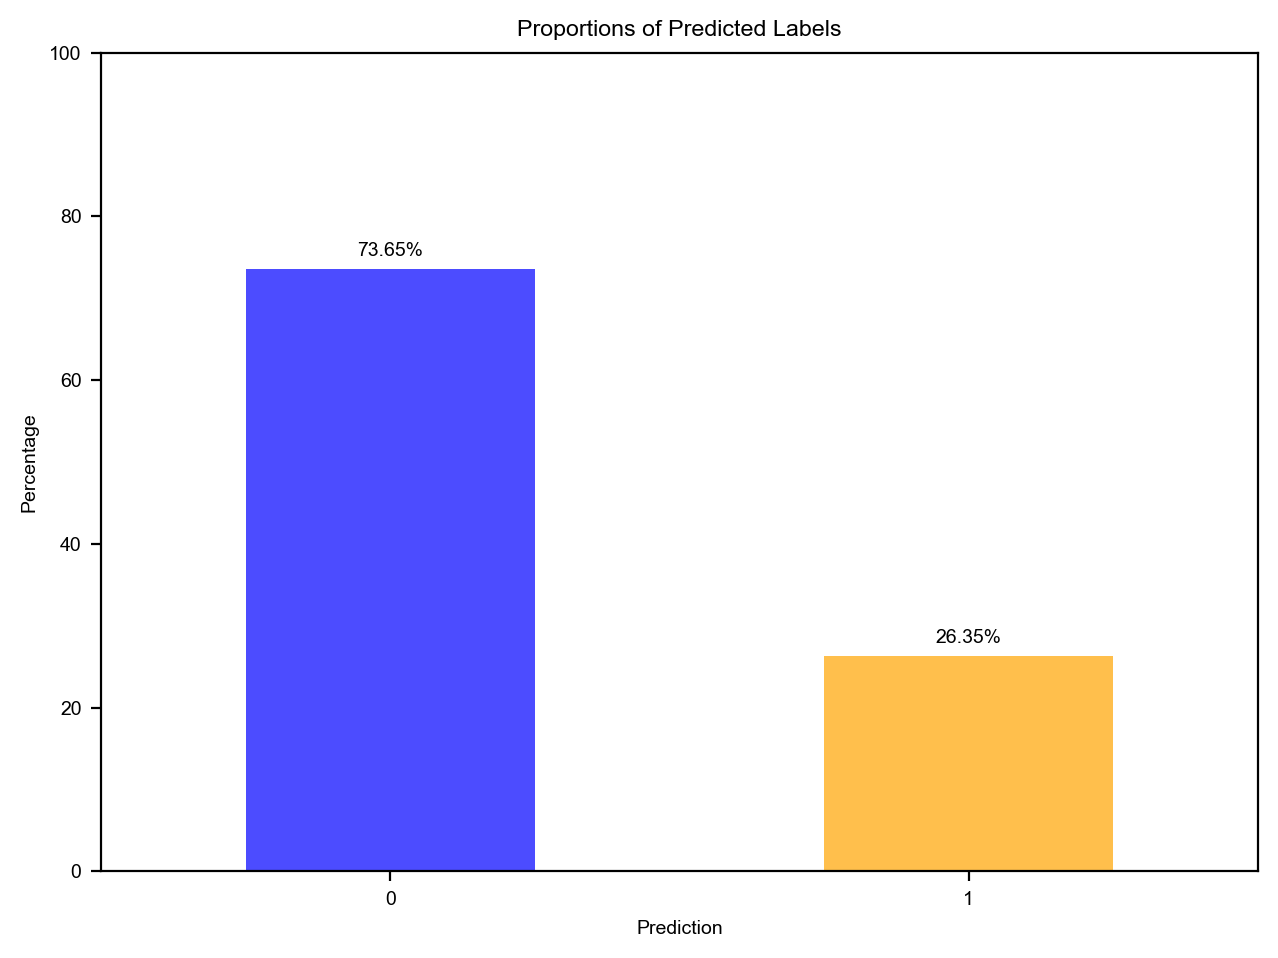

Bar plot of predicted label percentages saved to 'prediction_percentage_barplot.png'.


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt

plt.style.use("default")    
# Set global font properties
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 7
rcParams['font.weight'] = 'normal'

# Define model
# model =  RandomForestClassifier(max_depth=10, random_state=41)
model =   RandomForestClassifier(max_depth=10, random_state=41)
np.random.seed(42)  # For reproducibility

 
 
# Scale the training data
scaler = StandardScaler()
full_X_train_scaled = scaler.fit_transform(full_X_train)

# Scale the test data
adata1_scaled = scaler.transform(extracted_columns_1)

# Fit the model on the training data
model.fit(full_X_train_scaled, full_Y_train)

# Predict labels for adata1
predicted_labels = model.predict(adata1_scaled)

# Save predictions to a CSV file
output_df = pd.DataFrame({"Prediction": predicted_labels})
output_df.to_csv("predicted_labels_jun16.csv", index=False)
print("Predicted labels saved to 'predicted_labels_jun16.csv'.")

# Calculate percentages for the bar plot
label_counts = pd.Series(predicted_labels).value_counts(normalize=True) * 100  # Convert to percentages

# Create a bar plot
label_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
plt.xlabel("Prediction")
plt.ylabel("Percentage")
plt.title("Proportions of Predicted Labels")
plt.xticks([0, 1], labels=['0', '1'], rotation=0)
plt.ylim(0, 100)  # Ensure the y-axis ranges from 0 to 100
plt.tight_layout()

# Add percentage labels on the bars
for i, v in enumerate(label_counts):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom', fontsize=7)

# Save and show the plot
plt.savefig("prediction_percentage_barplot.png", dpi=300)
plt.show()

print("Bar plot of predicted label percentages saved to 'prediction_percentage_barplot.png'.")

Output directory created/verified: /Users/haley/Desktop/send_tooo/AAA_final/wtwt

Training models and making predictions...

Training LogisticRegression...
  - Predictions and probabilities saved to '/Users/haley/Desktop/send_tooo/AAA_final/wtwt/predicted_labels_probs_LogisticRegression_jun16.csv'
  - CV Accuracy: 0.9009 (+/- 0.0182)
  - CV ROC-AUC: 0.9680 (+/- 0.0082)

Training LinearSVC...
  - Predictions and probabilities saved to '/Users/haley/Desktop/send_tooo/AAA_final/wtwt/predicted_labels_probs_LinearSVC_jun16.csv'
  - CV Accuracy: 0.9012 (+/- 0.0178)
  - CV ROC-AUC: 0.9678 (+/- 0.0084)

Training XGBClassifier...
  - Predictions and probabilities saved to '/Users/haley/Desktop/send_tooo/AAA_final/wtwt/predicted_labels_probs_XGBClassifier_jun16.csv'
  - CV Accuracy: 0.9045 (+/- 0.0088)
  - CV ROC-AUC: 0.9684 (+/- 0.0054)

Training RandomForestClassifier...
  - Predictions and probabilities saved to '/Users/haley/Desktop/send_tooo/AAA_final/wtwt/predicted_labels_probs_RandomFores

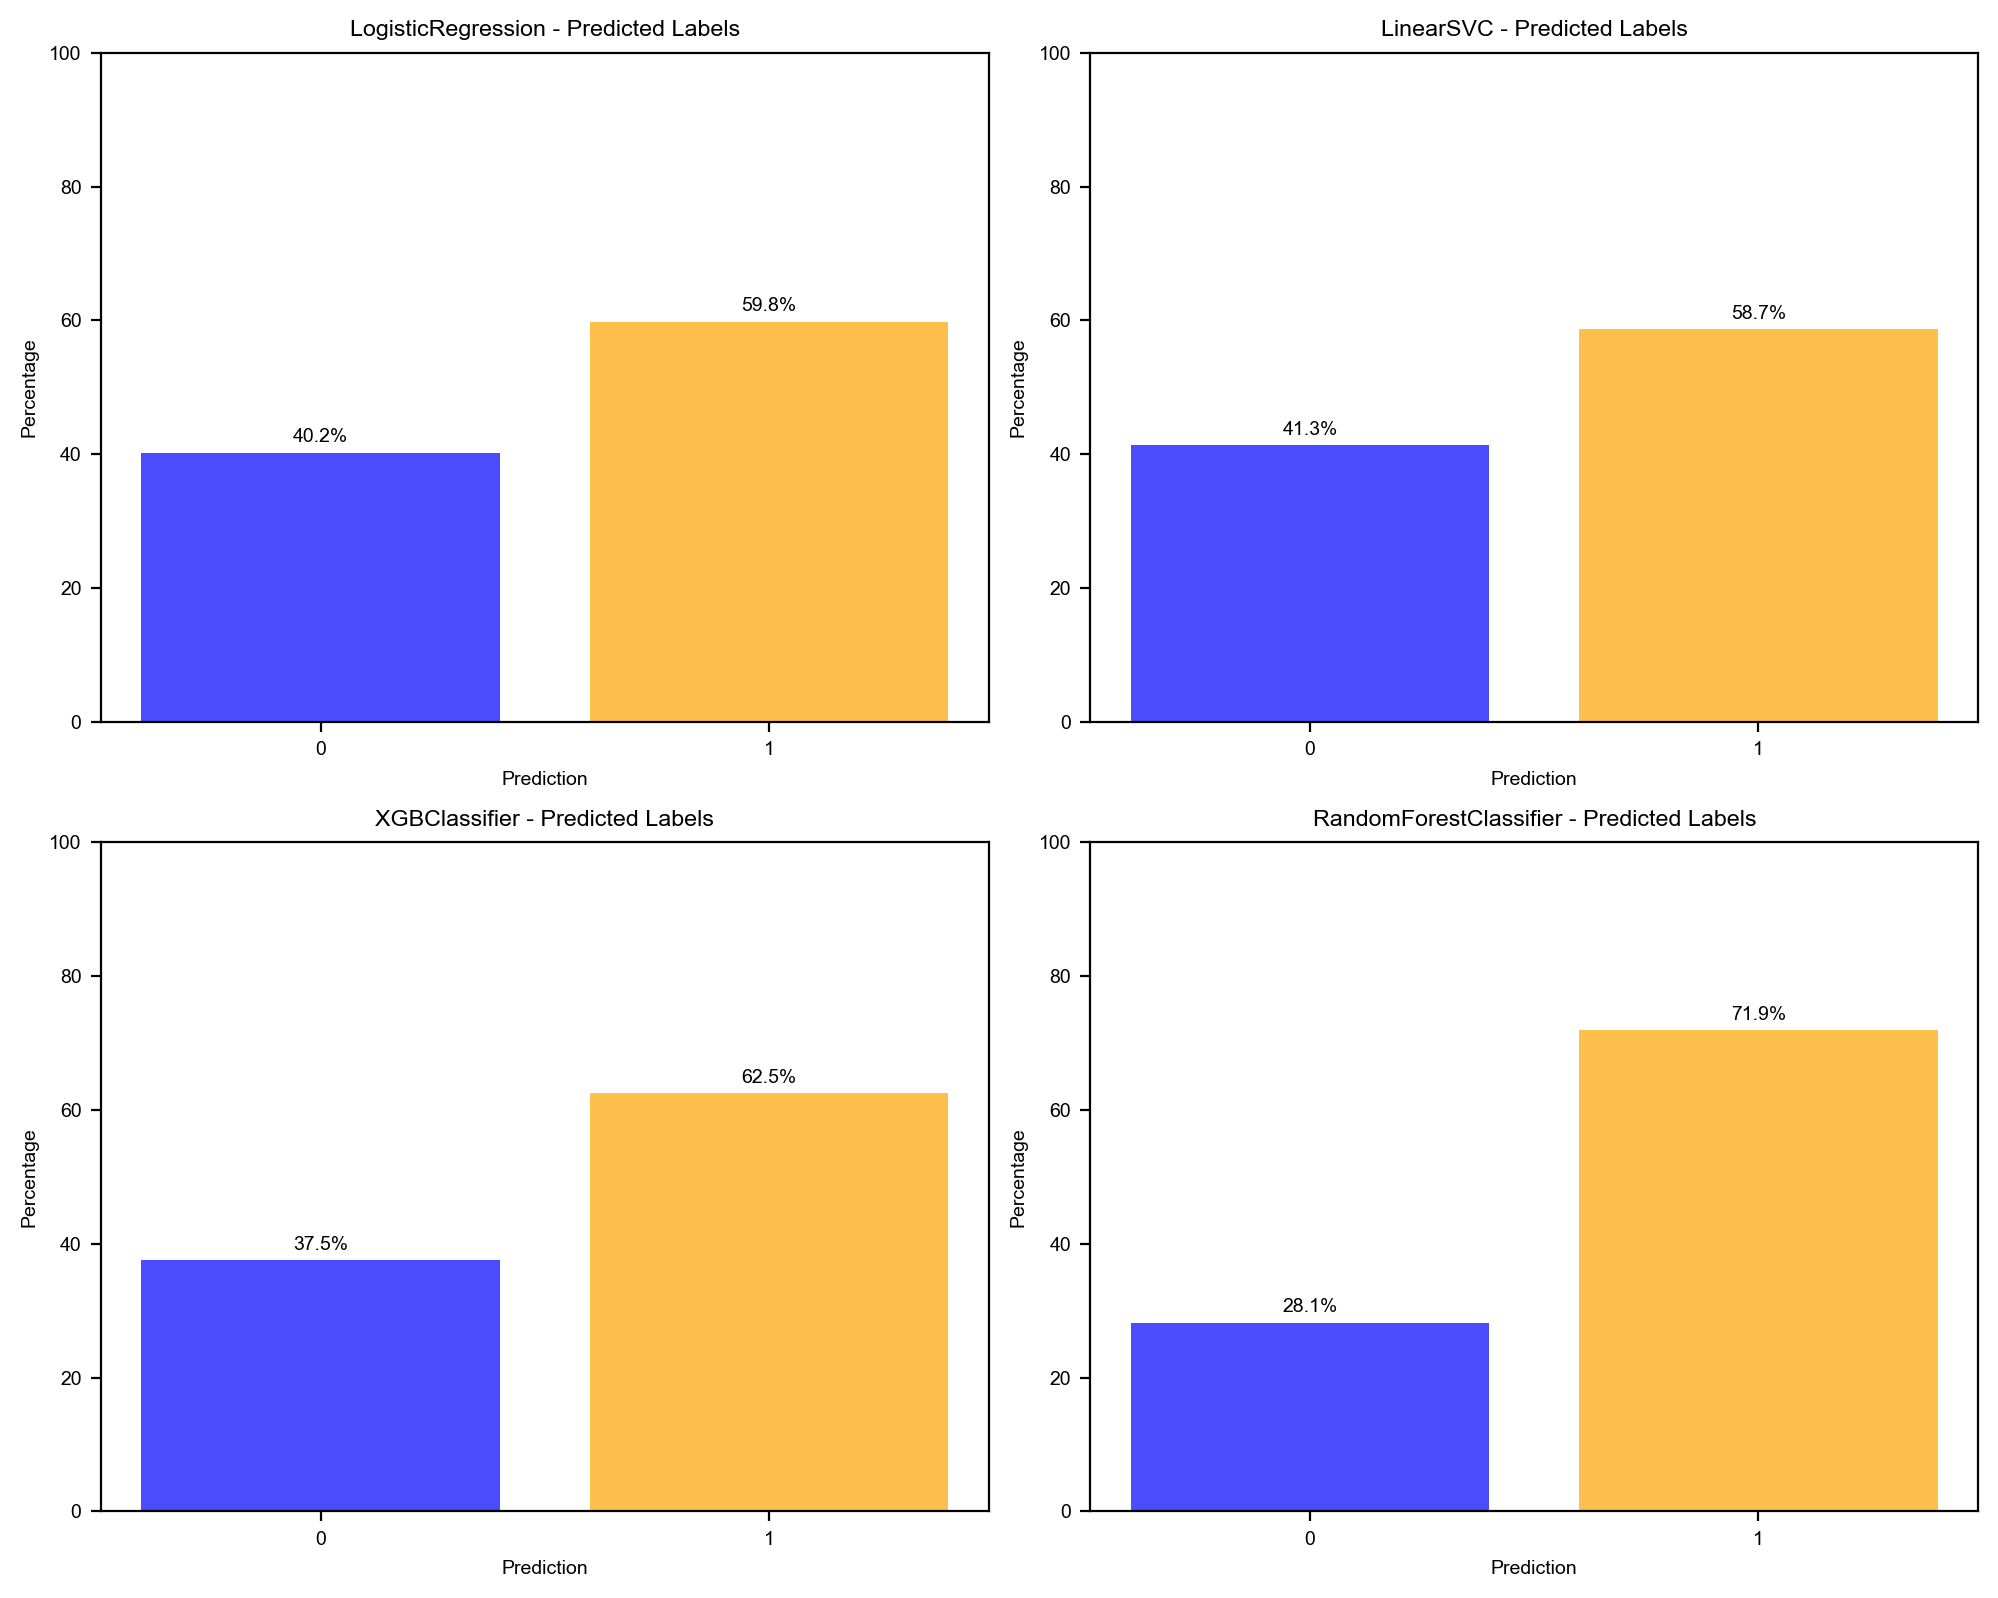

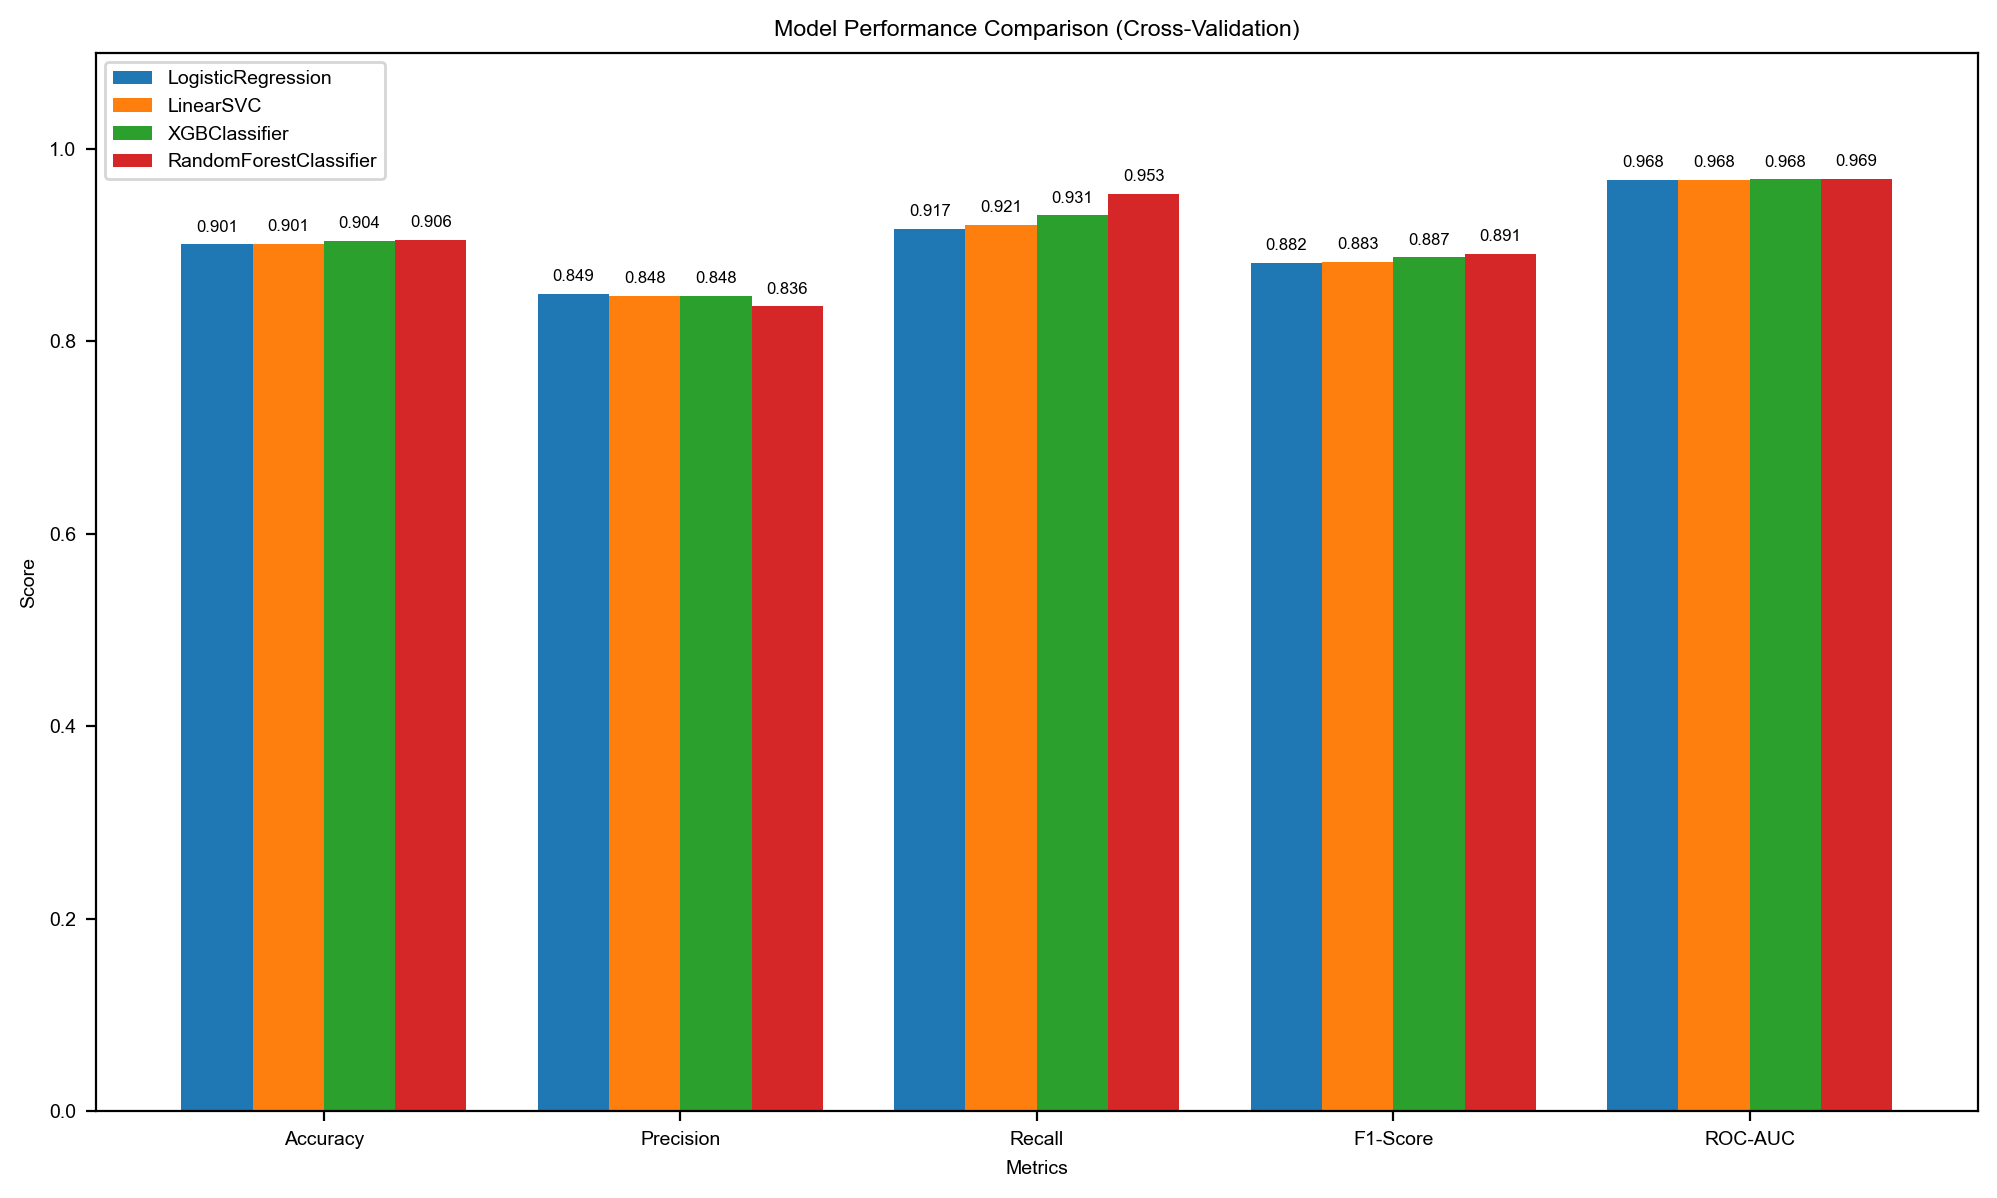

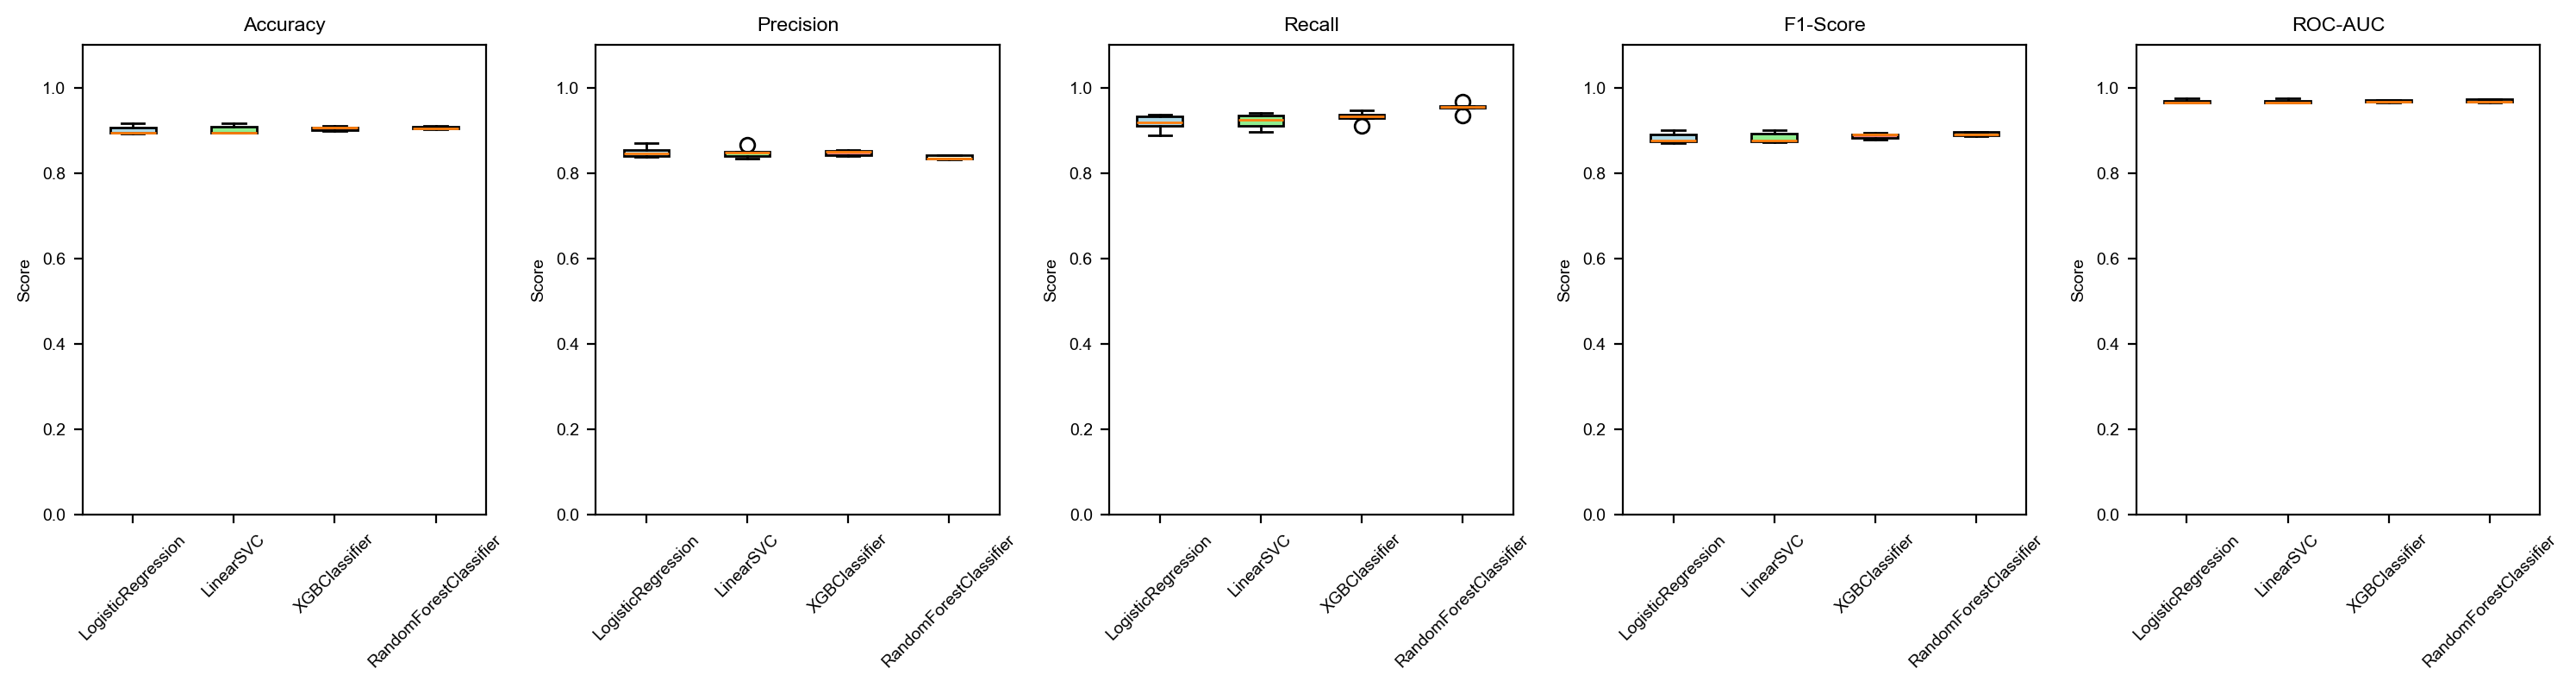


Ensemble predictions (majority voting) and probabilities saved to '/Users/haley/Desktop/send_tooo/AAA_final/wtwt/predicted_labels_probs_ensemble_jun16.csv'


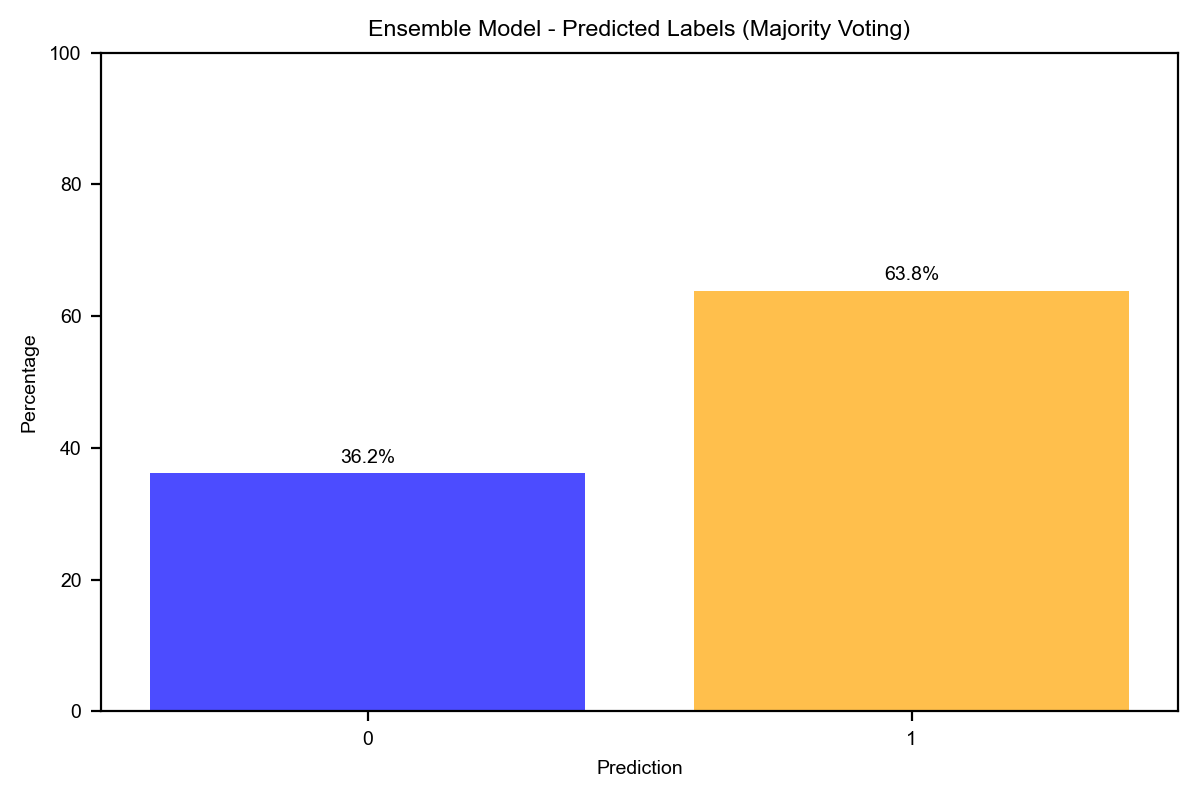

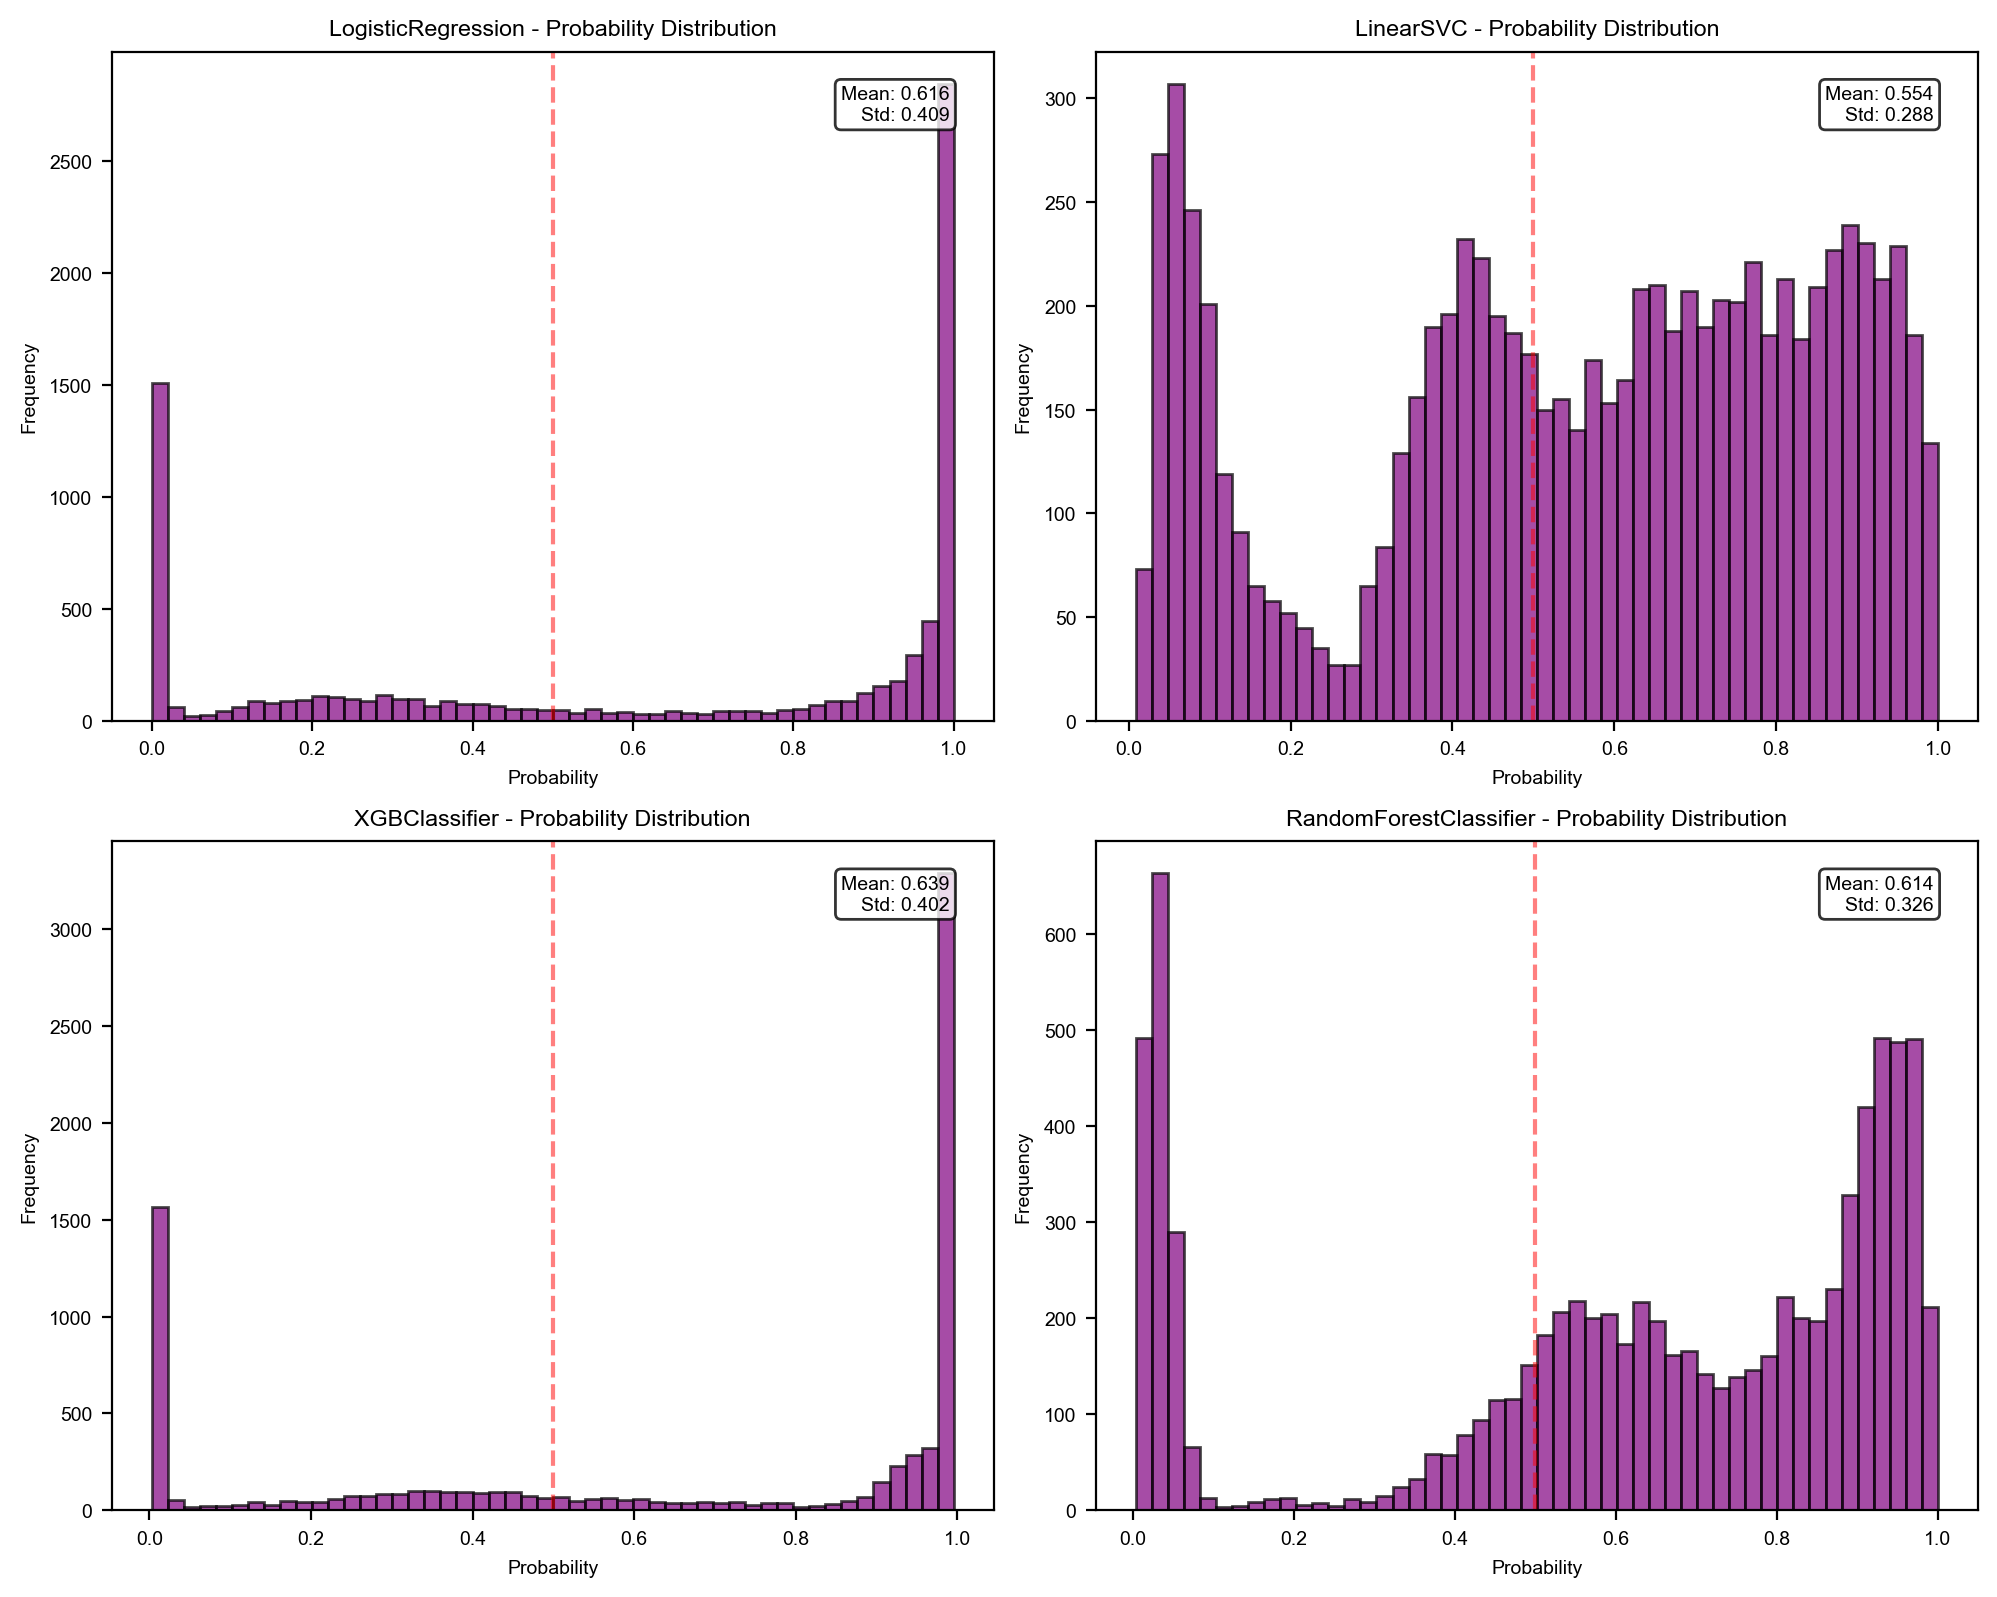

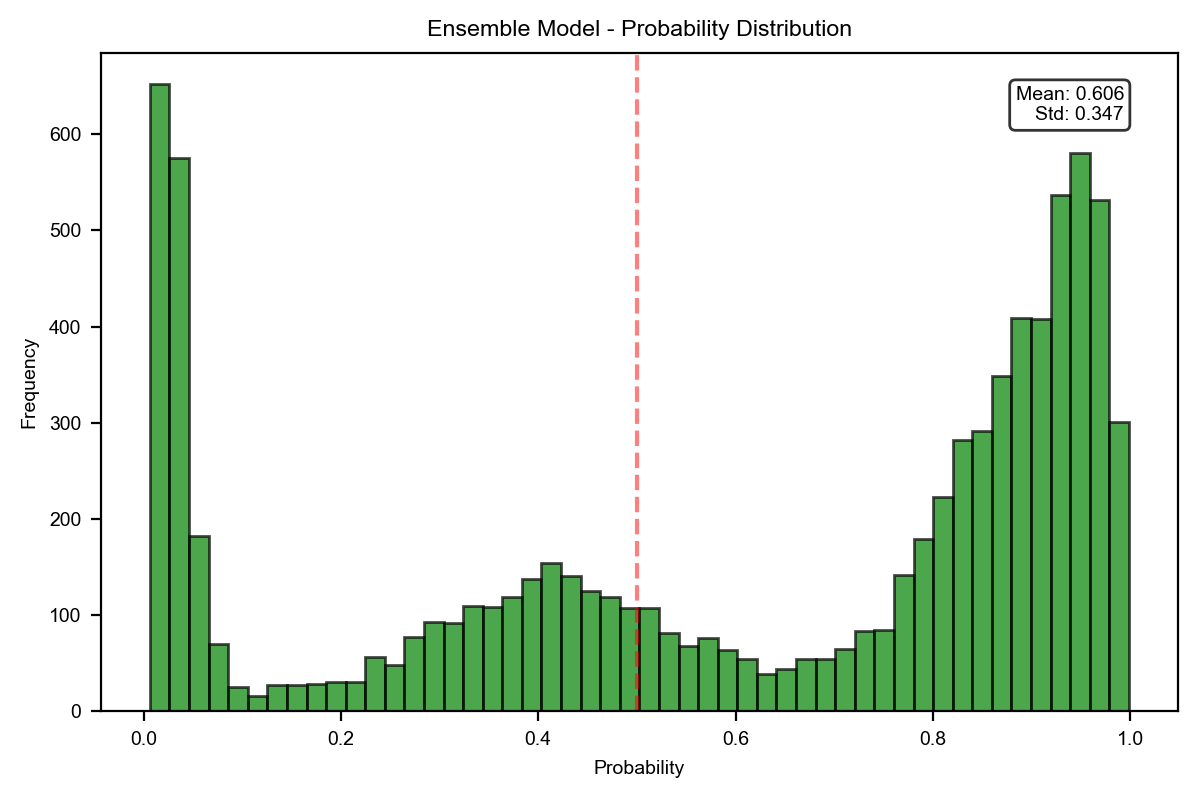


All files have been saved to: /Users/haley/Desktop/send_tooo/AAA_final/wtwt

Saved files:
- predicted_labels_probs_LogisticRegression_jun16.csv
- predicted_labels_probs_LinearSVC_jun16.csv
- predicted_labels_probs_XGBClassifier_jun16.csv
- predicted_labels_probs_RandomForestClassifier_jun16.csv
- predicted_labels_probs_ensemble_jun16.csv
- model_performance_summary.csv
- all_models_prediction_distributions.png
- model_performance_comparison.png
- cv_scores_boxplot.png
- ensemble_prediction_barplot.png
- probability_distributions.png
- ensemble_probability_distribution.png

Analysis complete!


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import warnings
warnings.filterwarnings('ignore')

# Set style and global font properties
plt.style.use("default")
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 7
rcParams['font.weight'] = 'normal'

# Create output directory
output_dir = "/Users/haley/Desktop/send_tooo/AAA_final/wtwt"
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created/verified: {output_dir}")

# Define number of cores for parallel processing
n_cores = -1  # Use all available cores

# Define models
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000, 
        n_jobs=n_cores,
        random_state=41
    ),
    "LinearSVC": LinearSVC(
        dual=False,  # Better for many features
        random_state=41
    ),
    "XGBClassifier": XGBClassifier(
        eval_metric='logloss', 
        n_estimators=100, 
        learning_rate=0.05, 
        max_depth=10,
        n_jobs=n_cores,
        random_state=41
    ),
    "RandomForestClassifier": RandomForestClassifier(
        max_depth=10,
        n_jobs=n_cores,
        random_state=66
    ),
}

# Scale the training data
scaler = StandardScaler()
full_X_train_scaled = scaler.fit_transform(full_X_train)

# Scale the test data
adata1_scaled = scaler.transform(extracted_columns_1)

# Dictionary to store results
results = {}
predictions = {}
probabilities = {}
cv_scores = {}

# Train each model and make predictions
print("\nTraining models and making predictions...\n")

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Fit the model
    model.fit(full_X_train_scaled, full_Y_train)
    
    # Make predictions
    predicted_labels = model.predict(adata1_scaled)
    predictions[model_name] = predicted_labels
    
    # Get prediction probabilities (if available)
    if hasattr(model, "predict_proba"):
        predicted_probs = model.predict_proba(adata1_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        # For SVM, convert decision function to probabilities using sigmoid
        decision_values = model.decision_function(adata1_scaled)
        predicted_probs = 1 / (1 + np.exp(-decision_values))
    else:
        predicted_probs = predicted_labels.astype(float)
    
    probabilities[model_name] = predicted_probs
    
    # Perform cross-validation on training data to get performance metrics
    cv_accuracy = cross_val_score(model, full_X_train_scaled, full_Y_train, cv=5, scoring='accuracy')
    cv_precision = cross_val_score(model, full_X_train_scaled, full_Y_train, cv=5, scoring='precision')
    cv_recall = cross_val_score(model, full_X_train_scaled, full_Y_train, cv=5, scoring='recall')
    cv_f1 = cross_val_score(model, full_X_train_scaled, full_Y_train, cv=5, scoring='f1')
    cv_roc_auc = cross_val_score(model, full_X_train_scaled, full_Y_train, cv=5, scoring='roc_auc')
    
    # Store cross-validation scores
    cv_scores[model_name] = {
        'accuracy': cv_accuracy,
        'precision': cv_precision,
        'recall': cv_recall,
        'f1': cv_f1,
        'roc_auc': cv_roc_auc
    }
    
    # Store results
    results[model_name] = {
        'predictions': predicted_labels,
        'probabilities': predicted_probs,
        'cv_accuracy': cv_accuracy.mean(),
        'cv_precision': cv_precision.mean(),
        'cv_recall': cv_recall.mean(),
        'cv_f1': cv_f1.mean(),
        'cv_roc_auc': cv_roc_auc.mean()
    }
    
    # Save predictions and probabilities to CSV in the specified folder
    output_df = pd.DataFrame({
        "Prediction": predicted_labels,
        "Probability": predicted_probs
    })
    output_file = os.path.join(output_dir, f"predicted_labels_probs_{model_name}_jun16.csv")
    output_df.to_csv(output_file, index=False)
    print(f"  - Predictions and probabilities saved to '{output_file}'")
    print(f"  - CV Accuracy: {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std() * 2:.4f})")
    print(f"  - CV ROC-AUC: {cv_roc_auc.mean():.4f} (+/- {cv_roc_auc.std() * 2:.4f})\n")

# Create performance comparison table
print("\nModel Performance Summary (Cross-Validation):")
print("-" * 70)
performance_df = pd.DataFrame({
    model_name: {
        'Accuracy': f"{results[model_name]['cv_accuracy']:.4f}",
        'Precision': f"{results[model_name]['cv_precision']:.4f}",
        'Recall': f"{results[model_name]['cv_recall']:.4f}",
        'F1-Score': f"{results[model_name]['cv_f1']:.4f}",
        'ROC-AUC': f"{results[model_name]['cv_roc_auc']:.4f}"
    } for model_name in models.keys()
}).T
print(performance_df)

# Save performance summary to CSV in the output folder
performance_file = os.path.join(output_dir, "model_performance_summary.csv")
performance_df.to_csv(performance_file)
print(f"\nPerformance summary saved to '{performance_file}'")

# Create visualizations
# 1. Bar plot comparing prediction distributions
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for idx, (model_name, preds) in enumerate(predictions.items()):
    ax = axes[idx]
    label_counts = pd.Series(preds).value_counts(normalize=True) * 100
    
    bars = ax.bar([0, 1], label_counts.sort_index(), color=['blue', 'orange'], alpha=0.7)
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Percentage")
    ax.set_title(f"{model_name} - Predicted Labels")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['0', '1'])
    ax.set_ylim(0, 100)
    
    # Add percentage labels on bars
    for bar, count in zip(bars, label_counts.sort_index()):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{count:.1f}%', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "all_models_prediction_distributions.png"), dpi=300)
plt.show()

# 2. Performance metrics comparison plot
metrics = ['cv_accuracy', 'cv_precision', 'cv_recall', 'cv_f1', 'cv_roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metric_names))
width = 0.2

for i, model_name in enumerate(models.keys()):
    values = [results[model_name][metric] for metric in metrics]
    ax.bar(x + i*width, values, width, label=model_name)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison (Cross-Validation)')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metric_names)
ax.legend()
ax.set_ylim(0, 1.1)

# Add value labels on bars
for i, model_name in enumerate(models.keys()):
    values = [results[model_name][metric] for metric in metrics]
    for j, v in enumerate(values):
        ax.text(j + i*width, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=6)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "model_performance_comparison.png"), dpi=300)
plt.show()

# 3. Box plot for cross-validation scores
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
metrics_for_box = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names_for_box = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, (metric, metric_name) in enumerate(zip(metrics_for_box, metric_names_for_box)):
    ax = axes[idx]
    data_to_plot = [cv_scores[model_name][metric] for model_name in models.keys()]
    bp = ax.boxplot(data_to_plot, labels=list(models.keys()), patch_artist=True)
    
    # Color the boxes
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(metric_name)
    ax.set_ylabel('Score')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "cv_scores_boxplot.png"), dpi=300)
plt.show()

# 4. Create ensemble predictions (majority voting) and average probabilities
ensemble_predictions = np.zeros_like(predictions['LogisticRegression'])
ensemble_probabilities = np.zeros_like(probabilities['LogisticRegression'])

for model_preds in predictions.values():
    ensemble_predictions += model_preds

for model_probs in probabilities.values():
    ensemble_probabilities += model_probs

# Majority voting for predictions
ensemble_predictions = (ensemble_predictions >= len(models) / 2).astype(int)
# Average probabilities
ensemble_probabilities = ensemble_probabilities / len(models)

# Save ensemble predictions and probabilities
ensemble_df = pd.DataFrame({
    "Prediction": ensemble_predictions,
    "Probability": ensemble_probabilities
})
ensemble_file = os.path.join(output_dir, "predicted_labels_probs_ensemble_jun16.csv")
ensemble_df.to_csv(ensemble_file, index=False)
print(f"\nEnsemble predictions (majority voting) and probabilities saved to '{ensemble_file}'")

# Plot ensemble predictions
plt.figure(figsize=(6, 4))
ensemble_counts = pd.Series(ensemble_predictions).value_counts(normalize=True) * 100
bars = plt.bar([0, 1], ensemble_counts.sort_index(), color=['blue', 'orange'], alpha=0.7)
plt.xlabel("Prediction")
plt.ylabel("Percentage")
plt.title("Ensemble Model - Predicted Labels (Majority Voting)")
plt.xticks([0, 1], labels=['0', '1'])
plt.ylim(0, 100)

# Add percentage labels
for bar, count in zip(bars, ensemble_counts.sort_index()):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{count:.1f}%', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "ensemble_prediction_barplot.png"), dpi=300)
plt.show()

# 5. Add probability distribution plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for idx, (model_name, probs) in enumerate(probabilities.items()):
    ax = axes[idx]
    ax.hist(probs, bins=50, alpha=0.7, color='purple', edgecolor='black')
    ax.set_xlabel("Probability")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{model_name} - Probability Distribution")
    ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
    
    # Add statistics
    ax.text(0.95, 0.95, f'Mean: {np.mean(probs):.3f}\nStd: {np.std(probs):.3f}', 
            transform=ax.transAxes, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=7)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "probability_distributions.png"), dpi=300)
plt.show()

# Plot ensemble probability distribution
plt.figure(figsize=(6, 4))
plt.hist(ensemble_probabilities, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Ensemble Model - Probability Distribution")
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)

# Add statistics
plt.text(0.95, 0.95, f'Mean: {np.mean(ensemble_probabilities):.3f}\nStd: {np.std(ensemble_probabilities):.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=7)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "ensemble_probability_distribution.png"), dpi=300)
plt.show()

print(f"\nAll files have been saved to: {output_dir}")
print("\nSaved files:")
print("- predicted_labels_probs_LogisticRegression_jun16.csv")
print("- predicted_labels_probs_LinearSVC_jun16.csv")
print("- predicted_labels_probs_XGBClassifier_jun16.csv")
print("- predicted_labels_probs_RandomForestClassifier_jun16.csv")
print("- predicted_labels_probs_ensemble_jun16.csv")
print("- model_performance_summary.csv")
print("- all_models_prediction_distributions.png")
print("- model_performance_comparison.png")
print("- cv_scores_boxplot.png")
print("- ensemble_prediction_barplot.png")
print("- probability_distributions.png")
print("- ensemble_probability_distribution.png")

print("\nAnalysis complete!")

Predicted probabilities and labels saved to 'predicted_probabilities_jun16.csv'.

Summary Statistics:
Mean probability for class 1: 0.6145
Min probability for class 1: 0.0031
Max probability for class 1: 0.9995


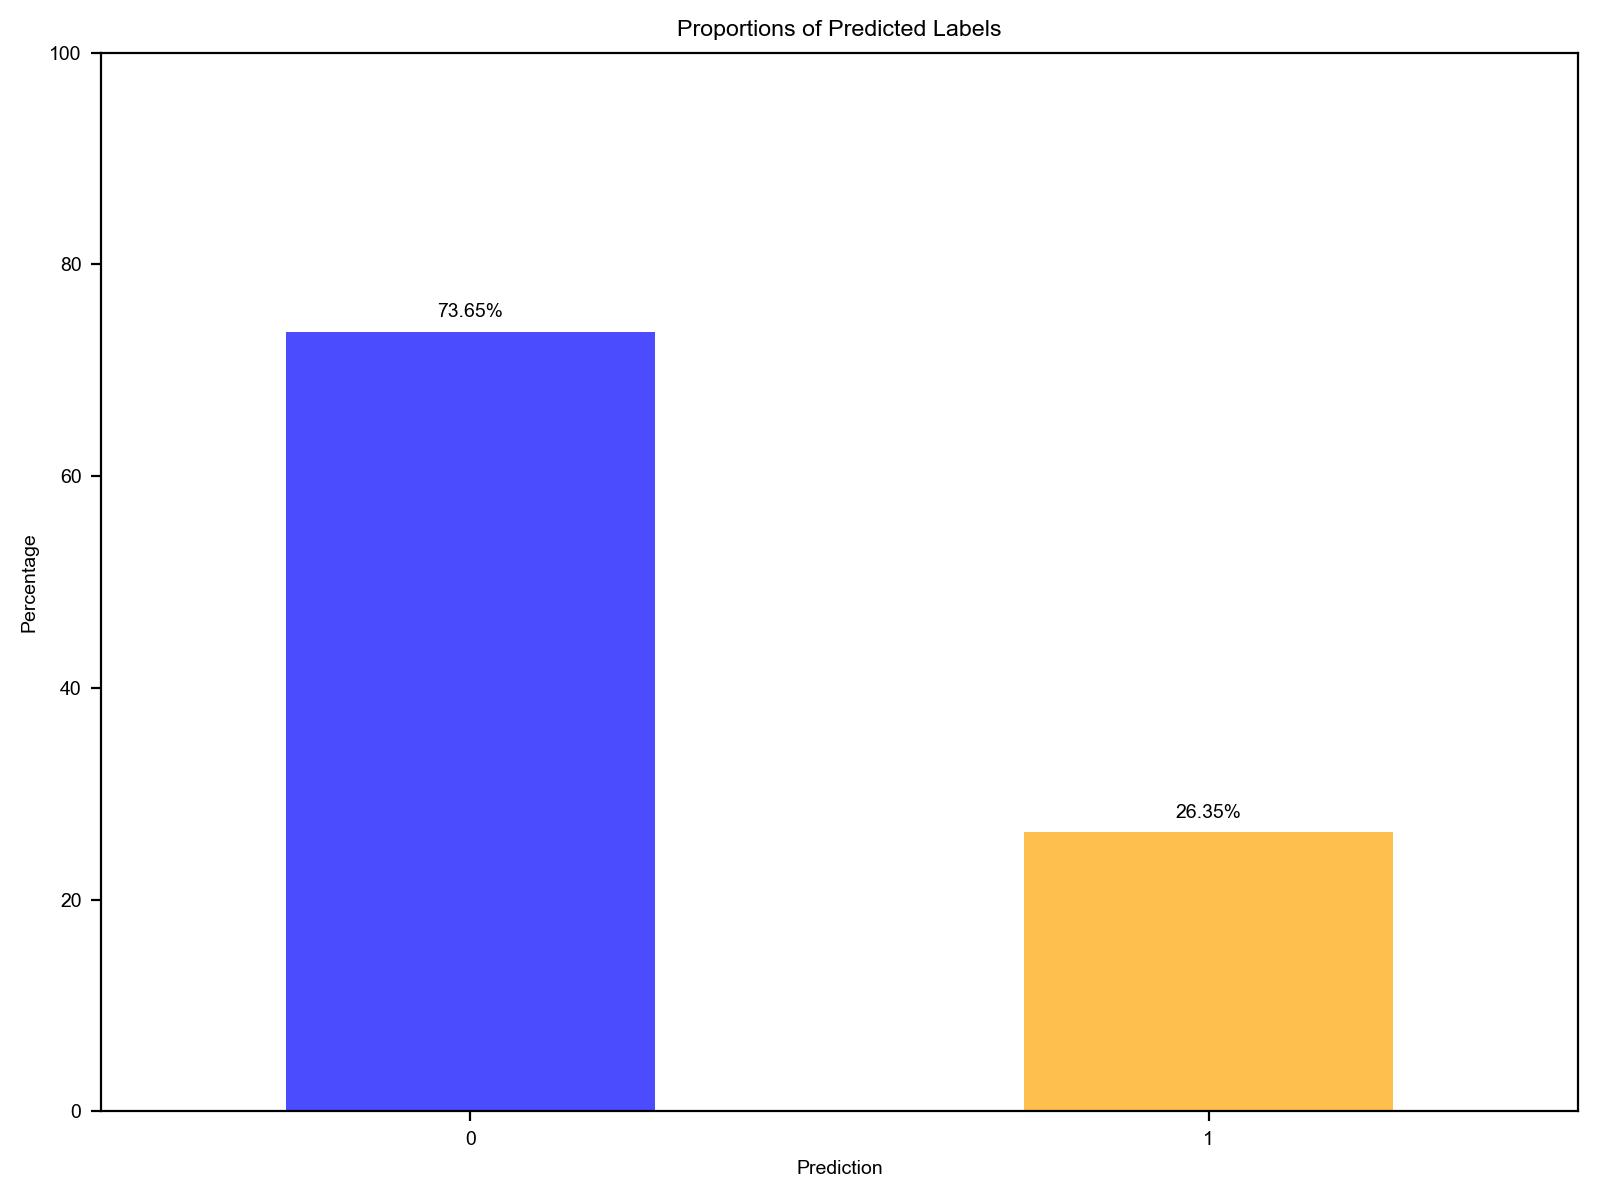

Bar plot of predicted label percentages saved to 'prediction_percentage_barplot.png'.


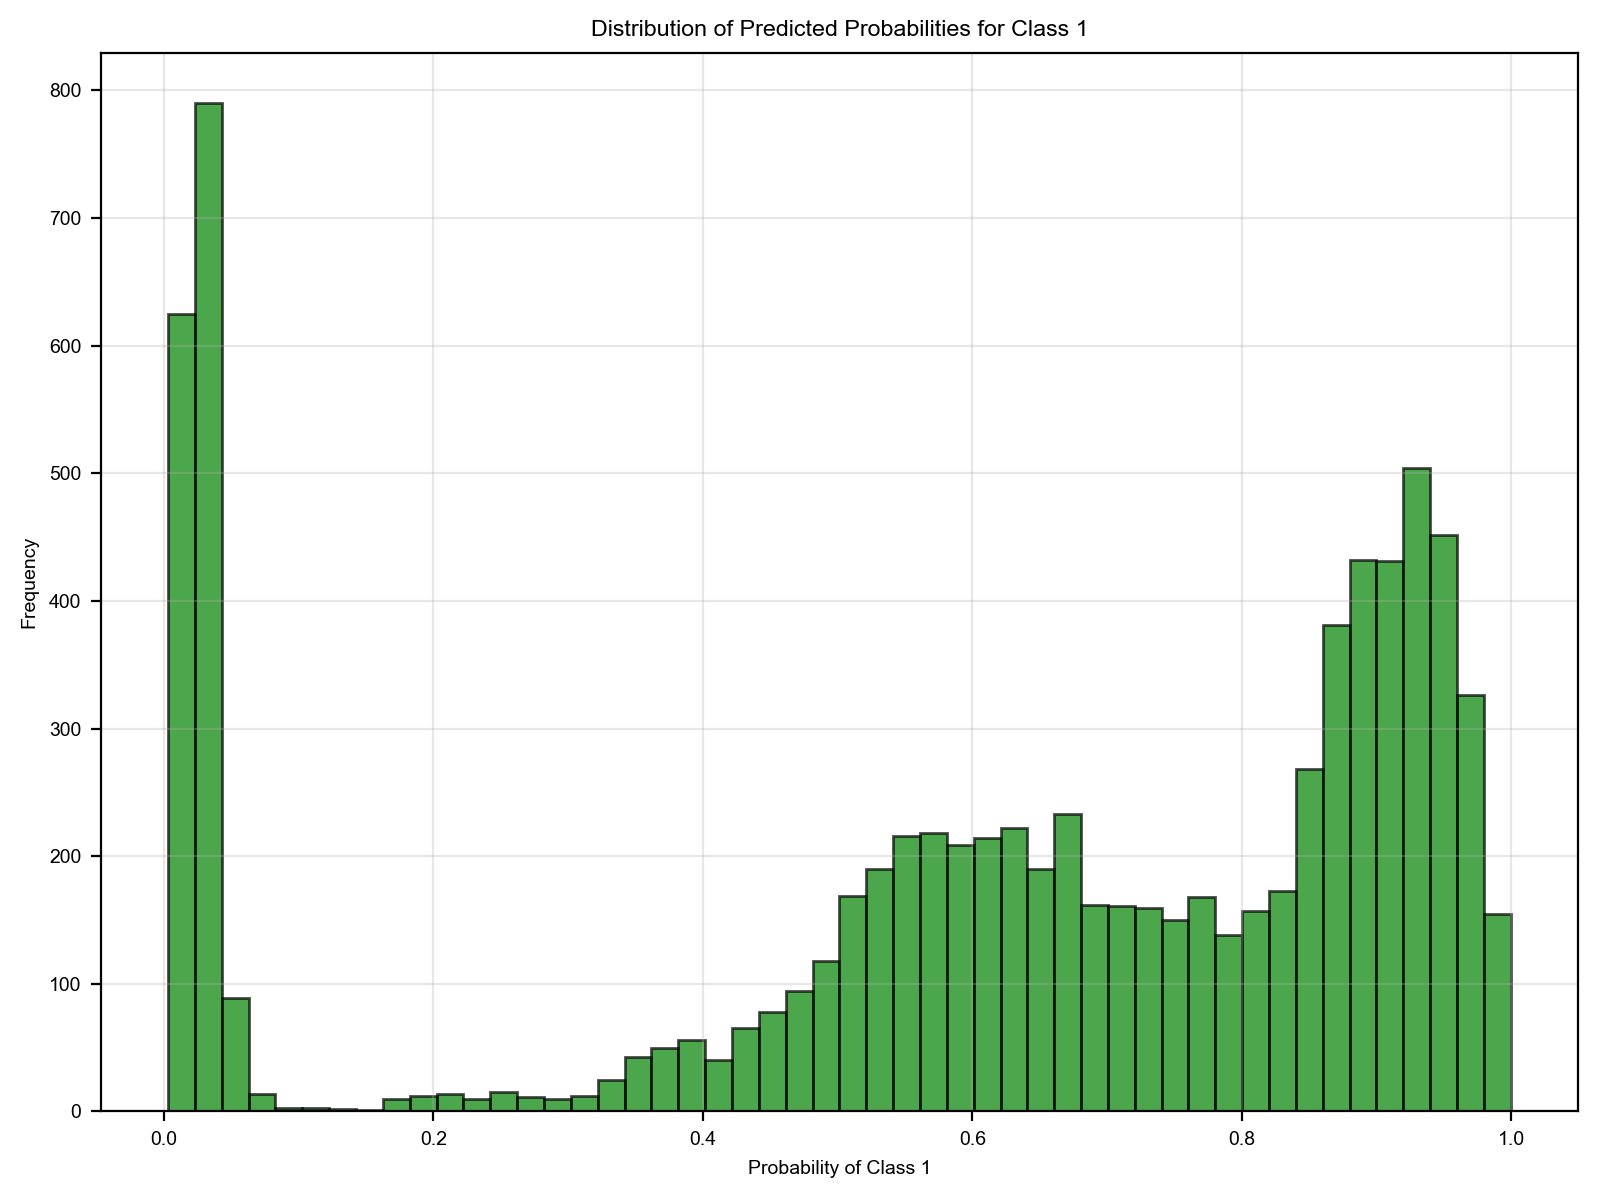

Probability distribution plot saved to 'probability_distribution_class1.png'.


In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.ensemble import RandomForestClassifier  # Added missing import
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt

plt.style.use("default")    
# Set global font properties
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 7
rcParams['font.weight'] = 'normal'

# Define model
# model =  RandomForestClassifier(max_depth=10, random_state=41)
model = RandomForestClassifier(max_depth=10, random_state=41)
np.random.seed(42)  # For reproducibility

# Scale the training data
scaler = StandardScaler()
full_X_train_scaled = scaler.fit_transform(full_X_train)

# Scale the test data
adata1_scaled = scaler.transform(extracted_columns_1)

# Fit the model on the training data
model.fit(full_X_train_scaled, full_Y_train)

# Predict probabilities for adata1
predicted_probabilities = model.predict_proba(adata1_scaled)

# Predict labels for adata1
predicted_labels = model.predict(adata1_scaled)

# Create output DataFrame with both probabilities and predictions
output_df = pd.DataFrame({
    "Probability_Class_0": predicted_probabilities[:, 0],  # Probability of class 0
    "Probability_Class_1": predicted_probabilities[:, 1],  # Probability of class 1
    "Predicted_Label": predicted_labels
})

# Save to CSV file
output_df.to_csv("predicted_probabilities_jun16.csv", index=False)
print("Predicted probabilities and labels saved to 'predicted_probabilities_jun16.csv'.")

# Display summary statistics
print("\nSummary Statistics:")
print(f"Mean probability for class 1: {predicted_probabilities[:, 1].mean():.4f}")
print(f"Min probability for class 1: {predicted_probabilities[:, 1].min():.4f}")
print(f"Max probability for class 1: {predicted_probabilities[:, 1].max():.4f}")

# Calculate percentages for the bar plot
label_counts = pd.Series(predicted_labels).value_counts(normalize=True) * 100  # Convert to percentages

# Create a bar plot
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
plt.xlabel("Prediction")
plt.ylabel("Percentage")
plt.title("Proportions of Predicted Labels")
plt.xticks([0, 1], labels=['0', '1'], rotation=0)
plt.ylim(0, 100)  # Ensure the y-axis ranges from 0 to 100
plt.tight_layout()

# Add percentage labels on the bars
for i, v in enumerate(label_counts):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom', fontsize=7)

# Save and show the plot
plt.savefig("prediction_percentage_barplot.png", dpi=300)
plt.show()

print("Bar plot of predicted label percentages saved to 'prediction_percentage_barplot.png'.")

# Optional: Create histogram of probabilities for class 1
plt.figure(figsize=(8, 6))
plt.hist(predicted_probabilities[:, 1], bins=50, alpha=0.7, color='green', edgecolor='black')
plt.xlabel("Probability of Class 1")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities for Class 1")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("probability_distribution_class1.png", dpi=300)
plt.show()

print("Probability distribution plot saved to 'probability_distribution_class1.png'.")

In [89]:
# Predict labels for adata1
predicted_labels = model.predict(adata1_scaled)

# Save predictions to a CSV file
output_df = pd.DataFrame({"Prediction": predicted_labels})
output_df.to_csv("predicted_labels.csv", index=False)
print("Predicted labels saved to 'dec_3_predicted_labels.csv'.")


Predicted labels saved to 'dec_3_predicted_labels.csv'.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc

# Set global font properties
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 7
rcParams['font.weight'] = 'normal'


# LogisticRegression(max_iter=1000, random_state=551),
#         SVC(kernel='linear', probability=True, random_state=551),
#         XGBClassifier(
#             use_label_encoder=False,
#             eval_metric='logloss',
#             n_estimators=100,
#             learning_rate=0.05,
#             max_depth=10,
#             random_state=551
#         ),
#         RandomForestClassifier(max_depth=10, random_state=41)


# Define model
# model = XGBClassifier(
#     use_label_encoder=False,
#     eval_metric='logloss',
#     n_estimators=300,  # set large n_estimators but use early_stopping
#     learning_rate=0.01,
#     max_depth=6,
#     random_state=551
# )500	0.05	6
model =XGBClassifier(
use_label_encoder=False,
            eval_metric='logloss',
            random_state=551,
    n_estimators=500,  # set large n_estimators but use early_stopping
    learning_rate=0.05,
    max_depth=6
   
)
np.random.seed(42)  # For reproducibility

# Scale the training data
scaler = StandardScaler()
full_X_train_scaled = scaler.fit_transform(full_X_train)

# Fit the model on the training data
model.fit(full_X_train_scaled, full_Y_train)

# Function to process each dataset
def process_and_save(extracted_columns, name):
    # Scale the test data
    adata_scaled = scaler.transform(extracted_columns)

    # Predict labels
    predicted_labels = model.predict(adata_scaled)

    # Save predictions to a CSV file
    output_df = pd.DataFrame({"Prediction": predicted_labels})
    output_file = f"predicted_labels_{name}.csv"
    output_df.to_csv(output_file, index=False)
    print(f"Predicted labels saved to '{output_file}'.")

    # Calculate percentages for the bar plot
    label_counts = pd.Series(predicted_labels).value_counts(normalize=True) * 100  # Convert to percentages

    # Create a bar plot
    label_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
    plt.xlabel("Prediction")
    plt.ylabel("Percentage")
    plt.title(f"Proportions of Predicted Labels - {name}")
    plt.xticks([0, 1], labels=['0', '1'], rotation=0)
    plt.ylim(0, 100)  # Ensure the y-axis ranges from 0 to 100
    plt.tight_layout()

    # Add percentage labels on the bars
    for i, v in enumerate(label_counts):
        plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom', fontsize=7)

    # Save and show the plot
    plot_file = f"prediction_percentage_barplot_{name}.png"
    plt.savefig(plot_file, dpi=300)
    plt.close()  # Close the plot to avoid overlap in subsequent iterations
    print(f"Bar plot of predicted label percentages saved to '{plot_file}'.")

# Process each dataset
process_and_save(extracted_columns_1, "dataset_1")
process_and_save(extracted_columns_2, "dataset_2")
process_and_save(extracted_columns_3, "dataset_3")
process_and_save(extracted_columns_4, "dataset_4")


Predicted labels saved to 'predicted_labels_dataset_1.csv'.
Bar plot of predicted label percentages saved to 'prediction_percentage_barplot_dataset_1.png'.
Predicted labels saved to 'predicted_labels_dataset_2.csv'.
Bar plot of predicted label percentages saved to 'prediction_percentage_barplot_dataset_2.png'.
Predicted labels saved to 'predicted_labels_dataset_3.csv'.
Bar plot of predicted label percentages saved to 'prediction_percentage_barplot_dataset_3.png'.
Predicted labels saved to 'predicted_labels_dataset_4.csv'.
Bar plot of predicted label percentages saved to 'prediction_percentage_barplot_dataset_4.png'.


In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc

# Set global font properties
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 7
rcParams['font.weight'] = 'normal'

# Define model
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=551,
    n_estimators=500,
    learning_rate=0.15,
    max_depth=6
)
 
np.random.seed(42)  # For reproducibility

# Scale the training data
scaler = StandardScaler()
full_X_train_scaled = scaler.fit_transform(full_X_train)

# Fit the model on the training data
model.fit(full_X_train_scaled, full_Y_train)

# Function to process each dataset and print male percentage
def process_and_save(extracted_columns, name):
    # Scale the test data
    adata_scaled = scaler.transform(extracted_columns)

    # Predict labels
    predicted_labels = model.predict(adata_scaled)

    # Save predictions to a CSV file
    output_df = pd.DataFrame({"Prediction": predicted_labels})
    output_file = f"predicted_labels_{name}.csv"
    output_df.to_csv(output_file, index=False)
    print(f"Predicted labels saved to '{output_file}'.")

    # Calculate percentages for male (label 0)
    label_counts = pd.Series(predicted_labels).value_counts(normalize=True) * 100  # Convert to percentages
    male_percentage = label_counts.get(0, 0)  # Get male percentage (0), default to 0 if missing
    female_percentage = label_counts.get(1, 0)  # Get female percentage (1), default to 0 if missing

    print(f"{name} - Male Percentage: {male_percentage:.2f}%, Female Percentage: {female_percentage:.2f}%")

    # Create a bar plot
    label_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
    plt.xlabel("Prediction")
    plt.ylabel("Percentage")
    plt.title(f"Proportions of Predicted Labels - {name}")
    plt.xticks([0, 1], labels=['Male', 'Female'], rotation=0)
    plt.ylim(0, 100)  # Ensure the y-axis ranges from 0 to 100
    plt.tight_layout()

    # Add percentage labels on the bars
    for i, v in enumerate(label_counts):
        plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom', fontsize=7)

    # Save and close the plot
    plot_file = f"prediction_percentage_barplot_{name}.png"
    plt.savefig(plot_file, dpi=300)
    plt.close()  # Close the plot to avoid overlap in subsequent iterations
    print(f"Bar plot of predicted label percentages saved to '{plot_file}'.")

# Process each dataset and print male percentages
process_and_save(extracted_columns_1, "dataset_1")
process_and_save(extracted_columns_2, "dataset_2")
process_and_save(extracted_columns_3, "dataset_3")
process_and_save(extracted_columns_4, "dataset_4")


Predicted labels saved to 'predicted_labels_dataset_1.csv'.
dataset_1 - Male Percentage: 34.41%, Female Percentage: 65.59%
Bar plot of predicted label percentages saved to 'prediction_percentage_barplot_dataset_1.png'.
Predicted labels saved to 'predicted_labels_dataset_2.csv'.
dataset_2 - Male Percentage: 43.95%, Female Percentage: 56.05%
Bar plot of predicted label percentages saved to 'prediction_percentage_barplot_dataset_2.png'.
Predicted labels saved to 'predicted_labels_dataset_3.csv'.
dataset_3 - Male Percentage: 28.82%, Female Percentage: 71.18%
Bar plot of predicted label percentages saved to 'prediction_percentage_barplot_dataset_3.png'.
Predicted labels saved to 'predicted_labels_dataset_4.csv'.
dataset_4 - Male Percentage: 32.60%, Female Percentage: 67.40%
Bar plot of predicted label percentages saved to 'prediction_percentage_barplot_dataset_4.png'.
